# Loading The Data

In [61]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Defining the CNN

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Creaing the Loss Function and Optimizer

In [51]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Ad(net.parameters(), lr=0.001)


# Train The Network

In [19]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.001
[1,  2001] loss: 2.278
[1,  4001] loss: 1.935
[1,  6001] loss: 1.736
[1,  8001] loss: 1.623
[1, 10001] loss: 1.557
[1, 12001] loss: 1.512
[2,     1] loss: 0.001
[2,  2001] loss: 1.434
[2,  4001] loss: 1.401
[2,  6001] loss: 1.364
[2,  8001] loss: 1.370
[2, 10001] loss: 1.334
[2, 12001] loss: 1.299
Finished Training


In [20]:
# Save the network
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Image Review

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Test The Network

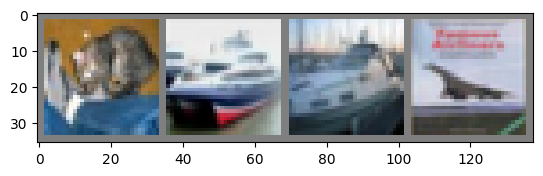

GroundTruth:  cat   ship  ship  plane


In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [23]:
# Test the ground truth against the trained networks
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


# Evaluate on Entire Trainset

In [24]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


In [25]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 61.0 %
Accuracy for class: car   is 53.6 %
Accuracy for class: bird  is 23.3 %
Accuracy for class: cat   is 41.3 %
Accuracy for class: deer  is 38.3 %
Accuracy for class: dog   is 45.9 %
Accuracy for class: frog  is 76.1 %
Accuracy for class: horse is 69.4 %
Accuracy for class: ship  is 60.1 %
Accuracy for class: truck is 61.4 %


# Use the GPU

To use the GPU, two changes need to be implemented

1. The network needs to point to the GPU
2. The data needs to be passed to the GPU

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [59]:
# create the network
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [62]:
# train

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        if i % 2 == 0:    # print every 2000 mini-batches
            print(loss.item())

        
        

print('Finished Training')

2.312220811843872
2.325312614440918
2.292815923690796
2.2765393257141113
2.265814781188965
2.336559534072876
2.333303928375244
2.309600830078125
2.3334672451019287
2.277294635772705
2.289341926574707
2.2780351638793945
2.2862281799316406
2.2923450469970703
2.2949633598327637
2.305830955505371
2.314821720123291
2.290008068084717
2.3137879371643066
2.3023035526275635
2.3171401023864746
2.307215690612793
2.2638614177703857
2.2963085174560547
2.2828900814056396
2.297711133956909
2.302405834197998
2.2930405139923096
2.2728114128112793
2.307526111602783
2.333710193634033
2.2970855236053467
2.3243629932403564
2.2934253215789795
2.299257516860962
2.3236944675445557
2.2841691970825195
2.28472900390625
2.3073205947875977
2.3122458457946777
2.3136892318725586
2.29667067527771
2.2818942070007324
2.3163163661956787
2.2862014770507812
2.3280029296875
2.322640895843506
2.318850040435791
2.3077595233917236
2.3033461570739746
2.303981304168701
2.294137477874756
2.2961792945861816
2.306208610534668
2.28

1.9339914321899414
1.6210373640060425
2.188401222229004
2.519758701324463
2.093658447265625
2.122641086578369
1.9643700122833252
1.8314948081970215
1.8956927061080933
2.262173652648926
1.840309739112854
2.306431293487549
2.6724233627319336
2.527566432952881
1.9107869863510132
2.044246196746826
2.0430917739868164
2.1754558086395264
1.8920239210128784
2.8638498783111572
2.106139659881592
2.0595221519470215
1.714705228805542
1.8209471702575684
2.5743861198425293
1.8755362033843994
1.8245272636413574
1.5311481952667236
2.4603753089904785
2.2695415019989014
2.1526317596435547
1.8517762422561646
3.0269246101379395
2.0882153511047363
1.9291893243789673
1.86240553855896
2.6210110187530518
1.968773365020752
1.909448504447937
2.226762056350708
1.9281058311462402
1.977060079574585
2.471923589706421
2.3739871978759766
2.2692296504974365
2.1515278816223145
2.600423574447632
2.5018622875213623
2.4158787727355957
1.8954851627349854
2.119645118713379
2.467712640762329
2.3653979301452637
1.823029279708

1.6255091428756714
1.7359174489974976
1.6243349313735962
1.3492357730865479
1.586270809173584
2.1672115325927734
1.8824046850204468
1.9306371212005615
1.9483568668365479
2.3285505771636963
2.0837435722351074
1.9683396816253662
1.3140110969543457
1.9522099494934082
1.7860994338989258
1.760582685470581
2.0833547115325928
1.9364640712738037
1.7211061716079712
2.7618393898010254
1.6751883029937744
1.9186437129974365
1.9269051551818848
1.7995389699935913
2.4481916427612305
2.1357033252716064
1.8801262378692627
1.575716257095337
1.8605881929397583
2.0719330310821533
1.761400580406189
1.5571174621582031
2.038168430328369
2.977839946746826
1.9731793403625488
1.5363954305648804
1.468888521194458
2.1409525871276855
2.4490885734558105
1.4337605237960815
1.995608925819397
2.051870822906494
2.551790475845337
2.622988224029541
1.904484748840332
1.7213664054870605
1.5540695190429688
1.971282720565796
1.9297113418579102
2.0177388191223145
1.9131090641021729
1.788145661354065
1.7878988981246948
1.71521

1.6213209629058838
1.750223159790039
1.4721426963806152
2.5360305309295654
1.8552647829055786
1.7749114036560059
1.6938767433166504
2.3333358764648438
1.8432034254074097
1.7133214473724365
1.4167628288269043
1.7856221199035645
1.4157897233963013
2.242156744003296
1.5003165006637573
1.7982261180877686
2.2296955585479736
2.0250983238220215
2.330394983291626
2.4451169967651367
2.036926507949829
2.013930320739746
2.1435868740081787
1.7241942882537842
3.149484157562256
1.3781346082687378
1.2943627834320068
2.4522817134857178
1.882123351097107
2.5036139488220215
1.370203971862793
1.7914841175079346
1.7079501152038574
1.7514352798461914
2.4772160053253174
1.9353407621383667
1.2618430852890015
1.6408978700637817
1.777418613433838
1.5443695783615112
1.5906065702438354
1.5140225887298584
1.7458375692367554
1.5511698722839355
1.4316436052322388
1.5179662704467773
1.384433627128601
1.6254026889801025
1.5474519729614258
1.9220564365386963
1.9996352195739746
1.1874620914459229
1.951121211051941
1.19

2.744034767150879
1.555720329284668
1.5908777713775635
1.5181922912597656
2.342163562774658
1.8654522895812988
1.503152847290039
1.831974744796753
1.1459441184997559
1.2072093486785889
1.3459302186965942
2.0126380920410156
1.1043756008148193
1.2945644855499268
1.401961088180542
0.9986342787742615
2.767967939376831
0.7530474662780762
2.1079134941101074
1.2701234817504883
1.1413801908493042
1.9455976486206055
1.8700462579727173
2.0791993141174316
1.3961049318313599
1.4503557682037354
1.3475720882415771
1.3604594469070435
1.539610743522644
2.3268673419952393
1.8720715045928955
1.7207651138305664
1.9259587526321411
1.8364958763122559
1.275781512260437
1.7670649290084839
1.0173373222351074
1.9052327871322632
2.5335116386413574
2.460228443145752
1.816606879234314
1.8179426193237305
1.6473073959350586
1.7480857372283936
1.1779794692993164
2.3390448093414307
1.501194715499878
1.5868252515792847
2.0939598083496094
1.9493683576583862
1.9842345714569092
1.7094285488128662
1.6936726570129395
3.195

1.3066723346710205
1.649251937866211
1.090320110321045
1.2963947057724
1.483518362045288
2.1380324363708496
1.0627355575561523
1.8240067958831787
1.5330896377563477
2.1094553470611572
1.6845428943634033
2.0130362510681152
1.3790274858474731
1.7248880863189697
1.3335793018341064
2.1897382736206055
2.421168088912964
2.107224464416504
1.651283621788025
1.5537331104278564
2.1919684410095215
2.034557580947876
2.0195388793945312
1.7337450981140137
1.114633321762085
1.0452386140823364
1.4432249069213867
1.4874088764190674
1.330873966217041
2.607949733734131
1.9574329853057861
2.316509485244751
1.8261710405349731
2.083862781524658
1.5416631698608398
2.0567665100097656
1.3712564706802368
2.5426344871520996
1.3413116931915283
2.2259747982025146
1.8934736251831055
1.9688782691955566
1.3662445545196533
1.6294679641723633
1.569661021232605
1.6593679189682007
2.049767017364502
1.2801390886306763
1.0237629413604736
1.5274120569229126
2.0039305686950684
1.0860024690628052
2.112267255783081
2.557045221

2.3927369117736816
1.0854548215866089
1.5224539041519165
1.6555657386779785
1.455971360206604
2.2327685356140137
1.927567720413208
2.2846803665161133
2.0720670223236084
2.7363367080688477
1.0748364925384521
1.6854028701782227
2.1275579929351807
1.6849994659423828
1.469668984413147
1.028993844985962
2.8450045585632324
1.5967462062835693
1.0061272382736206
1.9013577699661255
2.1548290252685547
2.1791443824768066
1.2699387073516846
0.992210328578949
2.2943692207336426
1.5275524854660034
2.0814144611358643
0.8081222772598267
1.7364699840545654
1.4198403358459473
1.0912282466888428
1.7175464630126953
1.0320935249328613
1.773449420928955
1.9627323150634766
1.714463710784912
1.7962262630462646
1.358396291732788
1.4933949708938599
2.536712408065796
1.3805633783340454
1.097902536392212
1.6205867528915405
1.9108738899230957
1.4317578077316284
1.5311715602874756
2.580003261566162
1.9448375701904297
1.4641132354736328
1.0597423315048218
2.052133798599243
1.5203287601470947
1.5436300039291382
1.651

2.496943473815918
1.2958548069000244
0.73317950963974
1.6890778541564941
1.30522882938385
2.2552528381347656
2.015578269958496
1.022398591041565
1.2586477994918823
1.5669301748275757
0.9505760073661804
1.6287009716033936
1.5545700788497925
0.9433397650718689
2.186466932296753
0.8386620879173279
2.3800227642059326
1.7393994331359863
1.3747105598449707
1.0426990985870361
1.698106288909912
1.2185912132263184
1.1173253059387207
0.8394103050231934
2.5921592712402344
1.3029181957244873
1.3748878240585327
1.4313380718231201
1.9824539422988892
1.3462928533554077
1.7333520650863647
1.4501779079437256
1.8439903259277344
1.834364414215088
1.2976622581481934
1.7221934795379639
1.8358656167984009
1.153061032295227
1.0760372877120972
1.9776972532272339
1.5834301710128784
2.0420541763305664
1.87843656539917
1.2249581813812256
1.2247295379638672
1.4532878398895264
1.486598253250122
1.7529289722442627
1.7176692485809326
1.3320114612579346
2.3168063163757324
1.2353646755218506
1.926301121711731
1.367690

1.8955628871917725
1.3885527849197388
1.5370954275131226
1.783359169960022
2.7568516731262207
2.031149387359619
1.847808837890625
2.0110321044921875
1.7188485860824585
1.3947938680648804
1.339676022529602
1.5446009635925293
1.4800078868865967
1.9304062128067017
2.1873955726623535
1.3871808052062988
2.369769811630249
1.7803471088409424
1.4544472694396973
1.5475728511810303
1.4623359441757202
1.3664591312408447
1.6364250183105469
1.1382437944412231
1.3002793788909912
0.8689703941345215
0.9380387663841248
0.8199866414070129
1.388867974281311
1.6246565580368042
1.292955756187439
1.3988471031188965
2.894469738006592
1.4247157573699951
1.054348111152649
1.3508034944534302
1.6048648357391357
1.182047963142395
1.3313417434692383
1.662888526916504
1.7800650596618652
2.0388474464416504
1.5561132431030273
1.6826709508895874
1.0371453762054443
1.3408290147781372
1.413382649421692
1.0597929954528809
0.8788767457008362
0.8619322180747986
1.634901523590088
1.706453800201416
1.5097417831420898
1.22872

0.6485440135002136
0.969671368598938
1.1830718517303467
2.092731475830078
1.6099910736083984
1.0623347759246826
1.6848945617675781
1.6279878616333008
1.4736887216567993
0.7517377138137817
0.952032208442688
1.5419201850891113
1.526058316230774
1.3322796821594238
1.3483293056488037
2.186798334121704
1.3209855556488037
1.914050579071045
1.0592771768569946
1.160709261894226
1.6463408470153809
1.4333863258361816
0.5189222693443298
1.7945690155029297
1.6489008665084839
1.2205973863601685
1.3352153301239014
1.5300763845443726
0.9333581924438477
2.104566812515259
1.5440027713775635
2.199721574783325
1.0473246574401855
0.7173076868057251
1.4696002006530762
1.1044139862060547
1.7033079862594604
0.5837286710739136
2.2576284408569336
0.33406490087509155
0.8112753629684448
1.3544782400131226
1.6454157829284668
1.6619712114334106
1.3055192232131958
2.0198724269866943
1.9164974689483643
1.225706934928894
1.292946219444275
1.559152603149414
1.5881145000457764
1.227729320526123
1.5682741403579712
0.918

1.2400097846984863
0.9827355146408081
1.5667974948883057
1.6921863555908203
1.0184637308120728
1.033163070678711
1.4926538467407227
1.4367246627807617
1.0744065046310425
1.2932953834533691
1.0006130933761597
1.3894768953323364
1.1222996711730957
1.6949125528335571
1.858604907989502
1.9203656911849976
2.424206256866455
1.290230393409729
1.807732343673706
0.9408013224601746
1.7435866594314575
1.6958926916122437
0.914734959602356
0.7552172541618347
1.3818538188934326
1.1555328369140625
1.059226393699646
2.1075639724731445
3.0857934951782227
2.146782636642456
1.9524623155593872
2.4576218128204346
1.7998385429382324
1.6886563301086426
1.4412388801574707
1.0483872890472412
1.5691314935684204
0.9714337587356567
1.5380377769470215
1.3295289278030396
1.9257113933563232
1.7303133010864258
1.6525431871414185
1.226313829421997
2.504621744155884
1.3385567665100098
1.5501644611358643
2.125483512878418
1.5490903854370117
1.955547571182251
2.092653512954712
1.7556233406066895
2.2096316814422607
2.7504

1.9611737728118896
1.3402208089828491
0.7920759320259094
1.6877182722091675
1.3455300331115723
1.2964162826538086
0.8059861660003662
1.2176886796951294
0.6563754677772522
1.4527007341384888
2.0063180923461914
1.1849594116210938
1.5805236101150513
2.3846468925476074
1.8129942417144775
1.6667490005493164
1.2865246534347534
1.1765743494033813
1.383070945739746
0.7309869527816772
1.1971280574798584
2.114964723587036
1.30253005027771
0.8720736503601074
0.761081337928772
0.9681707620620728
1.8334064483642578
1.1366623640060425
1.3606657981872559
0.7534747123718262
0.5651810765266418
1.5956432819366455
1.228442907333374
1.3090295791625977
1.348390817642212
1.5996108055114746
1.3913705348968506
1.2173019647598267
1.4814163446426392
2.2158799171447754
1.609222650527954
1.1233813762664795
1.3315918445587158
0.9894537925720215
1.5519540309906006
0.9620543718338013
0.9335465431213379
1.6292567253112793
0.6869688034057617
2.2695412635803223
0.8187947869300842
2.3407113552093506
1.8236804008483887
1

1.4831035137176514
1.5483503341674805
1.9946434497833252
2.4954891204833984
1.6783654689788818
0.7659480571746826
1.8634753227233887
1.120856761932373
0.7955763339996338
1.8707759380340576
1.222196102142334
2.4073901176452637
1.4249709844589233
1.0527570247650146
1.7178800106048584
2.011666774749756
1.7010353803634644
1.3834412097930908
2.548030138015747
2.386314868927002
1.166921854019165
0.993746817111969
0.6741976737976074
1.0752356052398682
1.9497137069702148
1.4658145904541016
1.8038854598999023
2.7416534423828125
2.921598196029663
1.126309871673584
1.9426984786987305
1.506131887435913
1.5304839611053467
1.3837450742721558
0.6923299431800842
1.9703928232192993
1.6972917318344116
0.47582465410232544
1.246272087097168
1.4358625411987305
1.480376958847046
2.865170478820801
1.8408024311065674
0.7916834354400635
1.7355060577392578
1.047438144683838
0.8621137142181396
2.4229207038879395
1.2266170978546143
1.351515769958496
1.453307032585144
2.541948080062866
1.4596744775772095
1.6542841

1.0149822235107422
1.0586774349212646
1.1731882095336914
1.4076682329177856
1.563652753829956
1.7470043897628784
1.9352326393127441
1.0843520164489746
2.01629638671875
1.1580851078033447
1.6555991172790527
2.462820053100586
2.1420516967773438
0.777116596698761
2.1732215881347656
1.3011900186538696
1.793416142463684
1.1755943298339844
1.0070056915283203
0.8977503776550293
1.0221688747406006
0.9072347283363342
0.5283777117729187
1.7081704139709473
2.154188394546509
0.8696629405021667
1.4839057922363281
1.2899692058563232
1.6905269622802734
1.8136260509490967
1.1403183937072754
2.014467239379883
0.3072163462638855
0.8862868547439575
1.8552550077438354
0.8832271695137024
0.5189842581748962
0.9694421291351318
1.0162394046783447
1.988623857498169
1.8996663093566895
1.1741677522659302
1.6664245128631592
1.166780948638916
1.201197624206543
0.5972909331321716
0.9961614012718201
1.5946468114852905
2.0721564292907715
1.5125946998596191
1.4678431749343872
1.37572181224823
1.3683403730392456
1.3070

1.5307724475860596
1.7496554851531982
1.639246940612793
1.1133403778076172
0.7431001663208008
0.8447312116622925
0.7072296738624573
1.174065351486206
1.226038932800293
1.0386208295822144
1.0697897672653198
1.969907283782959
2.1983225345611572
2.0945494174957275
2.548964023590088
1.0686111450195312
1.8660730123519897
1.9935202598571777
1.166252851486206
0.9642680287361145
1.1879901885986328
1.504856824874878
1.2180675268173218
1.3944180011749268
1.7607487440109253
2.516496181488037
1.0183743238449097
2.1340553760528564
1.0707876682281494
1.8536384105682373
1.5723364353179932
1.6229233741760254
1.8854552507400513
1.4193212985992432
1.1846628189086914
1.1502121686935425
1.4644359350204468
1.499509334564209
0.9194731712341309
1.281958818435669
1.0678317546844482
0.976367712020874
1.3074028491973877
3.1721720695495605
1.6820271015167236
1.3029930591583252
0.8658304810523987
1.1459944248199463
1.1196677684783936
1.4555219411849976
0.7706031799316406
0.5761780142784119
0.34998148679733276
1.6

1.6640175580978394
1.6420732736587524
1.3311469554901123
1.147829532623291
1.2107970714569092
0.43013864755630493
2.1154260635375977
1.58853280544281
1.3339719772338867
0.9862361550331116
1.260472059249878
2.3079373836517334
0.8110331296920776
1.2560820579528809
0.8653096556663513
1.2803910970687866
1.2270228862762451
1.9705283641815186
1.925508737564087
0.619521975517273
2.014073371887207
1.1949561834335327
0.40326887369155884
0.9647971987724304
1.112548828125
1.6726372241973877
1.3514208793640137
1.0672788619995117
1.2968571186065674
1.6649876832962036
0.8398373126983643
0.5994015336036682
1.3495038747787476
1.0655313730239868
2.2271482944488525
0.4978737533092499
1.1900320053100586
1.7067492008209229
1.3755590915679932
0.7541069984436035
2.3635621070861816
0.5612593293190002
1.935434103012085
1.6011619567871094
1.954822301864624
2.2079715728759766
1.2180851697921753
1.828001856803894
1.7052369117736816
0.9237838983535767
1.1661931276321411
1.5277299880981445
1.3843058347702026
1.406

2.038675308227539
2.4315249919891357
0.46950340270996094
2.026832103729248
1.183820128440857
2.3792192935943604
3.340801477432251
2.2523436546325684
1.4549810886383057
1.2922208309173584
1.358748435974121
1.473706603050232
1.4478800296783447
1.5779095888137817
1.7714635133743286
1.0480093955993652
0.8909066915512085
1.0087426900863647
1.0157145261764526
0.6186481714248657
1.5670521259307861
1.5386147499084473
1.1495298147201538
1.3070287704467773
0.9693872928619385
1.9742777347564697
0.76988685131073
1.509142518043518
2.3498740196228027
1.1329102516174316
0.5201983451843262
0.8304312229156494
0.938909649848938
0.5835956335067749
1.5241035223007202
0.39344310760498047
0.5002054572105408
1.6661958694458008
1.0090960264205933
2.213484525680542
0.9579330682754517
1.6610983610153198
0.8283817768096924
2.10329008102417
1.7661561965942383
1.1495633125305176
1.6475558280944824
1.058029055595398
0.7284385561943054
1.9257522821426392
0.8827581405639648
2.2528085708618164
1.0960253477096558
1.279

1.0491571426391602
1.2537715435028076
2.3156769275665283
0.8529654741287231
0.9879385232925415
1.4674735069274902
1.5380797386169434
1.1169400215148926
1.7734792232513428
1.7572928667068481
0.8630802631378174
0.6035757660865784
1.006387710571289
2.7630138397216797
1.9292060136795044
1.5479780435562134
0.9297217130661011
1.09898042678833
2.7150728702545166
1.0601894855499268
0.7961252331733704
1.6959632635116577
0.5356951951980591
3.4636447429656982
0.16936229169368744
0.8115471005439758
1.6176198720932007
0.8654029965400696
0.6637239456176758
1.0858155488967896
0.8688087463378906
1.6908118724822998
1.023877501487732
1.9289748668670654
1.0607115030288696
1.5264345407485962
2.2602486610412598
1.7365202903747559
1.6827130317687988
1.3825615644454956
1.4261070489883423
1.2979029417037964
0.9189086556434631
1.2808046340942383
0.709766685962677
1.6373554468154907
0.8960655927658081
1.7433961629867554
1.0558452606201172
0.9817880988121033
1.7605504989624023
2.089240312576294
0.921032905578613

1.4213769435882568
0.46624523401260376
1.2951546907424927
1.6022629737854004
1.4272594451904297
0.740691065788269
0.7985250949859619
0.616600513458252
1.7249102592468262
0.5569981336593628
1.2744876146316528
1.376371145248413
0.8140853047370911
1.7710883617401123
1.4319915771484375
0.7093873023986816
0.920157790184021
2.420060157775879
1.9046235084533691
0.6446746587753296
2.2051312923431396
1.5613324642181396
1.3238232135772705
1.7374624013900757
0.7951793670654297
1.403649926185608
1.731144905090332
0.9656327366828918
1.464093565940857
1.3827546834945679
0.8834604024887085
1.1868994235992432
0.39100441336631775
1.6212210655212402
0.6350787878036499
1.0946842432022095
0.7179486751556396
0.734441876411438
1.2978086471557617
2.117403745651245
2.0277700424194336
1.3432461023330688
1.3398089408874512
1.4781787395477295
3.018195390701294
1.7880384922027588
1.4478964805603027
1.5870676040649414
2.0291852951049805
1.104175090789795
1.4473577737808228
1.9174491167068481
0.9181118607521057
0.9

1.1288700103759766
1.4623290300369263
0.8673961758613586
0.9663987159729004
0.8886590600013733
0.9918566942214966
1.79237699508667
1.1473630666732788
1.6716207265853882
1.1986041069030762
0.42615729570388794
1.148802638053894
0.9033647775650024
1.2681899070739746
0.9638966917991638
1.2675241231918335
0.4746454954147339
2.053023338317871
1.4326839447021484
2.0314462184906006
1.4721455574035645
0.5460872650146484
1.453516960144043
2.0978822708129883
1.0694327354431152
1.5742933750152588
1.381765604019165
1.3856028318405151
0.655655026435852
0.7975034713745117
1.1915414333343506
0.9736679196357727
1.7487725019454956
1.0103312730789185
2.084240674972534
0.9339903593063354
1.7441010475158691
0.7503395080566406
1.418817400932312
2.4735193252563477
1.4956116676330566
1.3193070888519287
1.0434989929199219
1.2863199710845947
1.4339617490768433
3.387941837310791
2.0935773849487305
1.5449190139770508
1.8025177717208862
1.1286896467208862
0.9111024737358093
1.8333990573883057
1.0884816646575928
1.

1.0246467590332031
1.7512497901916504
1.3564633131027222
0.905569851398468
1.403723955154419
1.608294129371643
1.4185521602630615
0.8796044588088989
0.8468292951583862
1.1171178817749023
1.404028296470642
0.868319571018219
1.7394320964813232
1.2291224002838135
0.7415826320648193
2.0380706787109375
1.147377848625183
1.2464908361434937
0.9310744404792786
1.8245753049850464
0.7790461778640747
2.1278271675109863
0.33449822664260864
2.3301191329956055
0.9138871431350708
1.3336751461029053
0.7206646203994751
0.3328980803489685
0.7752326130867004
2.070375442504883
1.3163397312164307
2.337552070617676
1.5515191555023193
1.926581859588623
0.8280677795410156
1.2417014837265015
1.0926003456115723
1.2435798645019531
1.0921580791473389
1.399877905845642
1.3959581851959229
1.1212824583053589
1.3075847625732422
1.6646981239318848
0.6669501662254333
1.324918270111084
1.3330719470977783
1.3590312004089355
1.5911457538604736
0.9668515920639038
1.96109139919281
1.8314870595932007
1.8319000005722046
0.656

2.9085350036621094
1.403484582901001
1.461395502090454
1.0980374813079834
1.2833422422409058
1.460782527923584
1.7021476030349731
1.455952525138855
0.895149827003479
0.7573116421699524
0.4829665422439575
1.0688965320587158
1.7957878112792969
1.543092966079712
0.6428074836730957
1.324120044708252
0.732451319694519
1.418611764907837
1.8744604587554932
0.5036996603012085
0.851274311542511
1.8775534629821777
1.4500107765197754
1.0009615421295166
0.9304388761520386
2.0911483764648438
0.9408516883850098
1.094543218612671
1.450942039489746
1.636103630065918
2.2470545768737793
1.1541866064071655
1.8266823291778564
1.0806469917297363
1.4818918704986572
1.5209180116653442
1.181256651878357
0.6823545098304749
0.30504173040390015
1.1368067264556885
2.0479650497436523
0.8573129177093506
0.8687922954559326
1.8086175918579102
0.5293646454811096
1.6471728086471558
1.9601962566375732
1.374876856803894
1.1379001140594482
0.9892737865447998
0.7528502941131592
1.0575207471847534
1.3527579307556152
1.18837

1.2250781059265137
1.3518247604370117
1.7589302062988281
2.1091504096984863
1.3280203342437744
1.0121465921401978
1.1796140670776367
1.1662871837615967
1.9599753618240356
1.5779677629470825
1.0423743724822998
2.310286521911621
0.795229434967041
0.685329794883728
1.1955994367599487
0.7834562063217163
2.277981758117676
0.8486926555633545
1.1276931762695312
0.93906170129776
1.169175624847412
1.4834544658660889
0.5525708198547363
2.237046957015991
1.8793959617614746
0.8996372222900391
3.032949686050415
0.9908599853515625
0.8474152088165283
1.292422890663147
1.4942057132720947
1.658930778503418
2.3314719200134277
1.2448310852050781
1.2727863788604736
1.728891372680664
1.111558198928833
1.457485556602478
1.0238384008407593
1.927752137184143
0.8860973715782166
2.2281477451324463
2.3925743103027344
0.6918625235557556
1.950426459312439
2.162598133087158
2.1592249870300293
0.9075654149055481
0.7787940502166748
0.7969679832458496
1.6408244371414185
1.2118313312530518
1.4605119228363037
0.87124919

2.238176107406616
1.645904302597046
2.308678150177002
0.589048445224762
1.5056071281433105
1.8579500913619995
0.671842098236084
0.9105939865112305
0.9874931573867798
1.0484477281570435
1.3102586269378662
0.9728789329528809
1.7875248193740845
0.831474781036377
1.0804096460342407
1.4298059940338135
0.854488730430603
0.8013418912887573
2.482081890106201
3.1078577041625977
0.5166195631027222
1.521745204925537
1.4897764921188354
1.4238145351409912
0.7879273295402527
0.6718165874481201
1.314660906791687
0.5270017385482788
1.021156668663025
2.447962760925293
0.6099923253059387
1.6679214239120483
1.1043882369995117
1.4655994176864624
2.580470085144043
1.3173917531967163
1.238987684249878
2.1303727626800537
1.34781014919281
0.8619151711463928
1.2014981508255005
1.192047357559204
1.0307390689849854
1.1958134174346924
1.667540192604065
2.2670559883117676
1.5988930463790894
0.7920922040939331
1.0249603986740112
1.595729947090149
1.8509047031402588
2.2028045654296875
1.2736486196517944
1.8449862003

0.5357949733734131
0.9310401678085327
0.8233223557472229
1.628221035003662
0.7207465767860413
1.5246875286102295
1.7056127786636353
1.3393831253051758
0.36246737837791443
1.2628355026245117
2.345071315765381
2.4806203842163086
1.5482828617095947
1.9446439743041992
0.8968260288238525
0.9788753390312195
1.3626317977905273
2.54962158203125
2.136021852493286
1.7370941638946533
0.4734279215335846
1.6529723405838013
1.5098000764846802
0.7397630214691162
1.179187297821045
1.5644692182540894
0.6758993864059448
1.0031934976577759
1.943246841430664
1.2332611083984375
1.2643836736679077
0.704983651638031
1.7702287435531616
1.0091944932937622
1.0830897092819214
2.830911159515381
0.7572433948516846
0.7702042460441589
1.0976330041885376
2.5866856575012207
1.3323429822921753
0.8652635812759399
1.9756813049316406
1.4714281558990479
1.2178903818130493
1.1791377067565918
1.3757643699645996
1.3939898014068604
1.6599456071853638
0.8635387420654297
1.1760903596878052
0.5375646352767944
1.77732515335083
0.9

1.5187366008758545
2.0725929737091064
1.8158538341522217
0.5311427712440491
0.36547189950942993
1.6802184581756592
0.6938380599021912
2.473550796508789
1.22739577293396
1.290303111076355
1.4666540622711182
1.1381913423538208
0.7817826867103577
1.0026638507843018
1.6807048320770264
0.6166305541992188
2.146606683731079
2.063812732696533
0.9079276323318481
1.6717348098754883
1.142431616783142
1.9971901178359985
0.7593267560005188
0.6678064465522766
2.2654366493225098
1.8714909553527832
0.9899476766586304
1.3831584453582764
1.1010799407958984
1.089900255203247
1.1348333358764648
1.2570691108703613
0.8919823169708252
1.9388262033462524
1.2780125141143799
1.137436866760254
0.3398212194442749
1.6346880197525024
2.0261454582214355
1.5904150009155273
2.0844411849975586
1.5580646991729736
1.7629990577697754
1.1071627140045166
0.860649585723877
1.2110131978988647
2.5157570838928223
1.3484349250793457
0.17224711179733276
1.8280386924743652
1.1365958452224731
0.8589010238647461
1.214266061782837
1.

2.4067955017089844
2.3174641132354736
0.5985523462295532
1.1324011087417603
1.1540645360946655
1.2560369968414307
1.9562480449676514
1.9617040157318115
0.5978983640670776
0.9636847376823425
2.3355002403259277
0.9005531072616577
1.8064138889312744
0.9106976985931396
1.7675858736038208
1.691598653793335
0.8778835535049438
1.025513768196106
2.3716671466827393
1.7767237424850464
0.7877670526504517
1.121170997619629
1.435706615447998
1.2779724597930908
0.49654096364974976
0.45655256509780884
1.156349539756775
1.4763681888580322
1.7484683990478516
2.0331103801727295
1.3857061862945557
1.2399497032165527
0.8001465201377869
0.7075003385543823
4.098668098449707
1.4649994373321533
0.47450029850006104
0.6259632706642151
2.544038772583008
1.2224185466766357
0.7444380521774292
1.6531695127487183
0.9496374130249023
1.7005681991577148
2.755784034729004
1.8460479974746704
1.5571174621582031
0.6692545413970947
0.9222652912139893
0.699990451335907
0.6762943267822266
0.9237680435180664
1.2941497564315796

1.951130986213684
0.7325351238250732
1.072692632675171
1.3918346166610718
0.9646034240722656
0.7036683559417725
1.7216726541519165
0.5974830389022827
2.0688908100128174
0.8117731809616089
1.9892770051956177
1.693428635597229
1.0158592462539673
1.639660120010376
0.45542171597480774
0.6787813305854797
2.549206256866455
1.2274837493896484
0.798245370388031
1.156240701675415
1.2286121845245361
1.1157383918762207
1.1443920135498047
1.1722782850265503
0.7059332132339478
1.4094492197036743
1.752548098564148
0.9211534857749939
2.564513921737671
1.5657317638397217
2.122544050216675
1.590358018875122
1.1171714067459106
1.3098324537277222
1.0650570392608643
1.1297881603240967
0.10158582776784897
1.3079177141189575
1.5132980346679688
1.0003715753555298
1.0109244585037231
1.485442042350769
1.5863980054855347
1.1584559679031372
0.2853306233882904
0.58837890625
1.1205153465270996
0.7905445098876953
1.3565484285354614
2.1021616458892822
1.259135365486145
0.5814775824546814
1.176496982574463
0.82780921

1.420311450958252
0.477796345949173
1.088575839996338
1.4060280323028564
0.7616170644760132
1.3666837215423584
1.8241796493530273
1.8641512393951416
1.090057134628296
2.0261471271514893
1.6559439897537231
0.6808514595031738
1.2423715591430664
1.0481717586517334
1.0859060287475586
0.9701471924781799
1.4785200357437134
1.716273307800293
1.697116494178772
1.1682568788528442
1.020310878753662
1.1841504573822021
1.291944980621338
1.7384098768234253
1.0699214935302734
1.5456587076187134
1.6199240684509277
2.107858180999756
2.394646644592285
1.8158295154571533
0.717013955116272
1.2713711261749268
1.629896879196167
0.5573287010192871
1.7121022939682007
1.2539408206939697
1.6753504276275635
0.9056441783905029
0.8226252794265747
0.868637204170227
0.724126398563385
1.215219259262085
0.6862569451332092
0.3927326500415802
1.0672886371612549
0.4724214971065521
0.7043628692626953
1.1317200660705566
1.8674641847610474
1.7759270668029785
1.7310768365859985
0.6587148904800415
2.0754904747009277
1.773933

1.5707104206085205
1.3080096244812012
1.6889163255691528
0.7241536378860474
1.7448776960372925
1.2846306562423706
0.3817681670188904
1.0197198390960693
0.6381633877754211
0.6720671057701111
1.7277274131774902
0.6673449277877808
1.4235597848892212
1.907218098640442
0.9039991497993469
0.9462817311286926
2.3910417556762695
1.101934790611267
0.9685778021812439
1.2659906148910522
2.0775928497314453
0.7638130784034729
2.0046706199645996
1.8540618419647217
0.7644739747047424
1.322198510169983
0.4357030689716339
2.1522417068481445
1.1574980020523071
1.9445375204086304
1.1435072422027588
0.2289867401123047
0.5437777042388916
0.8794206380844116
0.17155832052230835
1.6331316232681274
0.8094115257263184
1.558668851852417
0.678884744644165
0.4992685914039612
0.8352794051170349
0.6121116876602173
1.9211246967315674
1.7836658954620361
0.760591983795166
0.5355309247970581
0.7090964317321777
1.5494484901428223
1.35648775100708
0.9641408324241638
0.8268823027610779
2.4329729080200195
1.019439935684204
1

1.8969347476959229
1.6765124797821045
1.915616512298584
0.9692270755767822
1.1078295707702637
1.0232603549957275
1.2700202465057373
0.5906187891960144
1.8956832885742188
1.3985272645950317
1.4826154708862305
1.5716289281845093
0.6185687780380249
0.785385012626648
1.0265781879425049
0.1359846591949463
1.202627182006836
0.48409587144851685
0.6143195629119873
0.19301386177539825
0.4996085464954376
1.7765529155731201
1.964993953704834
3.1870455741882324
0.5967783331871033
0.6154588460922241
0.6298918128013611
0.2872457802295685
0.7096980214118958
1.842918872833252
0.8155108690261841
1.2223612070083618
1.307167649269104
1.6479454040527344
2.090115785598755
1.3204562664031982
1.8861048221588135
1.0990066528320312
0.4959093928337097
1.2634520530700684
0.6780127286911011
3.1397011280059814
1.1902679204940796
1.4370001554489136
1.1579787731170654
0.49165502190589905
0.37209421396255493
0.6320279240608215
1.0005779266357422
0.704088568687439
0.6716869473457336
1.0689761638641357
1.07320594787597

0.609769344329834
0.7097402215003967
2.843057870864868
1.0563756227493286
1.0385353565216064
0.9940018653869629
0.836695671081543
1.1651314496994019
1.0354888439178467
0.45285218954086304
0.558208167552948
0.9874365329742432
0.9853383898735046
0.8904139995574951
1.2576780319213867
0.3543689548969269
1.0168659687042236
0.8053220510482788
1.6791918277740479
1.417109489440918
2.423449993133545
1.7189760208129883
2.6488771438598633
1.0456255674362183
1.0658529996871948
1.8986046314239502
0.7798612117767334
0.5295141935348511
1.7197824716567993
2.094062089920044
2.095242977142334
1.8365528583526611
1.4476794004440308
1.463765025138855
1.6485933065414429
0.8884478807449341
1.9988895654678345
0.9415440559387207
2.1374094486236572
1.571251392364502
2.104478359222412
0.38448306918144226
1.258762001991272
0.5868037343025208
0.4215070605278015
2.7803168296813965
1.3540761470794678
0.9785572290420532
0.9720991849899292
1.0095162391662598
1.100311279296875
0.9770535230636597
1.7619293928146362
0.85

1.35060453414917
0.6443673372268677
2.2561349868774414
1.422090768814087
0.879545271396637
1.2469594478607178
0.822618842124939
0.4882328510284424
0.9097746014595032
1.6895357370376587
1.0134162902832031
1.1310681104660034
1.1653430461883545
2.14428973197937
1.9689501523971558
0.9068369269371033
1.102300763130188
1.0141584873199463
0.5846959352493286
1.1623191833496094
0.9821611642837524
1.7000164985656738
0.15821696817874908
0.9922230243682861
1.8485925197601318
1.6072241067886353
0.23707909882068634
0.4439024031162262
1.023241639137268
1.8799607753753662
0.7684391140937805
1.0847704410552979
1.2321906089782715
0.8395051956176758
1.0363720655441284
0.830277144908905
0.6759801506996155
0.23582710325717926
0.8505315184593201
1.2997794151306152
0.9152320027351379
0.8102582097053528
0.8275575637817383
0.4488847553730011
2.246065616607666
1.8290342092514038
1.5246565341949463
1.2758831977844238
1.9306838512420654
0.3576775789260864
0.6477619409561157
2.9515459537506104
0.3439768850803375
1

0.8030226230621338
2.2959673404693604
1.2586193084716797
0.9474519491195679
0.9612114429473877
1.654876708984375
1.7699837684631348
0.8351882696151733
1.374851942062378
1.993504524230957
1.4414315223693848
0.6526613831520081
1.9462358951568604
0.8500787615776062
2.325240135192871
0.7736268043518066
1.355002522468567
1.105302333831787
1.273538589477539
2.4177074432373047
1.2832496166229248
0.4803411364555359
0.6650349497795105
1.8363573551177979
2.6981592178344727
0.29072996973991394
0.2690819501876831
0.9389176368713379
2.2308502197265625
0.9912747144699097
0.7999627590179443
1.069703459739685
0.11874711513519287
0.14165522158145905
0.7315593957901001
1.4702215194702148
0.46006909012794495
1.4196313619613647
0.5991346836090088
1.1142652034759521
0.5451126098632812
1.0508806705474854
1.8296241760253906
1.0270894765853882
2.2229676246643066
0.34523919224739075
1.280848741531372
0.8745155334472656
1.2895615100860596
1.2086082696914673
0.20776130259037018
1.2577813863754272
1.3830585479736

0.49455106258392334
0.3706541359424591
0.906928300857544
1.9412040710449219
0.9874534606933594
0.45120054483413696
0.9168303608894348
0.740336000919342
0.6915277242660522
1.4808036088943481
1.3745027780532837
0.2527480125427246
0.8927904963493347
0.5415316820144653
0.8897414207458496
0.7308613657951355
1.1993838548660278
0.9122495055198669
1.8607761859893799
1.53098726272583
0.24268126487731934
0.6674742698669434
1.9791587591171265
0.7848911881446838
0.9858096837997437
0.7637631893157959
1.204127311706543
0.6000972986221313
1.3042123317718506
0.9349690079689026
1.118445873260498
2.035221815109253
1.190036654472351
0.7518073916435242
1.3839819431304932
2.1574935913085938
1.1101123094558716
0.7668555378913879
1.2975521087646484
0.5386397838592529
0.7616597414016724
1.426458716392517
0.8359454870223999
2.7280795574188232
1.2846888303756714
1.4345476627349854
2.3774447441101074
1.9084476232528687
0.8390262126922607
1.023419976234436
3.206308364868164
0.5590811967849731
1.0787595510482788
1

1.5307645797729492
1.1412782669067383
1.132894515991211
1.0948655605316162
0.900032103061676
1.3312740325927734
0.8468050360679626
2.6262576580047607
1.825197696685791
1.7498170137405396
0.2795305848121643
1.2273802757263184
1.2194721698760986
1.166939377784729
1.52347993850708
1.4506722688674927
1.941300868988037
0.8248192667961121
0.5289263129234314
1.1702334880828857
1.6525928974151611
0.7916545867919922
0.8705608248710632
1.5850253105163574
0.613938570022583
0.5393308997154236
2.778386354446411
1.7403610944747925
0.5553603172302246
1.099858283996582
1.1956442594528198
1.2137329578399658
1.2918193340301514
0.8459327816963196
1.7729796171188354
0.6029355525970459
0.7329462170600891
0.9251640439033508
1.8285988569259644
2.274158000946045
1.1586387157440186
0.6683852076530457
1.6994903087615967
1.2337064743041992
0.717986524105072
1.5603677034378052
1.3050063848495483
0.8828860521316528
0.979403555393219
1.690568208694458
1.175039529800415
1.827676773071289
1.605146884918213
0.59211421

0.6837024092674255
1.0211766958236694
0.5146875381469727
1.2434535026550293
1.5390862226486206
2.660473585128784
1.7632315158843994
1.0945322513580322
0.29839447140693665
1.0099271535873413
1.2986350059509277
0.8662611246109009
1.8173713684082031
1.491211175918579
1.92232346534729
1.3452354669570923
0.6155903935432434
1.8425257205963135
1.433080792427063
0.8140677213668823
0.6269983053207397
1.0472019910812378
1.9484329223632812
0.9489819407463074
1.1331959962844849
0.6696228981018066
1.0649487972259521
0.8051337003707886
0.5442687273025513
1.6797658205032349
1.010602593421936
1.090436577796936
1.5953655242919922
1.3436477184295654
1.1484028100967407
1.7433979511260986
0.8389331102371216
1.967828392982483
0.7809109687805176
1.0030573606491089
0.4385029375553131
1.535082221031189
0.8870147466659546
0.9932757019996643
2.33160400390625
1.0084645748138428
1.9443092346191406
1.626176118850708
1.8044915199279785
0.7755569815635681
0.7981501817703247
0.6547333598136902
1.2103662490844727
1.45

1.276953935623169
0.7638809680938721
1.8750948905944824
1.6745524406433105
1.1487818956375122
1.287888526916504
1.3201406002044678
0.9421895146369934
1.0863837003707886
1.4952493906021118
0.5084179043769836
1.21964693069458
0.6270467042922974
2.3720312118530273
1.231937289237976
1.924833059310913
0.9749876856803894
1.67446768283844
2.038541555404663
0.5144168138504028
0.7122536301612854
0.5591893792152405
0.5493024587631226
1.0325345993041992
1.539830207824707
0.20920440554618835
1.070077657699585
1.2572073936462402
0.8304837942123413
1.878098726272583
1.9325709342956543
0.6736587285995483
0.8307213187217712
0.1548670530319214
1.1796741485595703
0.7587251663208008
1.6981033086776733
2.2433836460113525
1.3042329549789429
1.723890781402588
2.4928245544433594
0.5573505163192749
1.683889389038086
0.8182700872421265
1.166281819343567
1.5673208236694336
1.7785046100616455
0.7623648047447205
0.8637105226516724
0.727818489074707
2.360520839691162
0.49763888120651245
0.9030486345291138
0.978986

0.5279178023338318
1.8826557397842407
0.9027632474899292
0.5259258151054382
2.0450282096862793
0.8509076833724976
1.3329439163208008
0.29638925194740295
0.7659164071083069
0.2832241952419281
0.4388200640678406
0.9792907238006592
0.5868840217590332
0.7377893924713135
1.381219506263733
0.5421181321144104
0.794492781162262
0.4605177640914917
0.7383581399917603
0.8346342444419861
2.5271830558776855
0.9391055703163147
0.7391778826713562
1.7401719093322754
1.0658317804336548
0.6970202326774597
0.9860286712646484
1.0670703649520874
1.2551910877227783
1.574972152709961
1.496091365814209
1.0189049243927002
1.4856606721878052
0.44893878698349
1.1804335117340088
0.9752981662750244
1.848803162574768
1.373265027999878
1.9223999977111816
0.9259446859359741
1.7050437927246094
1.4187556505203247
1.4762799739837646
0.6379181146621704
1.5373318195343018
0.7105284929275513
0.5709213614463806
1.8110934495925903
0.9911941289901733
1.272657036781311
0.7165517210960388
0.348830908536911
0.8457601070404053
1.

1.4617500305175781
1.3517577648162842
0.8792626857757568
1.1381206512451172
0.7852374315261841
2.1055426597595215
0.8318843245506287
0.7239972352981567
0.6991912722587585
0.29973047971725464
0.5317645072937012
0.4923524856567383
2.6864027976989746
1.7234541177749634
1.6447871923446655
0.6733173727989197
1.0148651599884033
1.0115818977355957
1.1604398488998413
0.6175702214241028
1.4270591735839844
0.6879615783691406
0.09902264922857285
0.8330604434013367
1.69175386428833
1.205671787261963
0.7356962561607361
1.0653445720672607
0.38220274448394775
1.8781380653381348
1.1773924827575684
1.1170551776885986
0.7073209881782532
0.7303221821784973
1.127181887626648
1.26824951171875
0.768738329410553
1.393365740776062
1.4015445709228516
0.5622119903564453
0.7247424721717834
0.9082188010215759
1.7189213037490845
1.062616229057312
0.5268219113349915
0.7959073781967163
0.6804760098457336
2.1932082176208496
0.20483870804309845
0.5850222110748291
1.7459745407104492
0.573101818561554
0.4766048491001129

1.3752397298812866
0.5801506638526917
0.7641783952713013
1.6733547449111938
1.1057569980621338
1.0648577213287354
1.0821962356567383
1.472233772277832
0.8031942844390869
1.5184091329574585
1.3266215324401855
1.5148298740386963
0.995606005191803
0.9438536167144775
1.8378015756607056
0.8399800658226013
1.2859517335891724
0.8517515659332275
1.9543027877807617
2.8756227493286133
0.5715761184692383
2.124972105026245
0.4356626272201538
1.502629041671753
2.173478364944458
0.7959495782852173
0.7504672408103943
1.2163329124450684
0.9936358332633972
0.6616243720054626
0.4026220440864563
0.3524746894836426
1.0639568567276
0.7020267248153687
1.3930526971817017
2.120797872543335
2.9777915477752686
1.6692994832992554
0.7051223516464233
1.1418788433074951
1.164588451385498
1.0446443557739258
1.511282205581665
0.2624867260456085
1.2187647819519043
1.1494505405426025
1.4253846406936646
1.112094521522522
1.1377832889556885
1.0384345054626465
0.25102272629737854
2.06473445892334
1.5148563385009766
1.1120

0.8303470015525818
1.5437873601913452
1.3509553670883179
0.4788984954357147
1.243119716644287
1.8989938497543335
0.829715371131897
1.1425623893737793
1.6234791278839111
1.2634615898132324
1.2139406204223633
1.0791161060333252
0.292971670627594
1.516030192375183
1.6221660375595093
2.158785581588745
0.6907737255096436
1.0038546323776245
0.6054191589355469
2.574052333831787
1.6963207721710205
0.9894026517868042
1.188126564025879
0.7019010186195374
1.110368013381958
0.8966126441955566
0.4203987121582031
1.0114150047302246
1.5232160091400146
0.6239786148071289
0.747774600982666
1.497586965560913
0.37090247869491577
1.9445867538452148
0.45028573274612427
0.26757368445396423
1.169969916343689
1.2242908477783203
1.913193702697754
1.0254157781600952
1.7700475454330444
1.6315665245056152
0.39600858092308044
1.6816096305847168
0.37222743034362793
1.0952345132827759
1.3591820001602173
1.2776762247085571
2.358358144760132
1.3862872123718262
0.4197622239589691
1.0108693838119507
0.9063009023666382
1

0.09596552699804306
0.3447663187980652
1.6082274913787842
1.1708964109420776
1.0695099830627441
0.31491270661354065
1.9145444631576538
0.3554144501686096
1.1124072074890137
1.4726499319076538
3.0975890159606934
0.5922377705574036
1.2308269739151
2.048386812210083
1.2267961502075195
0.7090470790863037
0.545164942741394
1.9208658933639526
1.9941160678863525
0.49600619077682495
1.7082600593566895
1.1076685190200806
0.22879984974861145
0.4681451916694641
0.6128675937652588
0.6537913680076599
1.0806982517242432
1.9497082233428955
1.0443270206451416
0.8746769428253174
1.2502126693725586
0.8723717927932739
1.370772361755371
0.9872360229492188
1.3827526569366455
0.7885550260543823
1.281590461730957
1.3296819925308228
0.8310154676437378
1.2688653469085693
0.8898817300796509
2.308943271636963
1.2291724681854248
1.385176181793213
0.6595815420150757
2.1257429122924805
1.5007359981536865
0.8598684668540955
1.4569499492645264
0.8350211381912231
1.2770887613296509
1.576745629310608
0.9725433588027954

0.7044365406036377
0.19920161366462708
0.5980796813964844
3.244525671005249
1.1819885969161987
1.0913646221160889
1.3662593364715576
0.80115807056427
0.8285112380981445
1.7523821592330933
1.7722177505493164
1.1746904850006104
1.7835962772369385
1.5807082653045654
1.3085342645645142
0.7378216981887817
1.6277433633804321
1.1682167053222656
1.3595614433288574
1.7537935972213745
0.43817660212516785
2.4974400997161865
0.4462946057319641
1.791151762008667
2.2486002445220947
0.7096296548843384
1.690294623374939
1.4301104545593262
1.4314296245574951
1.0844141244888306
2.3013198375701904
0.6342982053756714
0.8910142779350281
1.3008263111114502
1.365269660949707
1.2983133792877197
0.8056308031082153
0.8839938640594482
0.9430402517318726
1.0606111288070679
1.1050548553466797
2.341297149658203
0.22814513742923737
1.9239554405212402
0.8061528205871582
2.302232265472412
0.8150354027748108
1.6850420236587524
0.9519984126091003
0.29773467779159546
1.3371537923812866
1.807704210281372
1.487835288047790

1.4698337316513062
2.0290157794952393
1.709000587463379
0.9721455574035645
1.350104570388794
0.45848000049591064
0.5601733922958374
1.5805608034133911
1.4532471895217896
0.487151563167572
1.4940121173858643
2.102318525314331
0.9312418699264526
2.036536931991577
1.4607484340667725
1.903871774673462
1.504630446434021
0.9134838581085205
1.086609959602356
0.4474763572216034
0.9698164463043213
1.6405930519104004
0.9814314842224121
0.5963454842567444
1.2966116666793823
1.918400764465332
0.799513578414917
1.4617100954055786
1.2224937677383423
1.8823316097259521
1.661275029182434
0.9348869323730469
1.234197974205017
0.7198635935783386
1.3786216974258423
1.0266510248184204
0.8673977255821228
0.860910177230835
1.772782564163208
0.7776342630386353
0.3933088779449463
0.8058990240097046
0.2593887448310852
1.4422762393951416
0.5511479377746582
0.9312715530395508
2.0081851482391357
1.6807613372802734
1.4814972877502441
1.5507203340530396
1.9878431558609009
0.955540120601654
1.1183772087097168
1.05450

0.5266991257667542
0.5279905796051025
0.46268972754478455
1.4190902709960938
2.7862465381622314
0.9089167714118958
1.1599712371826172
0.6877215504646301
0.4005108177661896
1.039788842201233
0.7561255693435669
0.723983645439148
0.8656230568885803
1.0347881317138672
1.8971607685089111
2.090599775314331
0.6599046587944031
1.2206400632858276
0.5568792223930359
1.2789124250411987
0.8911495208740234
0.32792678475379944
2.198972225189209
1.0874673128128052
1.2761762142181396
1.8923698663711548
1.0330321788787842
0.5143339037895203
1.2845371961593628
1.1086708307266235
1.379664421081543
0.6235007047653198
1.0118708610534668
0.6505911350250244
0.45958787202835083
1.5075302124023438
0.6385530829429626
1.6628131866455078
2.0302062034606934
0.6294193267822266
1.1654382944107056
0.6876373291015625
1.5737500190734863
0.7274067997932434
0.8629822731018066
0.9139977097511292
0.9661044478416443
0.12600132822990417
1.3685938119888306
1.3419374227523804
1.2007495164871216
1.9631857872009277
1.51211750507

0.9122699499130249
1.7360552549362183
0.8997237086296082
0.8969539403915405
0.2620593309402466
0.5107498168945312
0.697810173034668
1.1645116806030273
2.207688808441162
0.6888697147369385
0.7332278490066528
1.1218446493148804
1.54300057888031
0.20295119285583496
0.672040581703186
0.9214715957641602
2.261608123779297
0.8384584784507751
0.39988094568252563
0.26392340660095215
2.499089479446411
2.6224441528320312
1.8912489414215088
1.344072699546814
0.42470401525497437
0.4791279733181
0.5828258991241455
1.665623426437378
0.7864561080932617
2.1102218627929688
2.1990537643432617
1.1406679153442383
0.5293524265289307
0.8695083856582642
1.2545878887176514
1.8885598182678223
1.3429933786392212
1.0474143028259277
0.76717209815979
1.003919243812561
0.8615388870239258
1.2446551322937012
2.000659465789795
0.695363461971283
1.0089563131332397
1.596343755722046
0.44415202736854553
0.8480690717697144
1.715720534324646
0.6113620400428772
0.9411726593971252
1.6964155435562134
1.8727847337722778
0.72040

2.116654396057129
1.2618775367736816
1.5068418979644775
0.7585245966911316
0.8040304780006409
0.5828462243080139
0.5884596109390259
1.1936392784118652
1.391923427581787
0.39042580127716064
1.2683311700820923
0.6430792808532715
1.897190809249878
1.3872718811035156
1.1259709596633911
1.9178599119186401
0.8783162832260132
1.4798367023468018
1.2578434944152832
0.575397253036499
0.6061381101608276
0.9761311411857605
0.8239912390708923
1.1468268632888794
0.8429925441741943
0.4966470003128052
0.6872116923332214
1.7516251802444458
0.4413420259952545
0.9490001201629639
1.1198362112045288
0.8161115646362305
1.439780354499817
0.6158331632614136
1.4447966814041138
1.1949148178100586
0.8802146911621094
2.666602611541748
0.8101104497909546
1.791290044784546
0.2815326154232025
2.321765899658203
4.052313804626465
0.5492042899131775
1.780376672744751
0.7799533605575562
0.47303831577301025
0.34396496415138245
0.8492210507392883
1.7713325023651123
2.2918026447296143
1.8565881252288818
0.26212039589881897

1.1978707313537598
0.0905357077717781
1.3384227752685547
2.2215986251831055
1.2396714687347412
1.8201687335968018
1.2768992185592651
0.8265316486358643
1.1308404207229614
1.796759009361267
1.43742036819458
0.5922821760177612
0.5947898626327515
0.36012136936187744
1.2207624912261963
1.985943078994751
1.5984090566635132
1.1138968467712402
1.4208550453186035
1.6310995817184448
0.9151809215545654
0.8192245960235596
0.646024227142334
0.9938094019889832
1.5419427156448364
1.1653285026550293
1.6400690078735352
0.889511227607727
1.4131217002868652
1.0428414344787598
1.8690125942230225
2.7842249870300293
0.37145867943763733
1.7186131477355957
1.6557087898254395
1.1690647602081299
1.1725637912750244
1.0926167964935303
1.344649314880371
0.9472417235374451
1.7019832134246826
1.2501039505004883
0.5425468683242798
1.8330436944961548
0.18406011164188385
0.7175254225730896
1.0236883163452148
2.5544445514678955
0.9708924889564514
0.828700065612793
2.281404495239258
2.6291234493255615
0.6155848503112793

1.6421711444854736
2.6234638690948486
1.203148603439331
0.9872860908508301
2.0187554359436035
0.2156876176595688
0.553831934928894
1.0794243812561035
0.2240743190050125
1.3940796852111816
1.5627503395080566
0.8082665205001831
1.389554500579834
1.207139253616333
1.6356163024902344
1.3853195905685425
2.0954580307006836
1.41471266746521
1.6451860666275024
2.0003468990325928
1.1639819145202637
0.7536958456039429
0.5517481565475464
1.0776554346084595
1.3314144611358643
0.9868868589401245
0.7568984031677246
1.2362560033798218
0.7222815752029419
1.1338878870010376
0.3385390341281891
0.6887874603271484
0.6113834977149963
1.0955621004104614
0.8671648502349854
0.4958347678184509
0.5292226672172546
0.906090497970581
0.6155235767364502
0.8928227424621582
1.0946675539016724
0.4941136837005615
1.3749563694000244
1.249049186706543
1.0918550491333008
1.811920166015625
0.97819983959198
0.5402892827987671
0.6434766054153442
1.242867350578308
1.426078200340271
1.6380871534347534
0.6153042912483215
1.1979

0.8348630666732788
1.233437180519104
0.6368370652198792
0.26401424407958984
1.3445637226104736
1.8968327045440674
1.7648134231567383
1.059166669845581
1.0143669843673706
1.054768443107605
0.7307276725769043
0.8201032280921936
1.7188783884048462
1.0355477333068848
1.4700253009796143
0.43808484077453613
0.9148029088973999
0.16190296411514282
1.2043017148971558
0.7672208547592163
1.2635300159454346
0.8680883646011353
0.5769071578979492
0.8458113074302673
1.7753539085388184
0.2824786603450775
0.8300221562385559
0.3887827396392822
1.140159010887146
0.7916878461837769
0.9218820333480835
0.19680941104888916
1.346322774887085
0.8340438008308411
1.2232563495635986
0.876509428024292
3.982957601547241
0.29780247807502747
1.3398934602737427
0.9298699498176575
0.8413158059120178
1.1758458614349365
1.222715973854065
0.8992453217506409
1.3977422714233398
0.7212467789649963
0.7446746230125427
0.9717386364936829
1.2872763872146606
0.8241236805915833
0.3698674440383911
1.2580845355987549
1.5427179336547

0.16934333741664886
0.5034868717193604
3.035670518875122
0.5301947593688965
1.4054450988769531
0.4258185923099518
0.5984942317008972
0.6923807859420776
1.061628818511963
0.5122063755989075
0.6697406768798828
0.6634018421173096
1.5336397886276245
1.4778358936309814
0.962605357170105
1.3715347051620483
0.5297322273254395
2.730856418609619
0.8408061265945435
1.0187513828277588
1.119674801826477
1.4402868747711182
0.2035052329301834
1.2174934148788452
1.0497452020645142
0.8213939070701599
0.9474336504936218
1.2777525186538696
1.924588680267334
0.6032214760780334
0.9789548516273499
2.209425449371338
1.083945631980896
1.1954596042633057
0.9262608289718628
1.3050215244293213
1.5358541011810303
0.7042380571365356
1.0521724224090576
0.624764084815979
1.4018447399139404
1.0287482738494873
1.988372802734375
1.0380383729934692
1.8764082193374634
0.6662812232971191
0.7929447889328003
1.4275660514831543
0.7727745771408081
1.4051165580749512
0.5721263885498047
1.02392578125
0.8530106544494629
1.29471

0.5275343656539917
0.8623378276824951
1.4316253662109375
1.3462777137756348
2.0534911155700684
1.4178688526153564
1.1918398141860962
0.980259895324707
1.467859148979187
1.677425742149353
0.4211082458496094
0.9985135197639465
1.3595068454742432
1.2895368337631226
0.5390929579734802
2.1007134914398193
1.9629542827606201
1.0212373733520508
0.8686286211013794
0.3293704390525818
0.6630790829658508
0.4559633433818817
0.3335852324962616
1.165816307067871
0.41884562373161316
1.894043207168579
1.2485976219177246
1.442730188369751
0.8533188104629517
1.676194190979004
1.4942477941513062
0.9982240200042725
0.7240447402000427
0.5231513381004333
1.5169366598129272
0.7805492877960205
0.917881965637207
0.45133376121520996
1.1426572799682617
0.8421517610549927
0.6143940091133118
1.1061744689941406
0.33708661794662476
0.7731572389602661
0.9056097269058228
0.9332716464996338
0.7912757396697998
1.2182592153549194
1.7289949655532837
0.6503990292549133
0.9569788575172424
0.655576765537262
0.2416769117116928

0.5258397459983826
0.7865656018257141
1.8068723678588867
1.5938109159469604
1.2271215915679932
0.6718136668205261
0.591924786567688
0.8524084687232971
0.9261127710342407
0.7733302116394043
0.7659792304039001
0.6497327089309692
0.5933343768119812
0.4009498655796051
0.5742559432983398
0.6564208269119263
0.7845735549926758
0.6680965423583984
0.7145726084709167
1.1825286149978638
0.5042026042938232
1.7293071746826172
1.037729024887085
1.1975233554840088
0.46468672156333923
0.504819929599762
0.8188856840133667
1.2346835136413574
0.18150673806667328
1.5510133504867554
0.6052880883216858
0.7177519798278809
0.710456371307373
0.8060221672058105
0.4759703278541565
0.8721452951431274
1.193695306777954
1.2693195343017578
1.8156509399414062
1.260373830795288
0.5881311297416687
2.2083044052124023
2.289963722229004
0.34413212537765503
0.6225155591964722
0.6904648542404175
0.8463215827941895
0.8327381014823914
0.5814899802207947
1.129095435142517
0.9397097826004028
1.7241218090057373
1.160481452941894

2.624795436859131
1.4502437114715576
0.8576574921607971
0.46635928750038147
2.3061132431030273
1.624196171760559
1.7732038497924805
0.3793414235115051
0.8008106350898743
0.93951416015625
1.873350739479065
0.5673233866691589
2.186563491821289
0.6828116178512573
0.8701674938201904
0.8138739466667175
1.5431582927703857
0.7712292075157166
1.4390835762023926
1.094831109046936
1.2107913494110107
1.2958042621612549
1.0616134405136108
1.6756081581115723
2.0321106910705566
1.0473836660385132
0.30610671639442444
1.3632534742355347
1.214766263961792
1.9064409732818604
0.9073874950408936
0.8779783844947815
1.3115653991699219
0.9546337723731995
0.9956558346748352
0.6155529618263245
0.9965742230415344
0.36398595571517944
2.3634657859802246
1.515551209449768
0.9181622862815857
1.6824471950531006
0.7266497015953064
1.2911173105239868
1.034426212310791
0.1412539780139923
0.5197036862373352
0.49839574098587036
1.9326125383377075
1.2122533321380615
0.6945208311080933
1.0689032077789307
1.5705208778381348

1.0932306051254272
0.8683216571807861
0.6933885812759399
1.0787016153335571
0.8146332502365112
1.5412991046905518
1.6401872634887695
1.2750070095062256
1.6808698177337646
1.3866758346557617
0.732498288154602
0.516676664352417
1.38362717628479
0.6408494710922241
0.970386803150177
1.7953743934631348
0.8761805295944214
0.7494880557060242
0.8300357460975647
0.9729512929916382
1.990978479385376
0.7476902008056641
0.37150320410728455
0.9732121825218201
1.4483145475387573
2.087693214416504
1.126483678817749
0.9653706550598145
0.849848210811615
0.7948262095451355
1.561292052268982
0.6630253195762634
0.9551628232002258
2.044032573699951
1.751080870628357
1.5145562887191772
1.2095872163772583
0.9560690522193909
2.4791336059570312
1.109031319618225
2.107534885406494
0.6500987410545349
0.603506863117218
0.6378889083862305
1.9102447032928467
0.5485022068023682
1.9779160022735596
0.7959463596343994
1.9455797672271729
1.5246220827102661
1.364945650100708
0.5096450448036194
0.6800291538238525
1.953651

0.08348077535629272
0.6647656559944153
0.892790675163269
1.0179061889648438
0.33713003993034363
0.9626154899597168
0.8755689859390259
0.4576773941516876
0.5836203694343567
1.1601088047027588
1.5610564947128296
1.0998454093933105
0.7986515164375305
0.8072925806045532
0.44847571849823
1.1955842971801758
0.7555432915687561
1.4620870351791382
1.159433364868164
1.0525004863739014
1.6827304363250732
0.25074759125709534
1.5432978868484497
0.2900814116001129
1.5363550186157227
1.0062706470489502
1.6308526992797852
1.0286024808883667
1.168489694595337
0.6675440669059753
0.3210354745388031
1.4992101192474365
0.6856760382652283
2.69163179397583
1.219329595565796
1.7947460412979126
1.1995548009872437
0.8040928840637207
1.044395923614502
0.6404522657394409
1.4761242866516113
2.3783247470855713
1.6521546840667725
1.5813813209533691
0.7635408043861389
1.6141233444213867
1.2021671533584595
0.8912628889083862
0.5817111134529114
0.7753997445106506
1.0291504859924316
0.5960045456886292
1.5149625539779663

1.3145171403884888
0.29932069778442383
0.5612687468528748
0.7307028770446777
0.9585886001586914
1.0663526058197021
0.7106685042381287
0.05775861442089081
1.0169881582260132
2.3664121627807617
0.06623519212007523
0.36638516187667847
1.1006991863250732
0.9581727981567383
1.2148913145065308
0.7769455909729004
0.19850687682628632
1.5650856494903564
0.6195719242095947
0.3548519015312195
1.7200168371200562
0.10165677219629288
0.47485485672950745
1.324143409729004
1.189762830734253
0.8140060901641846
0.954418420791626
0.5623471736907959
1.1817147731781006
0.23494084179401398
0.4028280973434448
1.315387487411499
0.8625351786613464
1.1756213903427124
1.239240050315857
0.7849233150482178
1.455424189567566
1.5796475410461426
0.589342474937439
0.6942879557609558
0.6322362422943115
1.0946688652038574
1.6162257194519043
0.6399620771408081
0.4165399372577667
0.3042493462562561
0.41859835386276245
0.2372761219739914
0.929918646812439
0.9004855751991272
0.4831899404525757
3.4712586402893066
0.942589163

0.9328782558441162
0.2966233789920807
1.8074054718017578
1.9446470737457275
1.3603198528289795
1.6029398441314697
0.7329756617546082
0.15839841961860657
0.696781575679779
0.5691936016082764
1.2484256029129028
0.7286323308944702
2.3732619285583496
2.0903820991516113
0.4122386574745178
1.2919905185699463
0.336626261472702
0.5168496370315552
0.5652053952217102
0.8972861766815186
0.8555523157119751
0.31591489911079407
1.0386167764663696
0.7427672743797302
0.70125812292099
0.9329651594161987
0.9548869132995605
0.6565410494804382
1.4708023071289062
1.5576447248458862
1.092319369316101
1.2052969932556152
0.7480764389038086
0.4014620780944824
1.289843201637268
0.5143860578536987
0.5209657549858093
2.7036004066467285
2.354810953140259
1.1495068073272705
0.5037712454795837
1.5147994756698608
0.2743879556655884
1.178367018699646
0.5689278244972229
0.8904314041137695
1.7038133144378662
1.1682037115097046
2.781881809234619
1.7143874168395996
0.8872063159942627
0.8935398459434509
0.7786682844161987


0.591891884803772
0.6393944025039673
1.1964818239212036
0.5695169568061829
0.47891154885292053
1.307843565940857
2.1021623611450195
1.5757213830947876
0.3521167039871216
2.2237014770507812
0.7772652506828308
0.45065057277679443
1.1040256023406982
0.6315853595733643
0.29047632217407227
0.39738622307777405
0.998510479927063
0.8636511564254761
0.3499104976654053
0.4625636339187622
1.1957980394363403
1.6787292957305908
0.8867926001548767
1.3336775302886963
1.9530603885650635
0.8739495873451233
1.4977819919586182
0.3142397999763489
1.0183134078979492
1.2340704202651978
1.2670022249221802
2.1494510173797607
0.2984579801559448
0.613309919834137
0.7808810472488403
0.5973792672157288
0.6264731287956238
0.21818679571151733
0.820541501045227
2.5373919010162354
0.9656080007553101
1.2302815914154053
0.7962561845779419
1.5230034589767456
0.4254540503025055
1.5936750173568726
1.059136152267456
1.1311540603637695
0.7061774730682373
1.2362339496612549
0.7828578352928162
1.5208556652069092
1.18888807296

0.8958556652069092
0.9726506471633911
1.1777009963989258
0.9763857126235962
1.614000678062439
0.3135257959365845
1.2521135807037354
0.5723949670791626
0.40196844935417175
0.7411879897117615
0.28711292147636414
0.5445743203163147
0.34652185440063477
1.1799076795578003
0.6623437404632568
2.611177444458008
0.6660745143890381
1.2038384675979614
0.5625688433647156
1.1255266666412354
1.0888354778289795
0.876215398311615
0.8637813329696655
1.0466187000274658
1.5233441591262817
0.3606003522872925
0.843674898147583
0.9328349828720093
1.5613330602645874
0.9110037684440613
0.9022836685180664
1.0400408506393433
0.8431068062782288
0.8604182004928589
1.7705169916152954
0.4768010973930359
1.7367355823516846
1.7166110277175903
1.6226862668991089
1.5414084196090698
0.9089380502700806
0.21292488276958466
1.1630215644836426
1.4531179666519165
0.7522493004798889
1.2358778715133667
0.7686288952827454
1.5266319513320923
1.9002032279968262
0.3547501564025879
0.7448669672012329
0.7174797058105469
0.8880383968

1.2116543054580688
0.3852052390575409
1.466808557510376
1.3465423583984375
0.39554762840270996
0.873504638671875
1.3523645401000977
0.9754706025123596
0.5312240719795227
0.40199416875839233
1.1590890884399414
0.8763172626495361
1.18387770652771
0.7051911354064941
0.5536521077156067
2.4480226039886475
1.2383146286010742
0.49123072624206543
0.8909298181533813
0.5186769366264343
0.4383523464202881
1.2121731042861938
0.7788574695587158
1.7329528331756592
0.5799322128295898
1.3809754848480225
1.0835723876953125
0.9028268456459045
0.9774146676063538
0.8854271173477173
1.10213041305542
1.467063546180725
1.5998916625976562
1.8270022869110107
0.7967128753662109
0.4943426251411438
0.46546319127082825
1.0410587787628174
0.35404956340789795
0.6616148948669434
1.2090785503387451
0.9976988434791565
0.404721200466156
0.4873618483543396
0.8370040655136108
0.26125240325927734
0.8354838490486145
0.5932102203369141
0.7374094724655151
0.47379612922668457
1.3631219863891602
0.1795469969511032
0.56314992904

2.2322049140930176
1.386783480644226
1.9201338291168213
0.9584658741950989
0.531703770160675
1.1376405954360962
1.2672978639602661
1.201729416847229
1.5338773727416992
1.4783962965011597
0.523314356803894
1.6662811040878296
2.0371053218841553
1.5721566677093506
2.2932863235473633
0.7681571245193481
1.1623796224594116
1.0641928911209106
1.2524635791778564
0.6775534152984619
1.578932762145996
1.2837426662445068
1.0762933492660522
1.241720199584961
0.8900640606880188
1.0931906700134277
0.9492064714431763
0.9717749357223511
1.2784559726715088
1.9189298152923584
1.649623155593872
0.9540703892707825
1.3391847610473633
0.7487686276435852
0.42934542894363403
0.7904617786407471
0.960961103439331
0.4128102660179138
2.1363182067871094
0.4823884963989258
1.8675439357757568
0.9612910151481628
0.6905097961425781
1.3140525817871094
0.8662084341049194
3.5590124130249023
0.7554764151573181
0.7807552218437195
0.9086251854896545
1.7840038537979126
1.4598904848098755
1.2927850484848022
1.1364259719848633


0.8266966342926025
0.7338424921035767
0.8374180197715759
0.5678769946098328
1.4782118797302246
1.5017173290252686
0.9726843237876892
0.6707496047019958
0.7355328798294067
1.3568037748336792
0.8103463053703308
1.2206370830535889
2.4110443592071533
0.16963744163513184
1.360979676246643
0.6139212846755981
0.9507018327713013
0.8009095191955566
0.4535970091819763
2.5676724910736084
2.1220011711120605
0.6044929623603821
1.360893964767456
0.3520874083042145
1.7837114334106445
2.1303815841674805
0.7949397563934326
1.2535552978515625
1.2869913578033447
0.4123997688293457
1.498667597770691
0.5038654804229736
0.9187107086181641
0.5972813367843628
1.301807165145874
0.42729976773262024
0.433834433555603
1.1333532333374023
1.1451303958892822
1.9405977725982666
0.6154747605323792
1.9951671361923218
0.6583756804466248
0.4890548586845398
0.3526664078235626
0.22651666402816772
0.12064755707979202
1.9092609882354736
0.8177856206893921
2.0818090438842773
1.372518539428711
1.105804681777954
0.9857867956161

1.192201852798462
0.7064064741134644
0.9371361136436462
1.0559110641479492
0.5552917718887329
0.4018650949001312
0.9322912693023682
0.6674225926399231
0.7871601581573486
1.129060983657837
1.3338731527328491
0.6326172351837158
1.5152462720870972
0.10201413184404373
0.9754812717437744
1.938252568244934
0.44850558042526245
0.895552396774292
1.0577629804611206
1.0852797031402588
0.5833078622817993
2.025099754333496
1.3305602073669434
1.54075288772583
1.2696126699447632
1.4597442150115967
0.8009648323059082
1.6797645092010498
0.5615569353103638
1.0891125202178955
1.6666953563690186
1.1217728853225708
0.20309358835220337
1.7100051641464233
1.6472957134246826
0.817707896232605
1.008497953414917
1.8223061561584473
0.8271523714065552
0.9513999223709106
0.6296205520629883
1.8378589153289795
0.5902061462402344
0.7449783086776733
1.7188361883163452
1.4126694202423096
1.2533643245697021
0.5236744284629822
1.2493791580200195
1.2349998950958252
0.8752564191818237
1.4611539840698242
0.6415898203849792

0.9072659611701965
0.7923162579536438
1.538589596748352
1.2734359502792358
2.276390790939331
1.3983124494552612
0.36704352498054504
0.8905385732650757
0.45966434478759766
1.5849277973175049
0.8070170283317566
1.0355472564697266
0.12967385351657867
1.0301777124404907
1.9229736328125
0.9856866598129272
0.7861526012420654
0.5964556336402893
1.484277367591858
0.5005196332931519
1.9604532718658447
1.2932425737380981
1.1566386222839355
1.1643223762512207
0.5151604413986206
2.081458330154419
0.5976793169975281
0.8889935612678528
1.7246506214141846
0.1532314568758011
1.6190547943115234
0.5541276931762695
0.9243083596229553
1.2177797555923462
0.014739196747541428
2.9586353302001953
0.8455379009246826
0.5554174184799194
0.8762010931968689
2.549285650253296
1.9700849056243896
1.1912422180175781
1.0555195808410645
0.8501619696617126
1.2630633115768433
0.4921359419822693
1.5366977453231812
0.6966910362243652
0.5385681390762329
1.0920974016189575
1.393518328666687
1.013385534286499
1.193494081497192

0.42688995599746704
0.6989634037017822
1.3826401233673096
1.2981387376785278
0.5987948179244995
0.5446354746818542
0.9513869881629944
0.5418003797531128
0.7660267353057861
1.8065426349639893
1.3967350721359253
0.5600575804710388
2.575321674346924
0.959179162979126
0.929448127746582
1.544309139251709
1.1009628772735596
1.6384127140045166
0.611587405204773
0.9380384087562561
1.4796316623687744
1.6238563060760498
0.9998014569282532
0.7149695158004761
0.8489569425582886
0.3373199999332428
0.9525842666625977
1.6688965559005737
0.4684388041496277
0.639277458190918
2.197436809539795
0.725004255771637
0.9839659929275513
0.6238324642181396
1.4183306694030762
0.7489820718765259
1.1579563617706299
1.1289160251617432
0.7407059669494629
0.6020967960357666
0.9613649249076843
2.9393138885498047
0.549370527267456
1.3513319492340088
1.4471678733825684
1.4098771810531616
1.2835793495178223
0.8379051685333252
1.0546342134475708
0.6684626340866089
1.9770464897155762
1.6254961490631104
0.7435922622680664
1

0.9871615171432495
0.4706230163574219
2.5888783931732178
1.338026762008667
0.6732237935066223
0.6770811676979065
1.1867560148239136
0.2854502201080322
1.3649332523345947
0.028272973373532295
0.9680272936820984
1.190171480178833
2.0880637168884277
0.4180872142314911
1.2125388383865356
0.882330060005188
1.8725049495697021
0.60575932264328
1.243862509727478
1.236784815788269
0.7310110926628113
2.0050885677337646
0.8507574200630188
0.43344858288764954
1.0631210803985596
1.8885877132415771
0.9991436004638672
1.0038669109344482
1.194779872894287
0.8463350534439087
0.36673441529273987
0.8393934369087219
0.8405624628067017
1.2839634418487549
0.7111170291900635
2.486745834350586
0.18540795147418976
1.85569167137146
1.1354255676269531
1.2304884195327759
1.8703786134719849
0.8381394743919373
2.0615057945251465
0.8403818607330322
1.3118003606796265
0.7540541291236877
1.2011886835098267
1.1414079666137695
1.0831955671310425
0.6920762658119202
0.5482552647590637
0.4731147885322571
1.5572643280029297

0.34495311975479126
1.2330142259597778
0.4708029627799988
0.41941484808921814
1.0194026231765747
1.7753907442092896
0.3940742313861847
1.8361849784851074
0.5280208587646484
1.3807281255722046
0.5713609457015991
0.7591884136199951
1.5435469150543213
2.3830811977386475
0.9417908787727356
0.8134507536888123
1.680168867111206
2.5677785873413086
1.6694114208221436
0.9279420375823975
0.5124742388725281
1.2195543050765991
1.288941502571106
1.3050382137298584
1.6272492408752441
0.7016676664352417
1.6348251104354858
0.6768346428871155
1.0269675254821777
0.5504641532897949
1.5077658891677856
1.0625118017196655
1.4593799114227295
0.9123817086219788
0.7675306797027588
0.6814200282096863
2.6511878967285156
1.893995761871338
0.7141479253768921
1.2848918437957764
2.209035634994507
2.0605456829071045
1.4807705879211426
0.7344223260879517
0.21662253141403198
1.456054449081421
0.470712274312973
1.1347025632858276
0.916668713092804
1.3527902364730835
0.4229779839515686
2.2737419605255127
2.14814281463623

1.7426164150238037
1.0766968727111816
1.8655261993408203
2.5215718746185303
1.5280673503875732
1.9218347072601318
1.3739413022994995
0.3672372102737427
1.1841204166412354
0.8846487998962402
0.5877009630203247
1.7793171405792236
1.2827916145324707
1.2189795970916748
0.7881518602371216
0.6523666381835938
2.3049135208129883
1.0675301551818848
0.46268320083618164
0.37150537967681885
1.1286163330078125
0.7255329489707947
1.507481575012207
1.2573916912078857
0.38326990604400635
0.6463286876678467
1.2708957195281982
0.2007371038198471
0.38069435954093933
0.7768653631210327
1.031772494316101
1.1837743520736694
0.30203917622566223
1.3426275253295898
1.5347046852111816
0.9014230370521545
0.9484262466430664
0.9831507205963135
1.6436508893966675
1.0436373949050903
1.1148358583450317
1.031928539276123
0.7611280679702759
0.605904757976532
1.1055270433425903
1.0732485055923462
0.6849850416183472
0.6166064143180847
0.3896903991699219
0.5015711188316345
0.8398808240890503
0.3827406167984009
1.304401755

0.7709582448005676
0.39851608872413635
0.6477724313735962
0.557036280632019
0.3899167776107788
0.9009826183319092
1.222978949546814
0.6334737539291382
1.4040064811706543
1.1062158346176147
0.908358097076416
0.9405596256256104
0.927251398563385
1.5511233806610107
1.6699763536453247
0.35163113474845886
0.44283542037010193
0.6978992819786072
0.7382864952087402
0.4774847626686096
0.935795783996582
1.2218314409255981
1.8665986061096191
0.735086977481842
0.7144044637680054
0.2707115113735199
1.549405813217163
0.4895368814468384
1.5640612840652466
1.0510683059692383
1.5921058654785156
1.4298841953277588
0.4284330904483795
1.070792317390442
0.5256093144416809
0.1474163979291916
1.2972930669784546
0.8759609460830688
2.6221084594726562
0.8548599481582642
1.7094173431396484
1.4191116094589233
0.7749548554420471
0.8310490250587463
0.46198195219039917
0.6015284061431885
0.6417741179466248
0.13161884248256683
0.914660632610321
0.704909086227417
1.3168365955352783
1.9148166179656982
0.839789032936096

1.6997884511947632
1.3097724914550781
1.8094254732131958
0.710344672203064
0.6613798141479492
1.5794397592544556
0.6770691871643066
0.9396151900291443
1.1877033710479736
0.8991621732711792
0.42769232392311096
0.3543141186237335
2.316347360610962
1.9629275798797607
0.34012794494628906
0.48442357778549194
0.551903247833252
0.4972171485424042
0.918235719203949
0.11452323943376541
1.1915843486785889
0.6210167407989502
2.4601924419403076
0.7545434236526489
2.010908603668213
1.1472327709197998
0.6290487051010132
0.9364151954650879
0.6553260684013367
0.9533872008323669
0.47227907180786133
2.743220090866089
1.584583044052124
1.246132493019104
0.7399482727050781
0.865330159664154
1.439727544784546
0.5630951523780823
1.719551682472229
0.5120431184768677
1.3091858625411987
0.2840161621570587
1.218966007232666
1.0894094705581665
1.1208951473236084
1.0419734716415405
0.4725430905818939
0.6056221127510071
0.27315691113471985
0.4491725564002991
0.6648374795913696
1.069452166557312
1.484755039215088
1

0.38249966502189636
0.8613871335983276
0.6815046072006226
0.4435688853263855
0.42858025431632996
1.1268938779830933
1.090195894241333
1.6358041763305664
0.5979365706443787
0.6062056422233582
0.4280758798122406
0.39085787534713745
0.46935319900512695
1.389568567276001
1.6708459854125977
0.6767946481704712
0.464400053024292
1.5122017860412598
1.687781572341919
1.7014617919921875
0.9007011651992798
1.3798168897628784
0.24349234998226166
0.28827860951423645
0.18030042946338654
1.3973537683486938
0.792558491230011
1.2127764225006104
1.4916744232177734
1.8996206521987915
0.257028192281723
0.14590242505073547
0.32989248633384705
0.9633125066757202
0.9783433079719543
1.8816853761672974
2.508169174194336
1.2413275241851807
1.111847162246704
0.5968353152275085
1.0866235494613647
0.5006812214851379
1.829406976699829
0.3062807619571686
0.9453686475753784
0.9900707006454468
0.9522908329963684
1.0150076150894165
0.6376649737358093
1.408981204032898
0.7636603713035583
1.1913833618164062
0.60853672027

2.068047046661377
1.506120204925537
1.7978465557098389
0.6299696564674377
1.7114324569702148
0.5230729579925537
1.534353494644165
0.568455159664154
0.6220532655715942
1.8991416692733765
1.0567395687103271
0.42398643493652344
0.46672457456588745
1.0124558210372925
0.5367079973220825
1.8973991870880127
0.5924080014228821
0.08860380947589874
2.1391310691833496
2.205179214477539
1.1301590204238892
0.34352749586105347
0.6489144563674927
0.3893130421638489
0.4606289863586426
1.172881841659546
1.7650277614593506
0.4253392517566681
1.6224764585494995
0.9497653245925903
1.2294772863388062
0.8385911583900452
2.689711332321167
1.8867599964141846
1.1354830265045166
1.43772554397583
1.7894214391708374
0.7071596384048462
0.4822530746459961
0.6322821974754333
1.1581932306289673
0.7781853675842285
1.8843188285827637
1.4581785202026367
0.6935265064239502
0.8775463700294495
2.429210662841797
0.5173428654670715
1.1299288272857666
0.9724342823028564
0.9274876713752747
0.8102418780326843
0.5458924770355225

1.0175162553787231
1.087479591369629
0.475633442401886
1.66358482837677
1.1027523279190063
1.0757250785827637
1.58491849899292
0.3804149627685547
1.0068165063858032
1.9019370079040527
1.6946903467178345
0.6574690341949463
1.6053647994995117
1.2709472179412842
1.1727564334869385
1.2520917654037476
1.375659465789795
1.0051097869873047
0.5432105660438538
1.0887104272842407
1.8572137355804443
0.8316634893417358
0.8104360103607178
0.7893720865249634
0.7731705904006958
0.9589536786079407
0.1703532338142395
0.7434770464897156
1.0635898113250732
1.0753669738769531
0.45410221815109253
0.9722622036933899
0.8151575326919556
0.3567574620246887
0.5673543214797974
0.3559858500957489
0.16669653356075287
0.7987093925476074
0.6947854161262512
0.03965962305665016
0.9448863863945007
0.7523763179779053
1.223948359489441
0.0919213816523552
1.4408060312271118
0.7189810276031494
0.7800838351249695
0.5157672762870789
1.731313943862915
0.9510173797607422
1.0572245121002197
0.39751821756362915
1.868047237396240

1.3754446506500244
0.8935381174087524
1.7687098979949951
0.5709911584854126
1.6372461318969727
1.1136265993118286
0.703938364982605
2.0646262168884277
0.36495018005371094
1.6533703804016113
0.925578773021698
1.729030966758728
0.8674169778823853
1.2029019594192505
1.3575890064239502
1.395933985710144
0.7925159335136414
0.18475572764873505
0.3889729678630829
1.9814369678497314
0.864840567111969
0.22909164428710938
1.7704827785491943
0.8405840992927551
1.4847663640975952
0.45426464080810547
0.9784114360809326
0.1530308872461319
1.8368576765060425
0.7991592288017273
1.5060657262802124
1.4461588859558105
0.46513694524765015
0.3886665999889374
1.3399158716201782
0.33291134238243103
3.0315170288085938
1.6219481229782104
1.6086101531982422
0.5242078304290771
1.0505151748657227
0.5768764019012451
2.0052590370178223
1.061681866645813
0.8463444709777832
1.2623060941696167
1.3214893341064453
0.9917404651641846
0.8169592022895813
0.9237155318260193
1.2162535190582275
0.9420945048332214
1.1350733041

0.7313665747642517
1.815931797027588
1.1703625917434692
1.2836357355117798
1.4519593715667725
0.3025568425655365
1.8366906642913818
0.7667861580848694
1.5811982154846191
1.3336962461471558
1.4166438579559326
1.1494354009628296
2.09033203125
0.9852346777915955
1.6886709928512573
0.6539560556411743
1.0070258378982544
1.48066246509552
1.1832084655761719
0.7931894063949585
1.6071282625198364
0.6305097937583923
1.088757038116455
0.4046849310398102
0.948191225528717
1.9051475524902344
1.3164780139923096
0.6934367418289185
0.7274070382118225
1.7639780044555664
2.1738221645355225
1.279793381690979
0.3978104293346405
1.2112901210784912
0.9405961036682129
0.4195258617401123
0.5818881988525391
2.399378776550293
0.3379964828491211
1.2055660486221313
1.2339411973953247
1.7284564971923828
0.7960638403892517
1.126335859298706
1.1216862201690674
1.320796251296997
0.6262199878692627
2.3626112937927246
0.22728122770786285
0.8650954961776733
1.6698209047317505
1.0106867551803589
0.11726441979408264
0.884

0.5790647268295288
0.7773242592811584
2.4325883388519287
1.2434821128845215
2.061196804046631
0.9756249189376831
0.7712427973747253
0.6562837362289429
1.5949375629425049
1.4764012098312378
0.663153350353241
1.105911374092102
0.956807017326355
2.4478282928466797
1.308917760848999
1.0867758989334106
0.8352676033973694
1.571012258529663
0.46481239795684814
0.18300625681877136
1.2065372467041016
0.6381729245185852
1.4443612098693848
1.3702725172042847
1.1887693405151367
1.1820042133331299
1.695044755935669
1.093097448348999
1.840122938156128
0.693077564239502
1.5458940267562866
0.6836057901382446
0.9041963219642639
0.8928793668746948
1.118662714958191
1.3911648988723755
0.9074957370758057
1.8119072914123535
0.585746169090271
0.8319021463394165
2.2680912017822266
0.33180534839630127
0.10320902615785599
1.1802150011062622
0.7631717324256897
1.0894520282745361
0.6493459343910217
0.9899710416793823
1.9187192916870117
0.5507044792175293
1.0362812280654907
1.1811249256134033
1.8940179347991943
0

0.3333120048046112
1.2765226364135742
1.1028200387954712
1.9068375825881958
1.675920009613037
1.184475064277649
1.6350127458572388
1.2404682636260986
0.08205582201480865
1.0614445209503174
0.5439633727073669
1.0408241748809814
0.8798285126686096
1.3002952337265015
0.8783447742462158
0.5431548953056335
2.2530441284179688
0.900117039680481
0.9190140962600708
0.8624668121337891
0.11578501760959625
0.805173397064209
0.4546577036380768
1.5769914388656616
1.610032558441162
0.4776070713996887
1.2221323251724243
0.9039560556411743
0.20869925618171692
0.8913652896881104
0.484366774559021
1.106149435043335
1.280133843421936
0.6887267827987671
0.386401891708374
1.1298933029174805
0.1698278784751892
0.8644330501556396
0.9426165223121643
0.9456673860549927
0.7680752277374268
1.226060152053833
0.6616856455802917
1.6696195602416992
1.3190912008285522
0.7561414241790771
0.6268256902694702
1.2166383266448975
1.5489163398742676
0.9464851021766663
0.7814538478851318
2.088593006134033
1.2550339698791504
0

1.0726284980773926
0.475637823343277
1.4691044092178345
1.026151180267334
0.8268607258796692
2.5208683013916016
0.9903222918510437
0.846215009689331
0.33450213074684143
0.8390601873397827
1.2236785888671875
0.6439557075500488
0.038309380412101746
1.3377625942230225
1.1986138820648193
0.16688676178455353
2.2012269496917725
1.2896740436553955
1.977811574935913
0.6811354756355286
1.718825340270996
0.13330888748168945
0.4188931882381439
1.7947486639022827
1.3248118162155151
0.783789336681366
0.9834897518157959
0.19756190478801727
1.0033560991287231
0.684240460395813
1.531181812286377
0.6094908118247986
1.3167946338653564
1.2234580516815186
1.7340691089630127
0.4337323307991028
1.4752928018569946
0.8924352526664734
1.4841748476028442
0.5276026725769043
0.9015758037567139
1.6111853122711182
1.0062823295593262
1.3318793773651123
0.8005354404449463
1.7959471940994263
0.5714044570922852
1.598909616470337
0.8511044979095459
1.592054843902588
1.095512866973877
0.47599929571151733
0.28431791067123

0.2871878147125244
0.5205702781677246
1.5379266738891602
1.0930922031402588
1.3404511213302612
1.180815577507019
0.5869138836860657
2.3247103691101074
1.6417609453201294
0.20382791757583618
0.5902218818664551
0.6144636869430542
1.6717989444732666
0.6749312281608582
1.3701092004776
1.276843547821045
0.7115228176116943
0.3107355237007141
0.4843832850456238
0.6291104555130005
1.014508843421936
0.7081828117370605
0.9681797623634338
0.8321378231048584
0.7345455288887024
0.6164110898971558
0.3928748369216919
1.4702262878417969
0.7040969133377075
0.7980228662490845
1.8217109441757202
0.4425983428955078
1.3637233972549438
0.8143025040626526
1.6194411516189575
2.0399205684661865
1.100386619567871
1.1084322929382324
1.112987756729126
0.45172885060310364
1.8156894445419312
1.7440025806427002
1.142758846282959
0.5429157614707947
1.075660228729248
1.3229453563690186
0.3735904097557068
0.8979692459106445
1.1477121114730835
0.9214886426925659
1.721089243888855
1.5678210258483887
2.1240954399108887
1.

1.182611107826233
0.663291335105896
0.8002391457557678
0.5753030776977539
1.018639087677002
1.8290997743606567
0.8454543948173523
1.5342328548431396
1.6632027626037598
0.7343106269836426
0.5195244550704956
1.6612236499786377
1.0858922004699707
0.9319239854812622
1.4722192287445068
0.10903307050466537
1.1140862703323364
1.3900141716003418
0.4260781407356262
0.6234104037284851
2.501211166381836
0.7117429971694946
0.5100719928741455
1.1995561122894287
0.20328952372074127
0.9315594434738159
1.0445809364318848
1.1366926431655884
1.2240753173828125
1.7313356399536133
0.5887811183929443
0.2571202218532562
1.1764260530471802
1.488339900970459
1.3981034755706787
1.1423826217651367
1.4076915979385376
0.9046059846878052
3.1873533725738525
0.1412259340286255
0.6520273685455322
0.1224314346909523
0.6693017482757568
1.2451351881027222
0.7958933115005493
0.9774256944656372
0.15780989825725555
0.21508479118347168
0.5003635883331299
1.8781688213348389
0.9838261604309082
0.5507048964500427
1.02063536643

0.28575199842453003
0.7842978239059448
0.7655584216117859
0.5220410823822021
0.9920603036880493
1.0159510374069214
0.4673434793949127
0.9385533332824707
1.1288466453552246
0.031372688710689545
0.6723849773406982
0.5203701257705688
0.8761026859283447
1.7098790407180786
1.6985331773757935
1.5318093299865723
2.0737392902374268
0.2786409556865692
0.9507091045379639
0.9623484015464783
1.5813467502593994
1.3664562702178955
2.6148428916931152
1.1082651615142822
1.2355648279190063
1.3915280103683472
0.566680908203125
0.33984050154685974
0.8042951226234436
1.9008663892745972
0.6026540398597717
0.48576292395591736
0.5657929182052612
3.0675644874572754
0.19189049303531647
1.6011462211608887
0.5788642764091492
2.627401828765869
0.20672641694545746
0.37279266119003296
1.9504048824310303
1.0586140155792236
0.4580491781234741
1.202756643295288
1.195611834526062
1.1431139707565308
0.6211328506469727
0.8130412697792053
1.13414466381073
1.1445374488830566
0.9021894335746765
1.260247826576233
0.520449459

0.5172683596611023
0.8655778765678406
0.909589409828186
1.2486847639083862
2.4449546337127686
0.8242653012275696
0.3048468232154846
0.9962738752365112
2.167715549468994
2.1567234992980957
1.5565460920333862
0.9354826211929321
1.0984244346618652
1.04843008518219
0.5111081600189209
1.1901158094406128
1.175224781036377
0.5644469857215881
2.0820658206939697
0.6343802809715271
0.3007672131061554
0.43001824617385864
0.7264044284820557
1.59658682346344
0.4043237268924713
0.7991767525672913
0.9766653776168823
0.6247168183326721
1.0800458192825317
0.8552843928337097
1.0107083320617676
1.662850260734558
1.8419842720031738
1.34336256980896
1.6552586555480957
0.8927088975906372
1.2456789016723633
1.8689790964126587
0.9742002487182617
0.056086715310811996
1.524078607559204
0.8567389845848083
0.8220312595367432
0.3149535059928894
0.6471787691116333
1.4802559614181519
0.4557909369468689
0.12374521791934967
2.26906681060791
0.9555972218513489
3.0134828090667725
1.100171685218811
0.8423110246658325
0.4

0.3997712731361389
0.7389159798622131
0.7235994935035706
0.9778494834899902
0.19153697788715363
1.0499558448791504
1.1610686779022217
2.4347963333129883
1.2977707386016846
1.4951860904693604
0.9775068759918213
0.32372069358825684
1.2493723630905151
0.5411106944084167
0.6913729906082153
1.744328260421753
1.3450798988342285
0.2881954312324524
1.1474173069000244
0.7721582055091858
0.7961717247962952
1.4235684871673584
0.8911818265914917
0.7806340456008911
1.602745771408081
1.5023503303527832
0.5109387636184692
1.011146903038025
0.13998931646347046
1.2074625492095947
0.6175545454025269
1.4824837446212769
1.313694715499878
0.3872775435447693
0.2952284812927246
0.6107030510902405
0.42290008068084717
1.1406203508377075
0.18358449637889862
0.7317646741867065
2.2771663665771484
0.743861973285675
1.4215404987335205
1.068935751914978
0.6818190813064575
1.296743631362915
0.7153543829917908
1.3972587585449219
1.4393998384475708
1.065076231956482
1.0612311363220215
1.4655989408493042
0.8192075490951

1.2787023782730103
0.22944480180740356
0.16946201026439667
0.9184040427207947
0.46115434169769287
0.5623782277107239
0.5097863078117371
1.015373945236206
0.14669214189052582
0.3821973204612732
1.0254034996032715
1.694777250289917
0.6825305819511414
0.38596540689468384
1.4988036155700684
1.3546216487884521
1.1592230796813965
1.095504641532898
0.3900283873081207
0.7070567011833191
2.360124349594116
0.7847326993942261
0.7458316683769226
0.962820291519165
0.12524159252643585
0.38586533069610596
1.8986746072769165
0.23863449692726135
0.6404257416725159
0.2969476580619812
0.48587992787361145
0.3960912227630615
0.5661177039146423
0.5765327215194702
2.1432855129241943
1.1541030406951904
0.33671578764915466
0.8228393793106079
0.5223341584205627
0.8424167633056641
0.20192638039588928
0.6064016819000244
2.389267683029175
0.8216349482536316
0.1958627700805664
0.9317423701286316
1.0604945421218872
1.398958683013916
0.7398372888565063
1.384382963180542
0.47822192311286926
1.6797245740890503
0.913421

0.19916784763336182
0.41579848527908325
0.8495265245437622
0.6618662476539612
1.3364722728729248
0.998824954032898
0.9207859039306641
0.3559862971305847
0.5060030817985535
1.5317161083221436
0.7290803790092468
0.9110233783721924
1.0772665739059448
1.12497878074646
1.3140023946762085
0.21007680892944336
0.6286044716835022
1.3544847965240479
0.35457971692085266
1.045767903327942
0.6886152029037476
0.6992026567459106
0.5000752806663513
1.1784919500350952
0.8186713457107544
0.5874771475791931
0.7355252504348755
0.9947947263717651
2.0662784576416016
0.8667974472045898
0.9236120581626892
1.3758978843688965
2.599745035171509
1.0131618976593018
1.443509817123413
1.0145502090454102
1.147134780883789
0.5295745134353638
0.6746931076049805
1.8933860063552856
0.6943002939224243
2.689415693283081
1.5109753608703613
1.3039458990097046
1.5441920757293701
0.6737514734268188
1.156982660293579
0.7107664942741394
0.2962629795074463
0.41689103841781616
1.1255477666854858
0.8284990191459656
0.41312140226364

1.1096231937408447
0.7353956699371338
0.9307159781455994
1.0952762365341187
0.26194655895233154
0.8354271650314331
1.1003021001815796
1.3151954412460327
0.18790334463119507
1.9111886024475098
2.0802745819091797
0.24294781684875488
1.4099198579788208
0.6458331346511841
1.3859926462173462
2.0112133026123047
0.6437104940414429
1.2062312364578247
1.482189416885376
1.4859216213226318
1.0682839155197144
0.7902060747146606
0.7933202981948853
1.0189969539642334
0.067148357629776
2.0712926387786865
1.679145097732544
1.3349586725234985
1.0258522033691406
0.3810987174510956
1.1045705080032349
2.1923484802246094
0.5445445775985718
0.34691619873046875
1.6270406246185303
0.4368264079093933
1.3178282976150513
0.367052286863327
0.4494743347167969
1.0204001665115356
0.6655147075653076
0.612669050693512
0.5882278084754944
2.6846911907196045
0.9897924065589905
0.3146370053291321
0.10952889919281006
1.3613032102584839
0.8347556591033936
1.0926101207733154
0.8317510485649109
0.32258525490760803
1.258579969

1.9091968536376953
0.15771785378456116
0.0572146475315094
0.38048055768013
1.5808157920837402
1.912439227104187
0.5617857575416565
0.9146474599838257
0.8925724029541016
3.6161653995513916
0.1253184676170349
1.0463899374008179
1.0880851745605469
1.4498977661132812
0.32792115211486816
0.8546091914176941
0.5960243344306946
0.39590346813201904
2.058969259262085
0.6471800804138184
0.29775291681289673
2.122938394546509
1.4650806188583374
1.4819320440292358
0.6120538711547852
1.380735158920288
1.6204314231872559
1.3825608491897583
1.5399550199508667
0.608759343624115
0.692179799079895
0.3181503713130951
1.3437479734420776
0.6784120798110962
1.3645286560058594
1.4184715747833252
0.7428541779518127
0.20112359523773193
1.0778443813323975
1.2811647653579712
1.4007530212402344
0.611926794052124
1.214677095413208
0.9529212117195129
0.8446934819221497
0.6609859466552734
0.9452217221260071
0.7414315938949585
0.7281509041786194
0.6891658902168274
0.7537611126899719
2.130544900894165
0.4030161798000335

1.3915659189224243
0.7299830913543701
0.8879328370094299
0.36977267265319824
0.7974581718444824
0.6363170146942139
0.3425346612930298
1.0943377017974854
0.965859055519104
1.359550952911377
0.7911878824234009
0.136265367269516
1.1546534299850464
0.2937844693660736
0.9539662003517151
0.8115473985671997
0.35999664664268494
0.8601351380348206
0.7609822750091553
0.4947311580181122
0.3412254750728607
1.5738139152526855
0.7973695397377014
1.1345024108886719
0.22653280198574066
2.452178955078125
1.6054625511169434
1.0450242757797241
0.8488507270812988
0.6780282258987427
1.4905216693878174
0.7594311237335205
0.6397851705551147
0.29009366035461426
0.8294834494590759
0.5616869330406189
0.7937968373298645
0.6370952129364014
0.5353176593780518
1.3466113805770874
0.7999824285507202
0.6705676317214966
0.9169156551361084
0.7742956876754761
0.7318558692932129
1.0310020446777344
1.6195642948150635
1.1753746271133423
0.4193754196166992
1.218609094619751
0.8860358595848083
2.4367408752441406
1.90589511394

1.053297758102417
1.6135283708572388
0.7606626749038696
1.4197564125061035
0.3452497124671936
1.04573392868042
1.3759663105010986
0.9157921671867371
0.8715667724609375
0.3204363286495209
0.6733861565589905
1.1187291145324707
0.47982412576675415
0.8710166811943054
0.22401133179664612
0.8369131088256836
1.0245659351348877
0.4886903762817383
0.5138394236564636
1.705582618713379
0.20328843593597412
0.8032423257827759
2.102372884750366
0.5594965815544128
0.6428837180137634
0.9034036993980408
0.4213441014289856
1.2203067541122437
1.533171534538269
2.027224540710449
0.2517980933189392
0.6867077350616455
1.054373025894165
2.9171383380889893
0.5055739879608154
0.5392376780509949
0.49199873208999634
2.5503792762756348
1.0283459424972534
1.4050195217132568
1.4270015954971313
0.6859215497970581
0.6337243914604187
1.8280255794525146
1.4550457000732422
1.2998369932174683
2.5288782119750977
0.4086105525493622
1.219132423400879
0.2081540822982788
0.20672942698001862
1.0187004804611206
0.49496680498123

0.8275408148765564
1.206904649734497
0.3213765025138855
1.3421032428741455
0.4756729006767273
1.0017743110656738
0.8308535218238831
0.6181451678276062
0.35384583473205566
0.8047060966491699
0.8382810354232788
0.19254770874977112
3.154493570327759
1.4149444103240967
0.27744612097740173
0.7058854699134827
0.6167778968811035
0.8211200833320618
1.8192138671875
1.2811686992645264
0.5401648879051208
1.4760727882385254
1.664128303527832
0.9023288488388062
1.3959842920303345
1.286429524421692
0.5920743942260742
0.5972331166267395
0.9071742296218872
2.911043167114258
0.3425997495651245
0.8034271597862244
1.390499234199524
0.6980321407318115
0.5504704713821411
0.5055842399597168
1.137524962425232
0.5632458329200745
0.3817054033279419
0.35868552327156067
2.1866037845611572
1.0760993957519531
1.4598305225372314
1.6278412342071533
0.6477944850921631
0.868072509765625
0.6528181433677673
0.9665700793266296
0.5290541052818298
1.0064659118652344
0.9966458678245544
1.0383989810943604
0.22741413116455078

0.35727277398109436
1.77326238155365
0.6904735565185547
0.41520383954048157
0.8575299978256226
2.442686080932617
0.7235466241836548
1.5097938776016235
0.5804393887519836
1.6762151718139648
0.549423336982727
0.26856932044029236
0.5804868936538696
0.595119059085846
0.9460055232048035
0.5702487230300903
0.7895364761352539
0.36976712942123413
0.13154564797878265
2.25657057762146
1.2612117528915405
2.587021827697754
0.2441977560520172
1.121633529663086
0.8349858522415161
0.8436993956565857
0.3772595524787903
0.46346205472946167
0.8804189562797546
0.6986806988716125
0.5348594188690186
0.8407812118530273
0.28821849822998047
0.8443965315818787
1.2972469329833984
0.10682237148284912
0.47621139883995056
1.2062674760818481
2.580687999725342
0.6924129128456116
1.3619201183319092
1.0823229551315308
0.4370202422142029
0.5316919088363647
1.135282039642334
0.7247183322906494
0.8005176782608032
1.9118518829345703
0.8995134830474854
0.944307804107666
1.18595290184021
1.6256085634231567
0.414628803730011

0.47456616163253784
0.3119375705718994
0.6793184876441956
0.7138054370880127
1.2532387971878052
0.17546217143535614
1.1824686527252197
1.7841471433639526
2.193220853805542
0.6847416162490845
2.1997017860412598
0.01688539609313011
0.9545197486877441
1.3714375495910645
0.6805573105812073
1.6744478940963745
0.5077202916145325
0.8545731902122498
0.4797092080116272
0.4795621931552887
0.8753682374954224
0.9117380380630493
1.1946531534194946
1.7023824453353882
1.6245335340499878
1.5269347429275513
1.3980824947357178
1.086283802986145
1.3709219694137573
1.7358107566833496
0.07016976922750473
1.4228050708770752
0.7552165389060974
0.057820867747068405
1.3555641174316406
0.8522303104400635
0.6306291818618774
0.631750226020813
0.41036951541900635
1.8075878620147705
0.7966678738594055
0.2549126148223877
1.1576626300811768
1.1961157321929932
0.27340176701545715
1.1270396709442139
0.15335431694984436
1.5609891414642334
0.5785311460494995
0.9171349406242371
0.901027262210846
1.3575390577316284
0.79397

1.247090220451355
0.5177813172340393
0.7238655686378479
0.43839484453201294
2.1331751346588135
0.9932913780212402
0.8220611214637756
1.6695438623428345
0.5452240109443665
1.1073092222213745
1.5045089721679688
0.5342041850090027
0.25487691164016724
1.46951425075531
3.205024480819702
0.1769811511039734
0.5965954065322876
1.048215627670288
0.887005090713501
0.7641739845275879
0.2122587114572525
2.0019421577453613
1.3485244512557983
0.6467200517654419
0.5176489353179932
0.06883662194013596
1.283545970916748
0.43612462282180786
1.1293349266052246
0.9781468510627747
0.9742810726165771
1.9591467380523682
0.3686201572418213
0.41216781735420227
1.465705394744873
2.015169143676758
0.4586705267429352
1.2110893726348877
0.9282670021057129
0.8319839835166931
0.12160590291023254
1.156141996383667
1.4554721117019653
1.3722774982452393
0.6239931583404541
1.0585211515426636
0.7014159560203552
0.9698131084442139
0.17607474327087402
1.1872665882110596
1.4825596809387207
0.6059789657592773
1.2678607702255

1.0823040008544922
1.6813853979110718
0.38686245679855347
0.9042494297027588
0.849737286567688
1.5016777515411377
1.0729811191558838
0.4358994960784912
0.7816708087921143
0.3285616338253021
1.5445027351379395
0.3796207904815674
2.7932257652282715
1.109161138534546
2.137131690979004
0.44568556547164917
1.4595458507537842
0.356533408164978
0.45516204833984375
0.4801824986934662
1.1892189979553223
1.0051840543746948
1.0207257270812988
1.1060270071029663
1.2593128681182861
1.7122536897659302
1.0242035388946533
1.3003321886062622
0.26863154768943787
0.5742605924606323
2.0040054321289062
1.254065990447998
2.9783918857574463
1.484892725944519
0.34009191393852234
1.0792204141616821
2.6692142486572266
1.2840932607650757
1.1493767499923706
0.3505493998527527
1.117821455001831
0.902510404586792
0.4803578555583954
0.9634000658988953
0.8102620244026184
0.4977458417415619
2.144245147705078
1.0506861209869385
0.9700446128845215
0.606549859046936
2.2579398155212402
1.4259605407714844
0.745142459869384

0.8324518203735352
1.5210094451904297
0.3616611659526825
1.8658232688903809
0.5836402177810669
0.5402079820632935
1.2412875890731812
1.1859995126724243
1.1367347240447998
1.0600600242614746
0.8273071050643921
0.7309739589691162
1.005260944366455
1.560568928718567
0.20825128257274628
0.1787298023700714
0.4376336634159088
0.31378087401390076
0.575278103351593
0.24465595185756683
0.25067615509033203
1.1167442798614502
0.329861581325531
0.9261653423309326
2.501363754272461
0.21803559362888336
1.2952725887298584
0.36367663741111755
1.3302003145217896
0.4735678434371948
0.9777308702468872
0.1573997139930725
1.5661336183547974
1.8903876543045044
0.23774750530719757
1.3851120471954346
1.9910187721252441
0.14271637797355652
0.6998502016067505
1.3609395027160645
0.12392362207174301
0.7394921779632568
0.37113574147224426
1.3919867277145386
0.5956180691719055
1.0521481037139893
1.3515101671218872
1.0282498598098755
0.9377992749214172
1.5965646505355835
0.1117243692278862
0.8892107009887695
1.60402

1.6595900058746338
0.9014332294464111
1.1144821643829346
0.24348050355911255
0.27918383479118347
0.6635336875915527
1.06789231300354
0.6037707924842834
1.4761414527893066
0.5889632105827332
0.6407749652862549
1.6540940999984741
0.8608378171920776
1.1366347074508667
1.44089674949646
0.6353537440299988
1.5535147190093994
1.022499918937683
1.890917181968689
1.4915549755096436
0.9406419396400452
1.1597031354904175
0.35385754704475403
2.133795738220215
1.2000714540481567
0.19646219909191132
0.3081117868423462
1.4936103820800781
1.0834863185882568
0.40139859914779663
0.8616275787353516
0.41813766956329346
0.9776372909545898
1.258544683456421
0.9051961302757263
1.379334568977356
0.9156888723373413
1.619950532913208
0.26547929644584656
1.147544264793396
1.2368016242980957
1.0589416027069092
0.6005467772483826
1.0248006582260132
0.5976278781890869
1.1422492265701294
0.43878787755966187
0.20569495856761932
0.547074019908905
0.5335573554039001
2.202481746673584
0.7908640503883362
0.81643211841583

0.23898525536060333
0.3520570397377014
0.9515898823738098
1.765360951423645
0.7946780920028687
0.8733922243118286
1.3407378196716309
1.094747543334961
2.2119743824005127
0.4861149191856384
1.2539386749267578
1.879512071609497
0.3346611559391022
0.3037582337856293
1.4743036031723022
0.6648174524307251
0.8707218170166016
0.9828362464904785
0.6860722303390503
1.0566534996032715
0.15422292053699493
0.4368634819984436
1.2752794027328491
0.3733922243118286
1.5487629175186157
1.3362705707550049
0.593900203704834
0.784858226776123
0.6429740786552429
0.8712254762649536
0.5988374948501587
0.9073197245597839
0.7329870462417603
1.0989198684692383
1.6649082899093628
0.11663392931222916
0.7454080581665039
1.8699191808700562
0.4055444300174713
1.2027344703674316
0.16194063425064087
0.045891452580690384
1.6699488162994385
1.1259698867797852
2.0268936157226562
1.1763403415679932
0.6140573620796204
0.9315296411514282
0.6029942035675049
0.5561365485191345
0.8459522128105164
0.646648108959198
0.2114179134

1.2039859294891357
0.7896457314491272
1.3034298419952393
0.8001831769943237
0.7082934379577637
0.09231676906347275
1.3340506553649902
0.9367589354515076
1.0333006381988525
1.3329694271087646
1.1037909984588623
1.2366673946380615
1.0548866987228394
0.40336933732032776
0.27361828088760376
0.7679517269134521
0.44263362884521484
1.2686867713928223
0.546826183795929
0.444778174161911
3.525418519973755
0.8771766424179077
0.8559775352478027
0.8496513366699219
1.2645673751831055
0.33913010358810425
0.30539950728416443
0.6024338603019714
0.3541629910469055
0.7611881494522095
0.5106191635131836
1.878949522972107
1.2959505319595337
0.7895618081092834
0.6095130443572998
0.16838201880455017
2.3710031509399414
1.4769015312194824
0.32472383975982666
0.7815202474594116
1.640058994293213
0.132967010140419
1.1377602815628052
1.0567598342895508
1.0595393180847168
1.8500385284423828
0.6464347243309021
1.0775816440582275
0.2895004451274872
0.3462422490119934
0.6287350058555603
1.538243055343628
0.464461147

1.299670696258545
2.311436653137207
0.2769075632095337
0.7705127000808716
1.321321964263916
1.8265912532806396
1.6954046487808228
1.1285507678985596
0.863323450088501
0.4665452837944031
1.0851777791976929
1.9327707290649414
0.8000589609146118
1.2580963373184204
0.8601425886154175
1.517061710357666
0.6491951942443848
1.2807070016860962
0.6225849390029907
1.029958963394165
0.871617317199707
1.196528673171997
0.8647224307060242
0.5516197681427002
1.4212961196899414
1.1266236305236816
0.2170998454093933
1.5584442615509033
1.2068520784378052
1.465146780014038
0.007858254946768284
0.4612638056278229
1.5913829803466797
0.6218758821487427
1.089432954788208
0.6971130967140198
0.4912416338920593
0.9035858511924744
1.130613923072815
0.09717346727848053
0.6686259508132935
0.23664066195487976
0.06116800010204315
0.2242172658443451
1.2294076681137085
0.4064153730869293
1.0806421041488647
0.8810101747512817
0.6498939394950867
1.2661970853805542
0.7639827728271484
0.6931597590446472
0.3705012500286102

0.341983824968338
1.001483678817749
1.893280029296875
0.4900915026664734
1.2342076301574707
0.5659281611442566
0.7677659392356873
0.7315682768821716
0.5018293857574463
0.5061701536178589
0.47845062613487244
1.3381190299987793
0.7645573616027832
1.2749302387237549
0.32249704003334045
1.0195815563201904
1.158888339996338
1.0709882974624634
0.9280422329902649
0.47492218017578125
2.0369248390197754
0.6040886640548706
0.9534829258918762
1.1290675401687622
0.7337613701820374
1.533176064491272
0.9403872489929199
2.1035940647125244
0.7505816221237183
2.604248285293579
1.3357714414596558
2.290233612060547
1.1089591979980469
0.318478524684906
0.9196435809135437
0.3354452848434448
0.5382397174835205
1.6672769784927368
0.6238346099853516
0.4443497061729431
0.9776985049247742
0.6385941505432129
0.5774246454238892
0.4183182418346405
0.6046785712242126
0.3998231291770935
0.5623793601989746
1.6951086521148682
0.35204896330833435
0.3756043314933777
1.3790018558502197
0.5777676701545715
0.32912939786911

1.5042026042938232
0.38745346665382385
1.2512879371643066
1.2263201475143433
0.33669739961624146
0.28582316637039185
0.4892466962337494
1.5948421955108643
0.044087909162044525
1.5601673126220703
0.22785738110542297
1.603265404701233
0.5878557562828064
0.4218383729457855
1.3656949996948242
0.45471128821372986
0.5639592409133911
0.7465865612030029
1.1148735284805298
0.8530063033103943
0.8526955842971802
0.39751407504081726
0.3058244287967682
1.4117947816848755
1.646299123764038
1.0855262279510498
1.6535379886627197
0.11867298185825348
0.10766172409057617
1.3385692834854126
1.4426778554916382
2.1517341136932373
1.0586533546447754
0.3768295645713806
0.9761694669723511
0.8318028450012207
0.8510884046554565
0.17815092206001282
0.8453043699264526
0.6295333504676819
1.5657496452331543
2.3032941818237305
1.4709665775299072
0.2966063618659973
1.6017735004425049
1.053267002105713
0.26419898867607117
1.0187902450561523
1.056406855583191
0.3029405474662781
0.7210052609443665
1.7500673532485962
0.20

2.1496877670288086
0.30933165550231934
0.22262617945671082
0.8083117008209229
1.800243616104126
0.775698721408844
0.5466898679733276
1.9241228103637695
1.8178564310073853
1.104941725730896
0.7534275650978088
0.9563260078430176
0.3624532222747803
1.1914997100830078
1.1100934743881226
0.4570978581905365
1.264298915863037
0.40097492933273315
0.616614818572998
0.4805382490158081
0.6844297051429749
1.5194708108901978
0.6883591413497925
1.0221989154815674
0.5063872933387756
0.8190716505050659
0.38840943574905396
0.35140252113342285
1.3407288789749146
0.7943971157073975
0.3999710977077484
1.026637315750122
0.9159970283508301
1.2059104442596436
0.667256236076355
0.6996508836746216
1.109174132347107
2.040736675262451
0.6919496059417725
2.465920925140381
1.0735610723495483
0.7422817349433899
1.6659719944000244
0.5930827856063843
0.3048000633716583
0.935975968837738
1.3640639781951904
1.217510461807251
0.9949766993522644
1.3387765884399414
0.35771897435188293
0.590936541557312
1.921525001525879
2

0.6408928632736206
1.723885178565979
0.8385511636734009
0.7901458740234375
2.9270124435424805
1.0364532470703125
0.7265939712524414
0.9854207038879395
1.6714978218078613
1.0162397623062134
1.1650238037109375
0.2764681279659271
0.6539655923843384
0.4899388253688812
0.29222366213798523
0.5814676880836487
1.285707712173462
0.46828195452690125
0.887557864189148
0.4188849925994873
0.2297123819589615
1.1805990934371948
0.2878855764865875
0.9285385012626648
1.1140793561935425
0.14698517322540283
2.5593318939208984
1.0498840808868408
1.5393013954162598
1.2333334684371948
0.7316281199455261
0.8112940192222595
1.239004373550415
0.9058433175086975
0.4420567452907562
1.645462155342102
1.0213102102279663
2.377840042114258
1.0061025619506836
0.5895909667015076
0.44198834896087646
1.0631816387176514
0.5074681043624878
1.073052167892456
0.33444106578826904
0.628962516784668
0.21573621034622192
1.1598221063613892
0.6292443871498108
1.34365713596344
0.8095827102661133
0.7539209723472595
1.51196265220642

0.870829701423645
1.4468547105789185
1.0260170698165894
0.9450178742408752
0.08079061657190323
0.775412917137146
1.828722357749939
0.7673941254615784
2.2093124389648438
0.25498345494270325
0.3197372257709503
0.4970882534980774
1.4566917419433594
0.710135281085968
1.1006520986557007
0.9907931685447693
0.6226290464401245
0.6350112557411194
0.4436780512332916
0.30162128806114197
1.1010966300964355
1.222842812538147
0.29410725831985474
0.7335435152053833
0.9648236036300659
0.8576083183288574
1.5211108922958374
0.4721605181694031
0.9575060606002808
0.5296881198883057
0.3081042170524597
1.369928002357483
0.5054565668106079
1.4258620738983154
0.5625544786453247
1.081451416015625
0.3772142231464386
0.7384244203567505
0.8440049886703491
0.7873817682266235
1.3364088535308838
1.634138822555542
1.306098222732544
1.2370645999908447
1.6810230016708374
1.273281216621399
1.7134655714035034
0.540827751159668
0.5601805448532104
0.5899602174758911
2.2247262001037598
0.42459869384765625
0.3291266858577728

0.5867360234260559
0.20504258573055267
0.5493476986885071
0.17470572888851166
1.909705638885498
0.5294339060783386
0.31907573342323303
0.18860167264938354
0.7462233304977417
2.7758572101593018
1.5309871435165405
0.5854682326316833
1.4253160953521729
1.3234570026397705
0.5871948003768921
1.7464886903762817
2.2027814388275146
1.3288360834121704
0.57626873254776
0.21535317599773407
0.4942994713783264
0.6353543400764465
1.666659951210022
1.2805308103561401
0.6393949389457703
1.211483120918274
0.6890524625778198
0.37481772899627686
0.7441431283950806
0.5641496181488037
1.4896284341812134
0.20910465717315674
2.2815890312194824
1.1540300846099854
0.3177003562450409
1.2676297426223755
0.1378718912601471
1.0754269361495972
1.8629295825958252
1.3502814769744873
0.5986319780349731
1.103885531425476
0.7753875255584717
0.8625471591949463
0.300262451171875
0.702745258808136
1.5562574863433838
0.27222153544425964
0.9880470037460327
0.4222407341003418
0.5295489430427551
0.2745891511440277
0.8913662433

1.259118914604187
0.9075729846954346
0.1286669671535492
1.8160452842712402
1.426357388496399
2.0626330375671387
1.2196542024612427
0.3951583206653595
1.1384177207946777
1.1600422859191895
0.39561620354652405
0.04269633814692497
0.5001022219657898
0.7167356014251709
0.8206487894058228
0.9936095476150513
1.175887107849121
0.6480109691619873
2.26861310005188
1.683565616607666
0.7016286849975586
0.42202362418174744
1.4545619487762451
1.4689868688583374
1.6608704328536987
0.817284107208252
1.9288082122802734
1.3571295738220215
0.6716426610946655
0.5989223122596741
0.3679318428039551
0.7760820388793945
0.9491321444511414
0.7610447406768799
1.0955445766448975
0.5867460370063782
1.7877358198165894
1.3949074745178223
1.179569125175476
1.3429458141326904
0.8090565800666809
1.3064501285552979
0.7972452640533447
0.5542054176330566
1.7871882915496826
0.5422382354736328
1.0023260116577148
0.36834847927093506
0.9112650156021118
0.6093839406967163
0.7998433113098145
2.5803723335266113
1.77738940715789

1.5423954725265503
0.49004852771759033
0.8936524391174316
0.30283454060554504
0.6403284668922424
0.8331119418144226
0.364379346370697
0.6067326068878174
1.0544719696044922
0.9308940172195435
1.0841797590255737
0.1297307163476944
2.802739381790161
0.9002337455749512
1.130407691001892
0.02609529159963131
1.3004469871520996
0.5408304333686829
1.3341624736785889
0.9179347157478333
1.0344393253326416
1.0469086170196533
0.8744245171546936
1.0421168804168701
0.10993395000696182
0.7247943878173828
0.6500059366226196
0.39984583854675293
0.9781739115715027
0.6311705708503723
0.28917965292930603
0.3441522717475891
0.6449335217475891
0.9904833436012268
2.162771463394165
1.2391597032546997
1.7957818508148193
0.7587112188339233
0.5726090669631958
0.7487128973007202
1.1131213903427124
0.7948184013366699
0.8467420339584351
1.4376490116119385
1.566856026649475
1.2207579612731934
2.2297937870025635
0.6397265195846558
1.0144517421722412
0.16754961013793945
0.29329559206962585
0.507331371307373
0.18809781

0.5117664337158203
1.4930287599563599
1.9227609634399414
0.6257505416870117
0.619365930557251
0.41534286737442017
0.4003838300704956
1.5591076612472534
0.512420117855072
0.9525991082191467
0.20589035749435425
1.2546398639678955
0.8319215774536133
0.16064731776714325
0.8698920011520386
2.1091907024383545
0.9738961458206177
1.1436502933502197
0.7879875898361206
1.662383794784546
0.42988860607147217
2.597913980484009
0.7632389664649963
1.805720567703247
0.7129619717597961
1.1781179904937744
0.5034927725791931
0.6484333276748657
1.8239729404449463
0.28392359614372253
1.5991275310516357
1.084322214126587
0.8758019208908081
0.3851451873779297
0.6111361980438232
0.3738865852355957
1.3884285688400269
0.17059385776519775
1.3489352464675903
0.701738715171814
0.8357723951339722
1.1527069807052612
0.4925091564655304
0.09202148020267487
0.26151061058044434
0.3005891442298889
0.14694015681743622
0.7586579918861389
0.17741772532463074
0.6190131902694702
0.7254737019538879
0.8609562516212463
1.3143688

0.2788478434085846
0.40207377076148987
1.198805332183838
0.7927771806716919
2.078981637954712
0.6893585920333862
1.338728666305542
1.114081621170044
1.7509448528289795
1.0781084299087524
0.7817786931991577
0.7183741331100464
0.5619240999221802
0.4288909435272217
0.9937368631362915
0.3656151592731476
0.8017563819885254
0.5955246090888977
0.6347257494926453
1.822024941444397
1.9922281503677368
1.5075523853302002
0.3500128984451294
1.8873953819274902
0.7349080443382263
0.9124844670295715
1.4025986194610596
1.124817967414856
0.8597148656845093
1.1419081687927246
0.5745798349380493
0.8866057395935059
1.8403944969177246
0.2750697135925293
0.6526185870170593
1.0064144134521484
1.998485803604126
0.5656718611717224
3.224632978439331
1.8755160570144653
0.831244170665741
0.27324801683425903
0.9696372151374817
0.3718050718307495
1.6768393516540527
0.09527705609798431
1.0635504722595215
0.418730229139328
1.3081254959106445
1.3842445611953735
2.9959611892700195
0.4668022096157074
1.04115891456604
0.

1.6356558799743652
2.0903987884521484
1.1813033819198608
1.1002147197723389
0.7401039004325867
0.33822470903396606
0.5774059891700745
1.23135244846344
1.0821008682250977
0.649045467376709
0.8326254487037659
0.6310830116271973
0.66544109582901
0.9916138648986816
0.8092942833900452
0.8921835422515869
0.42483869194984436
0.7753081321716309
0.4878312349319458
1.0787763595581055
0.39124342799186707
1.072677493095398
0.6264356374740601
1.0031888484954834
0.756472110748291
1.0940802097320557
0.7908072471618652
0.8874114751815796
0.503024697303772
0.497465580701828
0.09670073539018631
1.188852071762085
0.6558336615562439
0.7514467239379883
0.4848388731479645
1.6345081329345703
0.7937798500061035
0.6276501417160034
0.6486259698867798
0.4109017252922058
0.16960178315639496
1.8436485528945923
0.22331252694129944
0.9257415533065796
0.38391950726509094
1.3804388046264648
0.5220887660980225
0.2979688346385956
0.8162318468093872
0.20317342877388
0.6871216893196106
1.670661211013794
0.4273503422737121

0.6307574510574341
0.7653404474258423
0.2540121376514435
0.558367133140564
0.9571592807769775
0.9855910539627075
2.100822687149048
0.15769606828689575
0.9396591782569885
2.040618658065796
1.041458010673523
0.8638099431991577
0.3227444887161255
0.8602967262268066
1.9943830966949463
0.21550878882408142
0.7736165523529053
1.1234629154205322
2.006575107574463
0.36660751700401306
1.0622944831848145
1.6347553730010986
1.7787730693817139
0.5510069131851196
0.6231415271759033
1.3621442317962646
0.5193365812301636
0.5879817008972168
1.3190600872039795
0.7656911611557007
1.0583362579345703
0.8773550391197205
0.6151188015937805
1.0571147203445435
1.433578372001648
1.2919549942016602
1.3355844020843506
0.827562153339386
0.5552710294723511
0.9382382035255432
3.31365966796875
0.6414871215820312
0.39020147919654846
1.6388349533081055
1.2007346153259277
0.5992026925086975
1.1828855276107788
1.0896064043045044
1.1668336391448975
0.7654895782470703
0.5075502991676331
0.49463218450546265
0.14950665831565

0.7852960824966431
0.2757696807384491
1.3388066291809082
0.2930498421192169
0.7225103378295898
0.7112646698951721
0.3511471152305603
1.0168834924697876
1.7677052021026611
0.3109000325202942
0.7729260921478271
0.8112271428108215
0.3736284375190735
0.6598275303840637
1.0489120483398438
1.15218186378479
1.5245234966278076
0.6500473022460938
0.5162944197654724
0.5728957056999207
1.6651108264923096
0.2869279980659485
0.7927060127258301
0.8556062579154968
1.8112868070602417
0.9224337339401245
0.861518144607544
0.5878372192382812
1.3253730535507202
0.11937487125396729
1.161578893661499
0.45217427611351013
0.9271925687789917
0.1770617663860321
0.24261413514614105
0.42279696464538574
1.774848222732544
0.8373815417289734
0.5857250690460205
0.3476313054561615
0.9763227701187134
2.2607858180999756
0.481447696685791
1.1655139923095703
0.9238030910491943
0.6616690754890442
1.1294701099395752
0.7156231999397278
0.6237704753875732
1.0609049797058105
0.11874851584434509
0.08371583372354507
0.6378028392

0.9212478399276733
0.6005592346191406
1.2559465169906616
0.3129987418651581
0.9909125566482544
0.3782528042793274
0.37936264276504517
1.1014883518218994
0.7887259721755981
0.8021039962768555
0.7096587419509888
3.058100938796997
1.1677106618881226
0.657088041305542
0.5939347147941589
0.5921004414558411
0.8954909443855286
1.7000027894973755
1.1590335369110107
0.6492184400558472
1.1875767707824707
1.3682618141174316
0.8525415658950806
1.2524847984313965
1.346786618232727
1.5295885801315308
0.8629157543182373
0.4948194622993469
0.5804126262664795
0.7474133372306824
0.5506268739700317
0.5096069574356079
2.0449881553649902
0.2511492371559143
1.7046124935150146
2.271113872528076
0.6007700562477112
0.10908696800470352
0.4139251708984375
0.9675030708312988
0.3513985872268677
0.702696681022644
0.5436084866523743
0.47499188780784607
0.5234338641166687
0.7911953926086426
0.15846791863441467
1.5771071910858154
1.3019273281097412
1.3368022441864014
0.20769505202770233
0.6327487230300903
0.6431975364

1.0169771909713745
0.012419498525559902
1.2956267595291138
0.7984930276870728
2.0165820121765137
0.5520349144935608
2.213866710662842
0.4668509066104889
0.34755319356918335
0.9986110925674438
0.3495309352874756
1.4669525623321533
1.01529860496521
0.7796853184700012
1.5743001699447632
2.010380506515503
0.6677218079566956
1.0885496139526367
0.17928914725780487
0.9680400490760803
1.5153285264968872
0.5813940167427063
3.6542420387268066
0.5205948948860168
0.47601810097694397
0.8155306577682495
0.9693279266357422
0.43353956937789917
0.31617262959480286
0.9073776006698608
1.9502350091934204
0.8723272681236267
0.5475752949714661
1.0713460445404053
0.2782040536403656
1.215698003768921
1.565975546836853
0.5189690589904785
0.8962042927742004
0.4233523905277252
2.1051619052886963
0.9450254440307617
2.0470352172851562
0.8329010009765625
0.4061705768108368
0.6130501627922058
0.9099618792533875
1.090570330619812
0.5892766714096069
1.1142100095748901
1.3217475414276123
0.8744725584983826
1.9871685504

1.7458651065826416
0.25699809193611145
0.6216810345649719
1.2322086095809937
1.8617329597473145
1.4128140211105347
0.35463225841522217
0.9296301007270813
0.2685731053352356
1.346889853477478
0.9481717348098755
1.309216022491455
1.6636927127838135
0.85303795337677
1.1264066696166992
0.48129022121429443
1.4304149150848389
2.385378837585449
1.2045533657073975
0.867150604724884
0.822054386138916
1.5052891969680786
0.8147505521774292
2.3692827224731445
0.27445188164711
0.8205810785293579
0.8507307767868042
0.3680030405521393
0.2178717851638794
0.48709067702293396
0.46702316403388977
0.8874698877334595
0.25807446241378784
0.2677043378353119
0.31117910146713257
1.2244575023651123
0.5112391114234924
0.7447607517242432
1.051993727684021
1.0864636898040771
0.8493742942810059
0.040685225278139114
1.132914423942566
0.18708305060863495
0.7242311835289001
0.9800018668174744
1.6880395412445068
0.926254391670227
0.4211745262145996
0.5467400550842285
0.8237050771713257
1.010015845298767
0.8833906054496

1.723992943763733
0.7149197459220886
1.3644036054611206
1.4276156425476074
1.382142424583435
1.4007482528686523
1.015012502670288
1.1750085353851318
0.897964596748352
1.6194565296173096
1.0006730556488037
0.5221922993659973
1.9570776224136353
0.6457816362380981
0.3995029330253601
0.4314870238304138
0.6017937064170837
0.8057109713554382
0.9004095792770386
1.1663111448287964
1.1539185047149658
0.9890881776809692
1.3634473085403442
1.2264162302017212
1.7075525522232056
0.2533857226371765
0.6261823773384094
0.578636646270752
1.192551612854004
0.40474289655685425
0.8180089592933655
1.3348054885864258
0.27586299180984497
1.382412075996399
0.6429922580718994
1.1587547063827515
0.3776026964187622
0.9578076004981995
0.42707616090774536
0.42974624037742615
0.22571468353271484
0.72212815284729
2.079659938812256
0.6498544812202454
1.06895112991333
0.4938766062259674
0.7787857055664062
0.600765585899353
0.8782112002372742
0.5666438937187195
1.2307748794555664
0.5812100768089294
0.9088563919067383
0

0.8625034093856812
0.5413599610328674
0.44834426045417786
1.2955617904663086
0.4988635778427124
0.29839199781417847
0.8697270750999451
0.4967370927333832
0.6624019145965576
1.4893231391906738
0.23402078449726105
0.5600696206092834
0.6826477646827698
1.449303388595581
1.5091183185577393
0.33158600330352783
1.7169095277786255
0.4000079035758972
0.31095895171165466
0.8483623266220093
1.3027069568634033
1.449586033821106
0.4099469780921936
1.0897878408432007
2.328897476196289
0.22873800992965698
1.2038650512695312
0.7161344885826111
1.4759515523910522
0.49342644214630127
0.12010432779788971
0.9272233247756958
1.9779798984527588
0.46009761095046997
1.9441765546798706
0.3061201572418213
0.12030080705881119
1.207366943359375
0.9538575410842896
0.7794941663742065
0.5794205665588379
0.8538424968719482
0.7748941779136658
0.3915767967700958
0.41910961270332336
0.038840726017951965
1.365789532661438
0.22920700907707214
1.8524374961853027
1.0253779888153076
0.24142754077911377
0.20301717519760132
0

0.47984153032302856
1.1203539371490479
0.8726288676261902
1.7591499090194702
0.13994786143302917
0.8871854543685913
0.38359516859054565
0.9832843542098999
0.25579768419265747
0.45128771662712097
1.3505792617797852
1.1806612014770508
0.21247324347496033
0.5913491249084473
0.43027448654174805
3.3507983684539795
0.9795784950256348
0.8398838043212891
0.637870728969574
0.20058903098106384
0.40510043501853943
1.1907755136489868
0.8172076344490051
1.5909942388534546
1.7269401550292969
1.966678500175476
0.8179851770401001
1.4626758098602295
0.33998680114746094
1.4598926305770874
0.126665860414505
0.6711592674255371
0.17644363641738892
0.7729083895683289
0.6897408962249756
0.7545008659362793
0.6898373961448669
0.4804680347442627
1.2753446102142334
0.4379318654537201
0.2773049771785736
0.34377169609069824
0.5055384635925293
0.09036193042993546
0.7512333393096924
0.8659112453460693
1.0809093713760376
1.8614542484283447
0.3048062324523926
0.031928904354572296
0.3938280940055847
0.9424228668212891


0.4400996267795563
0.5934826135635376
1.714648962020874
0.6946971416473389
0.4644886255264282
0.6754463911056519
1.030789852142334
1.7146517038345337
0.7253000140190125
0.07472773641347885
0.7029324769973755
1.4356846809387207
0.1302332580089569
0.4349634647369385
0.4800185561180115
1.9970680475234985
1.6263006925582886
1.8531162738800049
1.4470129013061523
0.23580273985862732
0.13147801160812378
0.9250531196594238
0.5571594834327698
1.0913500785827637
0.7748816609382629
0.6838871836662292
1.289841890335083
0.9188638925552368
0.5636175870895386
0.7119582891464233
0.22725909948349
1.0494097471237183
1.2670456171035767
0.28314509987831116
0.8800547122955322
2.2021701335906982
2.2865521907806396
1.7172300815582275
0.7609713077545166
1.4184210300445557
0.5485358834266663
1.6016124486923218
1.0056706666946411
0.9277629852294922
1.376892328262329
1.0405818223953247
0.9943724274635315
1.3392651081085205
1.1625808477401733
0.3326893746852875
1.319116234779358
1.1922061443328857
0.9554225206375

0.38594329357147217
2.001832962036133
1.2150813341140747
0.8804335594177246
1.7693240642547607
1.4290680885314941
0.0038550919853150845
1.0542720556259155
1.041290283203125
0.5443177223205566
0.2785859704017639
0.7024973630905151
0.7387337684631348
0.5629408955574036
0.6450967788696289
0.6790004968643188
0.2531951367855072
0.7572959661483765
0.8462775349617004
1.1428238153457642
1.284522294998169
2.0913314819335938
0.7185476422309875
0.8386842608451843
0.15549153089523315
0.2391609102487564
1.3043878078460693
0.6066892147064209
1.0809694528579712
0.6224057078361511
1.0463850498199463
0.3472452163696289
0.5005173087120056
0.1273292601108551
0.5972446799278259
0.13661174476146698
1.5384117364883423
1.2030223608016968
0.3898966312408447
0.9840269684791565
0.16290271282196045
0.2310067117214203
0.5320225954055786
0.3487016558647156
2.093811511993408
0.5647013783454895
1.1062588691711426
0.33363252878189087
0.9415268898010254
1.182523488998413
0.012618288397789001
0.14348448812961578
1.8720

0.8458178043365479
0.5295146703720093
1.2298537492752075
0.6660516858100891
0.7006738781929016
0.5339688062667847
1.4466500282287598
0.1826004981994629
0.8698202967643738
0.39960727095603943
0.9992207288742065
1.0181721448898315
0.7851064205169678
1.3586429357528687
0.5382908582687378
0.8330262899398804
1.7448019981384277
0.9875430464744568
1.149051308631897
0.3254566192626953
1.3827645778656006
1.148132085800171
0.4191356897354126
0.6255584359169006
0.9177519679069519
0.7583898305892944
2.9501562118530273
0.6214219927787781
0.9157095551490784
1.5189847946166992
0.8123772740364075
1.1778066158294678
1.6186555624008179
0.7085120677947998
0.7958168983459473
1.9606428146362305
0.7687315344810486
1.98236882686615
1.106105089187622
0.10579555481672287
0.7268074750900269
0.10862798243761063
0.11588618904352188
1.6183903217315674
1.8780322074890137
1.185006022453308
1.5682647228240967
0.41740596294403076
0.5643929243087769
0.12693777680397034
0.4318501055240631
0.2518236041069031
0.8583345413

0.9541650414466858
0.06832528859376907
0.6845858097076416
0.37180763483047485
1.2841684818267822
0.8330130577087402
0.7181731462478638
0.22484154999256134
0.7073578834533691
0.8233310580253601
0.2955904006958008
1.04911470413208
0.7188539505004883
2.078671455383301
1.3524061441421509
0.21465937793254852
1.721526861190796
1.2626583576202393
0.3793775737285614
0.7773495316505432
0.6536806225776672
0.12472012639045715
1.781675100326538
0.880582869052887
2.1250596046447754
0.7751586437225342
1.2064898014068604
0.5749068856239319
0.7606638669967651
1.862210988998413
1.2025961875915527
0.6220332384109497
0.07113754004240036
1.0788538455963135
2.173046588897705
0.7707469463348389
1.2850592136383057
0.6448380351066589
0.6133453249931335
1.033219575881958
1.4825085401535034
0.7971872687339783
0.5329405069351196
0.8911054730415344
1.034423589706421
0.7817420959472656
0.4458947479724884
2.57112979888916
0.718834400177002
0.28564533591270447
0.29691368341445923
0.5798838138580322
0.663209676742553

0.7198359966278076
1.0213872194290161
0.7456308007240295
0.8759681582450867
0.6844096183776855
0.30051279067993164
0.21699798107147217
1.3751215934753418
1.801283836364746
0.6064514517784119
2.50710391998291
0.055610768496990204
0.2742997705936432
0.3424202501773834
1.0969493389129639
1.3072714805603027
1.505710244178772
0.26769155263900757
0.8906334638595581
0.8477445244789124
1.9193669557571411
0.7278798818588257
2.688671350479126
1.6507512331008911
0.8497726321220398
0.4972645342350006
0.1998806595802307
1.4391365051269531
1.1403721570968628
1.3399983644485474
0.37829625606536865
0.8618590831756592
1.2184492349624634
0.3253365755081177
1.5102425813674927
0.43536290526390076
0.15848319232463837
0.40480923652648926
1.2752140760421753
1.050492525100708
0.762627899646759
0.8094316720962524
0.37325140833854675
0.3311888873577118
0.918793261051178
1.5418256521224976
1.199440598487854
0.9723848104476929
1.066806674003601
2.1332833766937256
0.5215282440185547
0.8254150152206421
0.3167462348

1.450380563735962
0.9263994097709656
0.675538182258606
0.9346552491188049
0.8536108732223511
1.3500304222106934
0.6406106352806091
0.5735195875167847
2.0004398822784424
2.2324302196502686
0.5334219932556152
0.34038734436035156
1.3253024816513062
1.1466395854949951
0.7560933828353882
0.4742269515991211
1.5256311893463135
0.6187461018562317
0.12535236775875092
0.183086559176445
1.428323745727539
0.16393597424030304
0.2960170805454254
0.06668965518474579
0.6685157418251038
1.7114516496658325
1.6610510349273682
1.8097357749938965
1.1969847679138184
1.5066112279891968
0.3358457386493683
1.2558174133300781
0.6593669056892395
1.3119869232177734
0.5094568133354187
0.19768071174621582
0.9063242077827454
1.9885066747665405
0.4706559181213379
1.5383436679840088
1.5731697082519531
0.3726765513420105
0.775939404964447
0.6188979744911194
0.74568772315979
1.2496559619903564
0.904026210308075
1.9608573913574219
0.8341273665428162
3.4388084411621094
0.42626458406448364
1.1674046516418457
1.559545755386

1.2672607898712158
0.7015999555587769
0.3640541136264801
1.1044270992279053
0.6327328085899353
0.24325913190841675
0.9524920582771301
0.6439982652664185
0.43556854128837585
1.4814563989639282
0.47235405445098877
0.2364393174648285
0.13408005237579346
0.5375546813011169
0.6388046145439148
1.260048508644104
0.9459108710289001
0.5844290852546692
0.658565878868103
1.182157039642334
0.8277945518493652
0.265023410320282
0.9090729355812073
0.31469234824180603
0.8400134444236755
1.5061451196670532
0.23673175275325775
0.6961537599563599
0.7508960962295532
0.25046709179878235
0.5884854197502136
0.010423854924738407
1.1421619653701782
0.15793952345848083
0.5776870250701904
0.31219181418418884
0.33227235078811646
1.1611988544464111
0.3485807776451111
0.6519377827644348
0.3480176329612732
0.4542427062988281
0.4626601040363312
0.9071522951126099
1.2251203060150146
0.5631152391433716
0.9876179695129395
1.103587031364441
0.45521169900894165
1.0066754817962646
0.8642799258232117
0.9048852324485779
0.78

0.38648152351379395
0.23850445449352264
0.6116783618927002
0.4247877299785614
1.8985997438430786
2.458860397338867
1.074381709098816
0.331863135099411
0.48261314630508423
0.6658481359481812
0.6540014743804932
0.05517745763063431
0.7358612418174744
1.8417127132415771
0.8040155172348022
0.5995298624038696
0.4618084132671356
0.5610021352767944
0.6266859173774719
1.006292462348938
0.3289205729961395
0.24636736512184143
1.1814181804656982
0.5659273862838745
0.60240638256073
1.2441335916519165
1.2273004055023193
0.5967898964881897
0.46739283204078674
0.5020917654037476
0.47366753220558167
0.44416454434394836
1.0888993740081787
1.0330463647842407
0.34993278980255127
1.9873545169830322
1.3881418704986572
1.0078728199005127
0.7238927483558655
1.126397967338562
0.8560706377029419
0.24539315700531006
0.15257276594638824
0.634283721446991
1.1766173839569092
0.8250992894172668
0.5380325317382812
1.8343768119812012
0.06213657185435295
0.19670455157756805
1.308659315109253
1.189553141593933
1.7253203

0.8609914779663086
0.410056471824646
0.630515456199646
0.4827909469604492
0.8060256838798523
1.203790545463562
0.3695181906223297
0.6747099161148071
0.4551951289176941
0.9817556738853455
1.4754693508148193
0.24955452978610992
0.08850851655006409
0.8770875930786133
1.828236699104309
0.1471923142671585
1.0424258708953857
0.24668751657009125
1.4064182043075562
0.5190631151199341
0.5619166493415833
0.7683510780334473
0.3050468862056732
0.07148780673742294
0.7044342160224915
1.0110745429992676
0.631148099899292
1.183617115020752
1.1551156044006348
1.396228551864624
2.673671007156372
0.855212926864624
0.9977667331695557
0.21894201636314392
0.12323423475027084
0.7726067304611206
1.0376135110855103
1.0565106868743896
0.404695063829422
0.3752279579639435
0.9519199728965759
0.2707217335700989
0.9454877376556396
1.964306116104126
0.8794316053390503
0.31026211380958557
0.3496873378753662
1.0095243453979492
0.7115691900253296
0.7486647367477417
1.310288429260254
0.244493305683136
0.2842224538326263

0.40079939365386963
0.24538055062294006
0.052468638867139816
1.0437281131744385
2.0741329193115234
0.12927380204200745
0.833325982093811
0.23805472254753113
0.6580020785331726
0.2151499092578888
0.4481181502342224
0.7659781575202942
1.585209608078003
0.6955347657203674
0.9134668707847595
1.0663063526153564
0.5151532888412476
0.9957238435745239
0.5764826536178589
1.3315662145614624
0.6255009770393372
0.48042723536491394
1.4683098793029785
1.0304248332977295
1.2871863842010498
0.7369662523269653
0.2986028790473938
1.2939705848693848
0.9098674058914185
1.2907886505126953
0.36416125297546387
1.0343692302703857
0.9011866450309753
0.47001153230667114
0.27094340324401855
0.89911949634552
0.9633769392967224
0.7694360613822937
0.5763799548149109
0.5876306891441345
1.0936908721923828
0.22848093509674072
1.1510121822357178
0.554214596748352
0.39841899275779724
0.9274179935455322
1.7264580726623535
0.6818803548812866
0.7820777297019958
1.1641619205474854
0.9385691285133362
1.6419754028320312
1.154

0.10910670459270477
1.3576722145080566
0.34479403495788574
0.031077736988663673
0.26988616585731506
0.5490848422050476
0.9459373354911804
0.5686826109886169
1.239930510520935
0.20203810930252075
0.6566487550735474
0.4137396216392517
0.5748188495635986
0.6509024500846863
0.15579943358898163
0.7718143463134766
1.3957027196884155
0.554309070110321
1.3371121883392334
0.11838230490684509
1.535400152206421
0.45905399322509766
0.586686909198761
0.34280160069465637
1.2802417278289795
0.8520781993865967
1.153606653213501
0.2356928288936615
1.9954792261123657
1.3721840381622314
0.5094642043113708
0.6388060450553894
0.7375915050506592
1.6092541217803955
1.1527268886566162
1.1088218688964844
1.0610218048095703
0.47956985235214233
1.0701613426208496
0.33984148502349854
1.3017356395721436
0.8305941224098206
1.0219610929489136
0.5973213911056519
1.7240025997161865
0.3756824731826782
1.4717576503753662
2.2334091663360596
0.7305004000663757
1.167724847793579
0.34847137331962585
1.0679221153259277
0.766

0.48938924074172974
1.306812047958374
1.6526989936828613
0.823872447013855
0.34907856583595276
1.3763792514801025
1.90384042263031
1.1327595710754395
1.3260953426361084
0.33863791823387146
0.11049202084541321
0.29546409845352173
0.8175675272941589
0.807479202747345
0.7583162188529968
1.4174656867980957
0.983128547668457
0.510403037071228
0.0764252319931984
0.7282611131668091
0.3348599076271057
0.814094066619873
0.828002393245697
0.6904690861701965
1.2472971677780151
0.9619894623756409
0.8635146021842957
0.45540478825569153
0.8654841780662537
0.3817363381385803
1.4968631267547607
0.7790164947509766
0.22995641827583313
2.3334462642669678
1.6105589866638184
1.250543236732483
1.1590105295181274
0.9146594405174255
1.3781410455703735
2.0750625133514404
0.511428952217102
0.5711255669593811
0.38247400522232056
1.7175830602645874
1.1367363929748535
1.926805019378662
1.1413921117782593
0.3768707811832428
0.24124252796173096
1.0279449224472046
1.19778573513031
0.8454666137695312
0.089270055294036

0.40327882766723633
1.7423516511917114
1.1451761722564697
1.7318490743637085
0.537345826625824
1.224074125289917
0.19904430210590363
0.24384629726409912
0.716796338558197
0.12567968666553497
0.21628616750240326
0.36524519324302673
1.2765493392944336
1.1255186796188354
0.8221164345741272
1.0119760036468506
0.4770190119743347
1.1068992614746094
0.1458866447210312
0.26076194643974304
0.051764726638793945
0.3897220492362976
0.31916412711143494
1.6572989225387573
0.5870200991630554
1.2851996421813965
0.14101532101631165
0.8939359188079834
0.7904959917068481
0.5773491263389587
0.8542672395706177
0.2652047872543335
1.8471266031265259
0.4513651728630066
0.17976532876491547
0.2759869694709778
0.9851201176643372
1.0351331233978271
0.8958054780960083
0.4598316252231598
1.0989177227020264
1.2855758666992188
1.1356151103973389
1.790858507156372
0.05032898485660553
1.2276171445846558
0.5957329273223877
1.1217561960220337
0.6069470643997192
0.30936285853385925
1.1130701303482056
0.56099534034729
1.75

0.82994544506073
0.5845969319343567
0.40217381715774536
0.5802668929100037
0.4206736087799072
0.4666633903980255
0.704606831073761
0.6408624649047852
0.27960941195487976
0.12011165916919708
2.5969901084899902
1.0675203800201416
0.878021240234375
0.7700178623199463
1.3325258493423462
0.6811898946762085
1.2655556201934814
0.40409526228904724
0.6491038799285889
0.5387011766433716
2.166551351547241
0.7793550491333008
1.347369909286499
1.9214417934417725
0.49576660990715027
0.7420034408569336
0.8791327476501465
0.57127845287323
1.348278284072876
0.24538640677928925
1.1510041952133179
0.738570511341095
1.2713702917099
0.6347395777702332
0.07323342561721802
0.7807379364967346
1.0200523138046265
0.9361805319786072
0.6962945461273193
1.1689106225967407
1.5809131860733032
0.7850388884544373
0.16323408484458923
2.6572251319885254
1.5778335332870483
0.5763636827468872
0.5192318558692932
1.2492793798446655
1.1504441499710083
0.44649752974510193
1.7379473447799683
0.12592940032482147
1.6609745025634

0.6648525595664978
1.2686420679092407
0.6900097727775574
0.2632558345794678
1.777996301651001
0.7910647392272949
0.2924557626247406
0.7046477794647217
0.5527947545051575
1.2988718748092651
0.5665189623832703
1.5428082942962646
0.7839589715003967
0.7110974788665771
0.26084351539611816
0.30812713503837585
0.33640673756599426
1.4864943027496338
2.0861034393310547
1.3330228328704834
0.737787663936615
0.9965215921401978
0.19745545089244843
0.4798785448074341
0.3512943983078003
0.4674501419067383
1.479927897453308
0.7811548709869385
1.644378900527954
0.23121362924575806
0.32020553946495056
1.3999314308166504
1.165198802947998
1.6557769775390625
0.6806373596191406
0.9800053834915161
0.5367065072059631
0.46175265312194824
0.31513574719429016
0.7992655038833618
0.8448729515075684
0.9536014199256897
1.0798779726028442
1.8796319961547852
0.3762377202510834
0.21446166932582855
1.1827380657196045
0.6803731918334961
0.6282408237457275
0.3891701400279999
0.048138927668333054
1.1326746940612793
1.6025

0.30561235547065735
1.3264566659927368
1.8876246213912964
1.1824793815612793
0.45770263671875
0.42213159799575806
1.906050205230713
0.10893215239048004
0.28475016355514526
0.42909491062164307
0.6447147727012634
0.9006373882293701
0.5603254437446594
0.8404467701911926
1.0958731174468994
0.7846329808235168
0.6413505673408508
1.7546288967132568
0.28026050329208374
0.8132154941558838
0.39738884568214417
1.0267916917800903
0.2983960211277008
1.853074550628662
0.3332810401916504
0.6222154498100281
0.7680065631866455
1.4875797033309937
0.5874058604240417
0.7118183970451355
0.6289819478988647
1.0296176671981812
0.8920051455497742
1.0554795265197754
0.550029456615448
0.43332839012145996
2.5274996757507324
2.0256242752075195
1.7573537826538086
1.1764949560165405
0.6252071857452393
0.8543052673339844
0.8407904505729675
0.22634035348892212
0.5605776309967041
0.9292634129524231
0.6427880525588989
1.0981779098510742
0.1986733227968216
1.5843755006790161
0.5563837885856628
0.564893901348114
0.7719616

0.561543345451355
0.21427109837532043
1.9902501106262207
0.4717242419719696
1.193875789642334
0.48481979966163635
1.1138451099395752
0.6802566051483154
1.231535792350769
0.5508549213409424
0.30964940786361694
1.0927095413208008
1.4270789623260498
0.1664259433746338
0.35299673676490784
0.21910534799098969
1.9300376176834106
1.0103715658187866
0.4099631607532501
2.537290334701538
1.0461773872375488
0.49644047021865845
1.1906540393829346
0.721527636051178
0.514477014541626
1.1831785440444946
0.8016307353973389
0.7486394643783569
1.2642745971679688
0.5861830115318298
0.026206960901618004
1.2414108514785767
1.7342405319213867
0.860668420791626
0.5546129941940308
1.1439135074615479
0.6620830297470093
0.5562356114387512
2.052950382232666
0.4223650097846985
0.9914666414260864
1.1303902864456177
0.11122208833694458
0.23669499158859253
0.2814948558807373
1.3853175640106201
0.8474276065826416
1.296954870223999
1.0474876165390015
1.0203518867492676
1.271484375
1.3742963075637817
0.454120934009552


2.3628783226013184
0.8785275220870972
0.7384571433067322
1.7941465377807617
0.9617538452148438
0.5440728068351746
1.6234028339385986
0.13043053448200226
0.7704969048500061
0.5338796973228455
0.3879728615283966
1.7858966588974
0.735934317111969
0.06111476197838783
0.24994346499443054
0.8862487077713013
1.6647462844848633
0.932752788066864
1.3196017742156982
0.56303471326828
0.9260293245315552
0.895521879196167
0.05472041666507721
0.7330038547515869
0.5025346875190735
0.5167984962463379
1.3899946212768555
0.8589430451393127
0.021842770278453827
0.616171658039093
0.15898358821868896
2.4858007431030273
0.7546533942222595
0.29159876704216003
1.44601571559906
0.6056100130081177
0.2777554988861084
0.7876312136650085
0.8895938992500305
0.264629065990448
0.14203426241874695
0.6492404937744141
1.2645304203033447
0.8225677609443665
1.471928596496582
1.1662489175796509
0.8081514835357666
0.3984110951423645
0.47027328610420227
0.3948341906070709
2.2518930435180664
0.7092104554176331
1.0893243551254

1.1218703985214233
0.938657283782959
0.5164593458175659
1.6386784315109253
0.9239848256111145
1.533103108406067
0.38482987880706787
2.8198554515838623
0.6382865905761719
0.22629882395267487
1.7147281169891357
0.6252853870391846
0.4342935383319855
0.9522721767425537
0.5241226553916931
0.9055061340332031
0.875352680683136
1.3511799573898315
1.3910969495773315
0.4212818443775177
0.9675689935684204
0.3020823001861572
0.5116538405418396
0.053953204303979874
1.038167119026184
1.165374755859375
0.19511198997497559
0.9431214332580566
0.4601237177848816
0.10953593254089355
1.3293782472610474
1.1499874591827393
1.2510769367218018
0.7843496799468994
0.1378708779811859
0.7671688795089722
0.5457439422607422
0.358517587184906
1.570847511291504
1.020991563796997
1.0382071733474731
1.2642242908477783
0.9107480645179749
0.6359896659851074
1.1142079830169678
0.8468800783157349
0.4833463430404663
0.8676624298095703
2.4388339519500732
0.2345932275056839
0.8366475701332092
0.98240065574646
0.16704651713371

1.1856844425201416
1.2930852174758911
1.065914511680603
1.3859992027282715
0.6084448099136353
1.1093173027038574
1.604160189628601
2.118670701980591
1.3535488843917847
0.9680232405662537
1.099915623664856
0.2916746735572815
0.9618017673492432
1.2048183679580688
0.46081477403640747
1.1860994100570679
1.6749546527862549
0.07804630696773529
0.3455911874771118
1.4810690879821777
1.110892653465271
1.4373987913131714
0.039015524089336395
0.2949123978614807
2.122161865234375
0.3621012270450592
0.6253711581230164
0.8445423245429993
0.7677764892578125
0.8375800251960754
1.4892219305038452
1.081200361251831
0.10946062207221985
2.038158416748047
1.4057813882827759
0.10868194699287415
0.8561051487922668
0.07448698580265045
0.48399344086647034
0.9092017412185669
1.3727384805679321
0.1844169795513153
0.6846123933792114
0.26673102378845215
0.6964077949523926
0.5816624164581299
1.3580409288406372
1.1720906496047974
0.8623543977737427
0.7021908164024353
1.0948917865753174
2.2563676834106445
1.543119192

0.07665713131427765
0.27374687790870667
1.6507593393325806
0.3146395981311798
0.5293390154838562
0.5322860479354858
1.066794753074646
0.8543379902839661
1.0561250448226929
0.6528948545455933
0.1689709722995758
1.147896647453308
1.6345752477645874
0.7237911224365234
0.22374671697616577
0.47957414388656616
0.36209744215011597
0.3675861060619354
0.82657790184021
0.7515668869018555
0.6149419546127319
0.5075567364692688
1.3215391635894775
0.7436116337776184
0.4778518080711365
0.7390496134757996
1.8613191843032837
1.5722506046295166
0.5357977747917175
0.7702925205230713
0.6074588298797607
1.1263535022735596
1.2762562036514282
0.8733822703361511
0.04762958735227585
0.5812942385673523
0.7589575052261353
0.10675989836454391
1.0395236015319824
0.6626380085945129
0.6149628162384033
0.5205504298210144
0.3111916184425354
1.6112669706344604
0.9950312376022339
0.9782317280769348
0.7204753160476685
2.0680246353149414
0.67930006980896
0.3176533579826355
0.8290889263153076
0.1297997385263443
1.317457914

1.5370787382125854
0.8984036445617676
0.20405985414981842
0.4601275324821472
0.05651208013296127
0.370893269777298
0.08040182292461395
1.1398804187774658
0.60426926612854
0.18001283705234528
0.4703511893749237
0.8435786962509155
0.6951820850372314
0.5544929504394531
0.31219664216041565
1.4186476469039917
2.280625581741333
1.1932759284973145
0.34115323424339294
1.2666187286376953
0.961235523223877
1.702223777770996
0.29828497767448425
0.49779602885246277
0.6271151304244995
1.0329848527908325
0.043771687895059586
3.739717721939087
0.07183969765901566
0.33928024768829346
0.3872421681880951
1.3836272954940796
0.7997034788131714
0.8463308811187744
0.1394800990819931
0.38545992970466614
0.5469949245452881
0.4832659363746643
1.2079683542251587
1.300844669342041
0.42216116189956665
0.4516592025756836
1.0760728120803833
1.0334504842758179
0.9723621606826782
0.15885969996452332
0.8902027606964111
0.48302173614501953
0.28826963901519775
1.475629210472107
0.8142727017402649
1.0070475339889526
1.33

1.0255494117736816
1.795032262802124
0.952502965927124
1.5379754304885864
0.5143794417381287
0.8680333495140076
1.2139177322387695
0.7886841893196106
1.0173760652542114
0.20113696157932281
1.7944302558898926
1.3430417776107788
0.7795709371566772
2.0100996494293213
1.0801355838775635
1.0820186138153076
0.7939639687538147
0.3848825991153717
0.9873350858688354
0.6905562877655029
1.6723870038986206
0.43679699301719666
1.3623006343841553
0.4339795708656311
0.9312705397605896
0.602454662322998
0.3417186141014099
0.37734198570251465
0.4774942994117737
1.024471640586853
0.9418224096298218
0.8732183575630188
0.9466861486434937
1.4794124364852905
0.715441882610321
0.13316431641578674
1.196584701538086
0.9842641353607178
1.3301506042480469
0.17032836377620697
0.39600467681884766
0.5912168622016907
0.9456028938293457
2.0535547733306885
0.6281488537788391
1.9679521322250366
0.6447880268096924
1.0388447046279907
0.44498422741889954
0.7291809916496277
0.17649482190608978
0.6810867786407471
0.91648125

2.1729073524475098
0.9440227150917053
0.8500093221664429
0.683153510093689
1.1303181648254395
0.067891426384449
0.3831306993961334
0.5796570777893066
0.2919384241104126
1.397425651550293
0.9085108041763306
1.6964240074157715
0.7277665138244629
0.14324423670768738
0.16584375500679016
0.6637375354766846
0.2759506404399872
1.7585145235061646
0.4830549359321594
0.28592944145202637
0.6731159687042236
0.7868458032608032
0.7516903281211853
0.6315823197364807
0.8791015148162842
0.969900369644165
0.6838599443435669
0.39511632919311523
0.5511142015457153
1.6419949531555176
1.0407503843307495
1.5974624156951904
0.3831401467323303
1.700319766998291
1.1415860652923584
0.289275586605072
1.0194194316864014
0.7040613889694214
0.056800369173288345
0.8720530867576599
0.43223220109939575
0.08260588347911835
0.9961498379707336
0.6770135760307312
0.9311039447784424
1.0332131385803223
1.0084391832351685
1.0164904594421387
1.4681838750839233
0.7698178887367249
0.4615929424762726
1.8537328243255615
0.24073554

0.829931378364563
0.6262024641036987
0.5525832772254944
0.7464370727539062
0.2398601472377777
0.6662787199020386
0.4158829152584076
0.8938576579093933
0.15126009285449982
0.07517154514789581
1.400614619255066
0.8561719059944153
0.4479125142097473
0.5444377660751343
1.2121301889419556
0.6580231785774231
0.49507150053977966
0.8094534277915955
1.46271550655365
1.163514494895935
2.042747974395752
0.10207262635231018
0.517067551612854
1.3843410015106201
1.0072835683822632
1.411548376083374
0.544603705406189
0.5717505812644958
0.5020808577537537
0.9439989328384399
1.048311471939087
0.7094261646270752
0.6003796458244324
0.7405136823654175
0.5770087838172913
0.2543328106403351
0.8712930083274841
1.244503140449524
2.0255823135375977
0.5313321948051453
0.7610704898834229
1.3653395175933838
0.29022350907325745
0.3137924075126648
0.8836750984191895
1.8514490127563477
0.7041279077529907
0.5541737675666809
1.0573766231536865
1.5405828952789307
0.35443025827407837
0.5744620561599731
1.131598114967346

1.6811023950576782
0.5678491592407227
0.9934377670288086
0.6722546815872192
0.4510039687156677
0.7435137033462524
0.9657630920410156
0.01930861361324787
1.6860203742980957
0.514732837677002
0.4336988627910614
0.5512990355491638
1.5887861251831055
0.34347203373908997
1.4681271314620972
0.16146834194660187
0.5165411829948425
0.33291032910346985
0.17383238673210144
0.5962704420089722
2.6326704025268555
0.6827418208122253
0.61507248878479
0.10641305893659592
0.9811773300170898
0.9628901481628418
0.9039238095283508
0.46748676896095276
0.3664033114910126
2.4883317947387695
1.1719774007797241
0.42676842212677
0.5945441722869873
1.968578815460205
0.9788987636566162
1.0467126369476318
0.8536067008972168
1.6859842538833618
1.0059418678283691
0.18168288469314575
0.18956555426120758
0.7890260219573975
0.8782534003257751
0.9464917182922363
1.011939287185669
0.24701039493083954
0.3830586373806
0.4091431796550751
0.6717692017555237
0.5699706077575684
1.1327203512191772
0.08346410095691681
0.171204313

2.879723310470581
1.14363431930542
0.9096487164497375
0.49990758299827576
0.4785422086715698
1.111624836921692
0.15462277829647064
0.060049571096897125
0.5264774560928345
1.5387428998947144
0.9254016876220703
0.7885141372680664
1.4723657369613647
0.7602898478507996
0.48356813192367554
0.6364901065826416
0.3424411118030548
0.6851294040679932
0.4660007059574127
1.342864990234375
1.263978123664856
0.7392165660858154
2.22391676902771
1.573114037513733
0.40991342067718506
0.43662604689598083
0.8103514313697815
1.6157722473144531
1.4320861101150513
0.2451588660478592
0.3322213888168335
0.5991384983062744
1.2619297504425049
0.42870453000068665
0.5395112037658691
0.20623935759067535
0.7786569595336914
1.1948292255401611
0.036503177136182785
0.7281568646430969
0.872404932975769
1.1311736106872559
1.1690144538879395
0.823436439037323
0.36597129702568054
1.0179197788238525
0.21167363226413727
0.09060845524072647
0.8841999769210815
1.5022639036178589
1.1301252841949463
1.7141844034194946
1.5093750

0.8542416095733643
2.585444927215576
0.1822597086429596
0.537287712097168
2.24899959564209
1.1566029787063599
0.7896506190299988
1.8796367645263672
1.4439060688018799
0.3105584681034088
2.1523280143737793
1.824669599533081
0.9038242101669312
0.6962872743606567
0.5389067530632019
0.738601565361023
0.10192207992076874
0.15991094708442688
0.39768433570861816
0.47854936122894287
2.0150012969970703
0.8464434146881104
0.12309937179088593
0.5657026171684265
1.1361171007156372
0.3190942406654358
0.6507770419120789
0.15082865953445435
0.6979600191116333
1.9512039422988892
0.6524577140808105
0.22015011310577393
1.9385210275650024
0.9310330748558044
1.9043221473693848
0.9531576037406921
0.7102876901626587
1.044510006904602
1.01840078830719
1.429142951965332
0.5833524465560913
1.6904973983764648
1.2349334955215454
1.2444605827331543
2.1910133361816406
0.5315141081809998
1.3959342241287231
0.9266727566719055
1.4024842977523804
0.7091900110244751
1.0201706886291504
1.4579384326934814
0.2304784804582

1.3412014245986938
1.4828827381134033
0.542594313621521
1.0675544738769531
0.45732033252716064
0.7041208744049072
0.28068315982818604
1.6979787349700928
0.9049144387245178
0.7013826966285706
0.06019873544573784
0.6142902970314026
0.8287844657897949
0.3320882320404053
0.29083743691444397
0.7330809831619263
0.3378435969352722
0.7036579251289368
1.5472787618637085
1.221474528312683
0.733920693397522
1.7559787034988403
0.23568451404571533
0.3078992962837219
0.5745788812637329
1.5237981081008911
0.4652390778064728
2.1387670040130615
0.44364291429519653
0.3590129017829895
1.3657361268997192
2.505488872528076
0.24943214654922485
0.2981830835342407
0.9479018449783325
0.030382994562387466
0.8542536497116089
1.2496646642684937
1.5056183338165283
1.149365782737732
0.37099361419677734
0.2498169243335724
0.28273651003837585
1.2547693252563477
0.8407227993011475
1.3988947868347168
0.6479937434196472
0.4555651545524597
1.1641947031021118
0.8444437980651855
0.12756291031837463
1.040184736251831
0.5126

0.14162622392177582
0.9640869498252869
0.6788658499717712
0.816623866558075
1.1753449440002441
1.0202549695968628
1.0511398315429688
0.9959568381309509
0.525391161441803
0.8680566549301147
0.35839608311653137
0.653010904788971
0.5200156569480896
0.06846464425325394
1.251035451889038
1.479978322982788
1.397904634475708
1.3000209331512451
1.1646400690078735
0.5658489465713501
0.3098992109298706
1.2018096446990967
1.3585644960403442
0.8102600574493408
1.172784447669983
1.4240455627441406
1.4415615797042847
0.19435067474842072
1.0468242168426514
0.6147311329841614
0.7338526844978333
0.1627417951822281
0.9390071630477905
2.1447136402130127
0.34501320123672485
1.072773814201355
1.7539973258972168
0.9798802137374878
0.2944534122943878
0.528156042098999
0.6757740378379822
0.7646913528442383
1.7868539094924927
0.6882303953170776
0.4212234318256378
1.37185537815094
0.8865710496902466
0.6030256748199463
2.278527021408081
0.7326400876045227
1.7819864749908447
0.603421151638031
0.6789572834968567
0

2.1362998485565186
3.2370262145996094
1.1538113355636597
0.4951854944229126
0.9772084355354309
1.8122103214263916
0.9539055824279785
0.6200388073921204
0.5525678396224976
0.3607551157474518
1.151979684829712
0.8708531856536865
0.2848280370235443
1.4045524597167969
1.1984312534332275
0.6371739506721497
0.41011863946914673
0.7465500831604004
0.7088227272033691
1.550177812576294
0.5892988443374634
0.8399335741996765
1.6466264724731445
1.331124186515808
1.3736705780029297
1.0667835474014282
0.48862355947494507
1.3812999725341797
0.3784838616847992
0.40519505739212036
2.526737689971924
0.5200845003128052
0.7441413998603821
1.711327075958252
0.6860410571098328
1.4047508239746094
0.4291772246360779
0.5533014535903931
0.5270463824272156
0.3187371790409088
0.08592849969863892
1.7052603960037231
1.1652312278747559
0.9190592765808105
0.5116742253303528
2.1775500774383545
1.291074275970459
0.3775489330291748
0.9722315073013306
2.0893359184265137
2.270150661468506
0.7734349966049194
0.0462217181921

0.08249257504940033
0.40755605697631836
0.42871928215026855
1.2350739240646362
2.0347628593444824
0.09453294426202774
1.1451846361160278
0.056887608021497726
0.4622912108898163
0.37181776762008667
0.2497963160276413
0.40597811341285706
0.4593093991279602
0.6207820773124695
0.1920110285282135
0.4563238322734833
0.7923134565353394
0.4009750187397003
0.47727149724960327
1.7726469039916992
1.4909590482711792
0.4434549808502197
1.7246899604797363
1.5344538688659668
0.6456913948059082
0.5806242227554321
1.8833930492401123
0.34457919001579285
0.7161502242088318
1.543412685394287
0.6276510953903198
0.515143871307373
0.10145573318004608
1.1337120532989502
0.9699078798294067
1.9558581113815308
0.2658582627773285
0.9105550050735474
0.9304836988449097
1.2410132884979248
0.637022852897644
0.7358099818229675
1.1133265495300293
1.4334853887557983
0.10731711238622665
0.28975945711135864
1.2985103130340576
1.3639507293701172
0.1687401533126831
0.9053265452384949
0.8735368251800537
0.23149847984313965
1

1.5461478233337402
1.1878771781921387
0.7402266263961792
1.6099878549575806
0.8784521818161011
1.8538753986358643
2.0985140800476074
0.5775693655014038
0.5123834609985352
0.23190709948539734
0.5090753436088562
0.06015978753566742
1.043148398399353
0.9213132858276367
2.303388833999634
1.943476915359497
0.5346864461898804
0.6022561192512512
0.7688761353492737
0.7016395330429077
1.1478731632232666
0.3448547422885895
0.30873993039131165
0.42272287607192993
1.8172675371170044
0.6899732351303101
1.181464672088623
0.9211644530296326
1.4751527309417725
0.3969973921775818
2.1149110794067383
0.162494957447052
0.7129486203193665
0.862772524356842
0.3259653151035309
1.3771055936813354
1.8762329816818237
0.519133448600769
1.0323913097381592
0.790960431098938
0.3210701644420624
0.3841136693954468
0.7646676301956177
0.6227941513061523
0.25100940465927124
1.0737435817718506
1.8809939622879028
0.2125934362411499
1.348338007926941
0.25555822253227234
0.5124340057373047
0.4531293213367462
0.5978616476058

1.1570087671279907
0.7953042387962341
0.1644372195005417
0.9678775668144226
0.7428406476974487
1.0503562688827515
1.0415724515914917
1.2140809297561646
0.4340062141418457
0.6233562231063843
0.7914634943008423
1.2835934162139893
0.4296175539493561
0.7450735569000244
0.38672760128974915
0.24135032296180725
0.957787036895752
0.6295462846755981
1.0206208229064941
1.4144517183303833
0.4001186192035675
0.9419367909431458
0.9461500644683838
0.6640921235084534
1.1201808452606201
0.8817145228385925
1.787423014640808
1.509880542755127
2.1723148822784424
0.3064919710159302
0.3333657681941986
0.23740358650684357
0.7499635219573975
0.6968850493431091
0.6746945381164551
1.215312123298645
0.46118250489234924
0.22836561501026154
1.0867000818252563
0.7319703102111816
0.8434972167015076
0.23162367939949036
0.3064325749874115
0.8577320575714111
1.0240010023117065
1.5694870948791504
1.306470274925232
0.773588240146637
1.0672320127487183
0.285690039396286
1.067134976387024
1.5169055461883545
1.283530950546

0.9279757142066956
0.4571053385734558
1.5763559341430664
0.7256285548210144
0.7552472352981567
0.3649737238883972
0.08073651790618896
1.2519491910934448
0.2566789984703064
0.8200985789299011
0.5322079658508301
0.12383311986923218
0.42810824513435364
0.3441077470779419
1.617575764656067
0.3909069299697876
0.7577650547027588
0.4888528883457184
0.5085554122924805
1.1300530433654785
0.4990414083003998
0.6036349534988403
1.0992014408111572
1.5727369785308838
0.5954722166061401
0.5304898023605347
0.26440703868865967
1.0096644163131714
0.10284813493490219
0.9249866008758545
0.259117066860199
0.27093082666397095
1.1055209636688232
1.2767902612686157
1.2330923080444336
0.3110275864601135
0.9844686985015869
0.5349602103233337
0.30998900532722473
1.8310413360595703
0.4340035617351532
0.3253328800201416
0.4742948114871979
0.4557904601097107
0.3997633755207062
0.5478180050849915
1.7018418312072754
1.4457387924194336
0.2158454954624176
0.6323278546333313
0.10695022344589233
2.519827365875244
0.30396

0.13234257698059082
1.2969145774841309
1.4412176609039307
0.20426297187805176
1.105941653251648
0.47173774242401123
1.2810617685317993
0.1698901504278183
0.7352501749992371
0.17311662435531616
0.3761081099510193
0.11987675726413727
1.1988685131072998
0.1648998111486435
0.3680291473865509
0.5569600462913513
0.7581704258918762
0.08097001165151596
0.6088564395904541
0.8987090587615967
0.5193097591400146
0.5734168291091919
0.10858727991580963
0.3854488730430603
0.3513469398021698
1.9562032222747803
0.4445255696773529
0.00611069006845355
0.5994569659233093
0.622193455696106
0.35363975167274475
0.46657323837280273
0.6350587010383606
0.4277459383010864
1.8288755416870117
0.9738211035728455
0.10638713091611862
0.4974581003189087
0.6128888130187988
0.2706177830696106
0.5200871825218201
0.7286837697029114
1.1592824459075928
0.2751086354255676
0.11592696607112885
0.47894302010536194
0.9080702066421509
0.07289561629295349
0.45148739218711853
1.6804406642913818
0.1621047854423523
0.0346911698579788

0.7204670906066895
1.5617767572402954
0.3570989668369293
0.25954627990722656
1.5898535251617432
0.2590993642807007
0.2584950625896454
0.5130230188369751
1.3783376216888428
0.6576398611068726
1.9506251811981201
0.46604278683662415
0.3921700716018677
0.33334028720855713
0.27810150384902954
0.7002472877502441
0.9140500426292419
0.15355205535888672
0.5222498774528503
0.4165281057357788
1.037957787513733
0.6392300724983215
1.0191928148269653
0.60585618019104
0.8569601774215698
0.0791887566447258
0.7765244245529175
1.170219898223877
0.6921499371528625
0.6366450786590576
0.973725438117981
0.9235397577285767
2.5538151264190674
0.3135972023010254
0.9017850756645203
1.8497250080108643
0.9348735809326172
1.1943573951721191
0.16177627444267273
0.7658827900886536
0.6578240394592285
0.18251633644104004
0.516493022441864
1.4284849166870117
0.3918001353740692
0.5922038555145264
0.6224848628044128
0.23198452591896057
0.4440633952617645
0.810099720954895
1.8096951246261597
1.275382399559021
0.4737934172

0.7821031808853149
0.8038104772567749
0.33931347727775574
0.311265766620636
0.48051872849464417
1.6007256507873535
0.6022898554801941
1.0888055562973022
0.37136587500572205
0.27385878562927246
0.9607641696929932
0.8568954467773438
0.626794695854187
1.6793949604034424
0.6126180291175842
0.3218359351158142
0.8526554703712463
0.8786840438842773
0.4778517484664917
2.0710391998291016
0.9274235963821411
0.8746315240859985
1.479668378829956
0.016329240053892136
0.5252946615219116
0.24541941285133362
0.41075921058654785
0.41480809450149536
1.2051310539245605
0.19931253790855408
1.481825351715088
0.3687198758125305
0.8879788517951965
0.63360196352005
0.06441832333803177
0.8335103988647461
1.5650124549865723
1.5096371173858643
1.535893440246582
1.5946667194366455
0.11781343072652817
1.1170037984848022
0.35021352767944336
1.2174004316329956
1.563188076019287
2.487619638442993
0.3406325578689575
0.24929164350032806
1.673471212387085
0.9162487983703613
2.8251075744628906
0.5376611351966858
2.226310

0.7050066590309143
0.8509350419044495
0.7774972915649414
0.23703530430793762
1.2623904943466187
0.5939969420433044
0.5474859476089478
1.8050806522369385
0.1691482663154602
0.13813655078411102
0.3859146535396576
0.2226792573928833
1.0173180103302002
0.902572512626648
0.3397824764251709
0.5292114019393921
0.8331507444381714
0.9953368902206421
0.6477817296981812
0.16179335117340088
0.2058706283569336
1.5631952285766602
0.41902121901512146
0.6261677742004395
0.28023862838745117
0.44348737597465515
1.9324357509613037
1.6670877933502197
0.5259885787963867
0.414272665977478
0.2758721709251404
1.329561471939087
1.141937494277954
0.9123925566673279
0.23932641744613647
0.7131717205047607
0.94467693567276
0.5981587767601013
0.9431461691856384
1.7756158113479614
0.6588994860649109
0.9500949382781982
0.6626499891281128
0.6470676064491272
0.8398091197013855
0.6923937201499939
0.7449484467506409
0.30528247356414795
0.04191406071186066
1.1970146894454956
0.3541070818901062
0.3018587827682495
0.8983441

1.5830447673797607
0.6242874264717102
0.32758480310440063
1.171570062637329
0.3916988968849182
0.8304120898246765
1.030775547027588
0.5084760785102844
3.247159957885742
0.634600043296814
0.6136690974235535
0.1458694189786911
1.0618579387664795
0.5579644441604614
0.7857455611228943
1.8018343448638916
1.1304419040679932
1.5166453123092651
0.8595673441886902
0.843706488609314
0.4898621737957001
0.9559476971626282
0.3302781283855438
0.02148241177201271
0.12629899382591248
1.3619822263717651
1.583680510520935
0.0657491534948349
0.40943431854248047
0.9727984666824341
1.6509950160980225
1.2991142272949219
0.8950853943824768
0.08897444605827332
0.40600088238716125
0.08941694349050522
0.2668713927268982
0.5956106185913086
0.9244728684425354
1.2466903924942017
1.6922948360443115
1.270336389541626
0.13663813471794128
0.8389512300491333
0.4291549324989319
1.1661534309387207
0.15305188298225403
0.9720172882080078
2.9277050495147705
0.23523357510566711
1.701131820678711
2.060856580734253
0.369009435

0.11340345442295074
0.21182836592197418
0.4342029094696045
0.23273876309394836
0.5192802548408508
0.835667073726654
0.043762095272541046
0.20749063789844513
0.9253641963005066
0.14600196480751038
1.061354637145996
0.6976441144943237
0.2502540349960327
0.24466237425804138
1.1122002601623535
1.2268232107162476
1.090843677520752
2.6313788890838623
0.7194164395332336
1.6332892179489136
0.5867180824279785
1.025324821472168
0.5437825918197632
1.6789474487304688
0.1254591941833496
0.16805167496204376
0.5188513398170471
0.4910622239112854
0.3044109642505646
0.7143369913101196
1.8532280921936035
0.7609607577323914
0.04088325798511505
0.4557187855243683
0.4391985237598419
2.1806302070617676
0.347573846578598
0.8399974703788757
1.5542339086532593
1.4443894624710083
0.5772652626037598
0.6578167080879211
0.47139203548431396
0.8074935674667358
0.5174303650856018
0.8793871402740479
1.1220195293426514
0.7566432952880859
1.7360501289367676
0.007043158635497093
0.8661423325538635
0.3924075961112976
0.79

0.7745372653007507
0.96735680103302
1.0069901943206787
0.7553671598434448
0.20926819741725922
0.3272653818130493
0.9743479490280151
0.520197868347168
0.2798348367214203
0.3376849293708801
1.2436760663986206
0.8845322728157043
1.7061009407043457
0.004891811870038509
0.5295419692993164
0.3254300355911255
0.2041051685810089
0.5862816572189331
0.8565144538879395
0.8055441975593567
0.8096596002578735
0.3543745279312134
0.6708378791809082
0.5898450016975403
0.599337100982666
1.223193645477295
0.05434475839138031
0.7363385558128357
0.24304251372814178
0.6859846711158752
1.2200140953063965
2.7294187545776367
0.7810533046722412
0.05707896500825882
0.4940545856952667
0.26647335290908813
0.8564812541007996
1.7494550943374634
0.1527273952960968
0.5488697290420532
0.4517076015472412
1.6730051040649414
0.683657169342041
0.8994450569152832
0.6140304803848267
1.5748584270477295
0.3900575339794159
0.6297270059585571
0.6426118612289429
1.0289256572723389
2.4290199279785156
0.7701805233955383
0.855820834

0.6098015308380127
0.705370306968689
0.6604611873626709
0.5778184533119202
1.4393119812011719
0.9131062030792236
0.7400012016296387
1.388161540031433
0.705040454864502
0.5182933211326599
0.44165554642677307
0.4100746214389801
0.837510347366333
1.0189790725708008
2.734130382537842
0.6789224743843079
1.0575515031814575
1.2476670742034912
0.211882546544075
0.6907215118408203
0.09082594513893127
0.5633432269096375
0.6698392629623413
0.12190020084381104
0.3041306436061859
0.6433065533638
1.4106402397155762
0.1527312844991684
0.9493178129196167
0.8016223907470703
0.5726217031478882
0.09180465340614319
0.218318372964859
1.0775271654129028
0.10558538883924484
0.01743447035551071
0.6926447153091431
0.8512017130851746
1.603261947631836
0.8503671884536743
0.4296300709247589
2.6650078296661377
0.705277681350708
0.5920459032058716
1.3008009195327759
1.5300590991973877
0.5347943305969238
0.3379395306110382
0.8711629509925842
0.844178318977356
0.6934044361114502
0.650395929813385
0.35921189188957214


0.237529456615448
0.3084278106689453
0.767230749130249
2.293994188308716
0.470207154750824
0.5247055888175964
0.494981974363327
0.21586363017559052
0.28220582008361816
0.5215662121772766
1.0424975156784058
1.1180776357650757
1.4767534732818604
0.3359050154685974
0.5489783883094788
0.25362417101860046
0.6998054385185242
1.606977105140686
0.7986223697662354
0.27758103609085083
0.49170249700546265
1.1145912408828735
0.2058214247226715
0.240941122174263
1.6572500467300415
0.8486579060554504
0.3562435209751129
0.711199939250946
0.39070773124694824
0.11765477806329727
0.07279327511787415
0.324832558631897
1.6747606992721558
1.3693209886550903
1.7869638204574585
1.141575574874878
0.5384424328804016
1.342914342880249
1.0053248405456543
0.9199707508087158
1.469233512878418
0.7282453775405884
0.016998598352074623
1.3162707090377808
0.3702356219291687
0.9346112012863159
0.4501873850822449
0.5262502431869507
1.0222347974777222
0.9583895802497864
0.3427809476852417
1.4484519958496094
1.323382496833

1.2689228057861328
0.44100096821784973
0.5866273641586304
1.079832673072815
0.008355543948709965
0.007796491030603647
0.8411523103713989
0.5557069182395935
0.0753059908747673
1.6907315254211426
1.1266059875488281
0.31867098808288574
0.6910107731819153
1.3791247606277466
0.5521015524864197
0.1434987485408783
1.6447327136993408
0.19960233569145203
0.8108112215995789
1.2103193998336792
1.029853343963623
0.3276509642601013
0.6810106039047241
0.05084534361958504
2.297389268875122
0.6352145075798035
0.43506067991256714
0.16548311710357666
1.0830676555633545
0.8960303664207458
0.8291913270950317
1.2850587368011475
1.2640385627746582
1.4517457485198975
1.4308425188064575
0.717313289642334
0.6623984575271606
0.1848737895488739
0.5102691054344177
0.23737724125385284
1.1333277225494385
0.11917707324028015
0.13343536853790283
1.1148160696029663
1.449982762336731
0.1764700561761856
0.42861002683639526
0.1571611911058426
0.7772734761238098
0.9857000112533569
0.9457772970199585
1.3476297855377197
0.6

0.5481993556022644
0.1743898242712021
0.3023093044757843
0.7991241216659546
0.7168576121330261
0.13053269684314728
0.9562894105911255
0.5751938819885254
1.3041300773620605
1.606614112854004
0.9267196655273438
0.9387231469154358
0.10494709759950638
2.1970808506011963
0.5117453336715698
0.026568418368697166
0.18386076390743256
1.3831697702407837
1.046679139137268
0.4152982831001282
0.26099103689193726
0.5900058150291443
0.49016252160072327
0.9769817590713501
0.8467633128166199
0.4291210472583771
0.6269341707229614
1.2278547286987305
0.15535420179367065
1.7369486093521118
1.0166617631912231
1.3417105674743652
0.6435781121253967
0.440816193819046
1.7285040616989136
1.3324620723724365
0.6174325346946716
0.22242450714111328
0.6080423593521118
0.8559510707855225
0.741721510887146
0.718904435634613
0.6496623754501343
0.28116172552108765
1.073954701423645
0.5006126165390015
0.20105455815792084
0.6635997891426086
0.6621278524398804
0.3322802484035492
1.360782504081726
1.8039817810058594
0.997008

1.00099515914917
0.32854464650154114
1.062254548072815
0.27792856097221375
1.8566700220108032
1.2884109020233154
1.1512315273284912
1.8418476581573486
1.1625779867172241
1.0075002908706665
0.10508254170417786
0.19773463904857635
1.0338960886001587
0.5031014680862427
0.30881017446517944
0.8587539792060852
0.06906254589557648
1.7893881797790527
1.9078372716903687
0.8444860577583313
1.991058111190796
1.0467833280563354
0.4472660422325134
1.5144736766815186
0.5795340538024902
0.44529345631599426
1.7260898351669312
1.3499548435211182
0.36594653129577637
1.0196549892425537
0.24261508882045746
1.0096979141235352
0.7638260126113892
1.6674330234527588
1.6643683910369873
1.1716015338897705
1.2489917278289795
0.1436873823404312
0.48751819133758545
0.8742483854293823
0.5175787806510925
0.8633100390434265
2.1596362590789795
0.8584161996841431
0.8340457677841187
0.24344386160373688
0.7464874982833862
0.6150376200675964
0.4485819339752197
1.7691969871520996
0.24290725588798523
0.6453338265419006
0.84

1.3725742101669312
0.5104403495788574
0.7799082398414612
1.0558838844299316
0.9843930006027222
0.16451404988765717
0.8547052145004272
0.3283382058143616
0.6919540166854858
0.7381516098976135
0.31092679500579834
1.5315196514129639
0.8502438068389893
0.8742285370826721
0.47111478447914124
0.2937360405921936
1.4036983251571655
0.5698749423027039
1.1696521043777466
0.013199077919125557
1.2538411617279053
0.2618427276611328
0.055100683122873306
0.9421219825744629
1.7233000993728638
1.0488133430480957
1.1916135549545288
0.5403841137886047
0.4862772822380066
0.8336302638053894
1.5799956321716309
0.3000122010707855
0.10404712706804276
0.729924201965332
0.40798479318618774
0.9159563779830933
0.14190253615379333
0.5619914531707764
1.1074775457382202
0.49358069896698
0.43388062715530396
1.2164921760559082
0.42866265773773193
1.6971683502197266
1.2128736972808838
0.6666681170463562
0.9164032936096191
0.2931812107563019
0.553593635559082
1.2983683347702026
1.260848879814148
0.07560470700263977
2.09

0.5666234493255615
1.8216736316680908
0.8805418610572815
1.264374017715454
0.6179245710372925
0.5121609568595886
0.1840750128030777
0.7938438653945923
0.452303946018219
0.8318991661071777
0.26743167638778687
0.05885259434580803
0.9717357754707336
0.042107969522476196
0.5093555450439453
0.26735568046569824
0.8092450499534607
1.2866848707199097
0.24589326977729797
1.6670244932174683
1.6161270141601562
0.7101096510887146
1.2009507417678833
0.5909276008605957
2.5078914165496826
1.5259462594985962
1.0540990829467773
0.7379000782966614
0.6188888549804688
0.8882522583007812
1.058760166168213
0.9051427841186523
0.16284823417663574
1.04094660282135
1.4478002786636353
0.6825206279754639
0.36860519647598267
1.2644836902618408
0.19293561577796936
0.7442391514778137
0.3733675181865692
0.20571574568748474
0.32232511043548584
0.7947781682014465
1.668532133102417
0.23170234262943268
0.381580650806427
0.20978133380413055
0.1631990671157837
0.6586601734161377
0.0714765191078186
1.663757085800171
0.28503

0.28736552596092224
0.47034376859664917
1.2036699056625366
0.7064517736434937
1.9186432361602783
0.3957342207431793
0.39589130878448486
1.043770432472229
0.14105525612831116
0.0311582051217556
0.7493890523910522
0.47525840997695923
1.0400983095169067
0.9747005701065063
0.8049253225326538
0.10259604454040527
0.2817782759666443
2.4765186309814453
0.9403461217880249
0.20573265850543976
0.3508502244949341
0.17259502410888672
0.5962885618209839
0.0658886656165123
0.7644795775413513
0.28944581747055054
0.5925515294075012
1.1201952695846558
1.624450445175171
0.05107370764017105
0.8464221358299255
0.1873268336057663
0.7102570533752441
0.19667445123195648
0.6966509222984314
0.5556725263595581
0.793108344078064
0.665080189704895
0.7794710397720337
0.728179931640625
0.663878321647644
0.7443303465843201
0.38168570399284363
0.3571197986602783
0.10375602543354034
0.6003907918930054
0.9379159808158875
1.2884331941604614
0.6763849258422852
1.2818249464035034
0.35523077845573425
0.2825385630130768
1.27

0.4731236398220062
0.9035221338272095
0.03298833221197128
0.8258471488952637
1.9133555889129639
0.1846679151058197
0.6057305932044983
0.29132547974586487
0.34862157702445984
0.7561050057411194
1.5008350610733032
0.675061821937561
0.39652353525161743
1.548128366470337
1.0437040328979492
0.1691017597913742
1.4088530540466309
1.5591473579406738
0.8381583094596863
0.5467336773872375
1.5656086206436157
0.3773026466369629
1.0838167667388916
1.5254955291748047
2.037505865097046
0.14471927285194397
1.3611921072006226
0.17657418549060822
1.3970036506652832
0.7932765483856201
0.6091352701187134
1.0164204835891724
0.8406777381896973
1.7863839864730835
0.8636926412582397
1.6490364074707031
0.6214169263839722
1.0064572095870972
0.015860797837376595
0.783393919467926
0.6533420085906982
0.6789820194244385
1.3969013690948486
0.4236140847206116
0.5708871483802795
0.46461302042007446
0.1492682695388794
0.5811711549758911
0.23352286219596863
0.44382357597351074
1.5779151916503906
1.1320528984069824
0.457

0.7729537487030029
0.6820527911186218
0.5160819888114929
0.6261210441589355
0.9479109048843384
0.5195107460021973
0.8185590505599976
0.5732312202453613
0.48176318407058716
0.19106552004814148
0.17682243883609772
1.227065086364746
1.1315943002700806
0.9855743050575256
0.5466070175170898
0.7007471323013306
1.0931299924850464
0.8038903474807739
0.19278666377067566
0.6771690845489502
1.2142066955566406
0.08598457276821136
0.788201093673706
0.6548312902450562
1.2819480895996094
0.7212372422218323
0.36256739497184753
1.3335849046707153
1.4621005058288574
0.7561025023460388
0.24370568990707397
0.7397193312644958
0.6319546699523926
0.6020763516426086
0.2217409908771515
0.8979854583740234
1.0837795734405518
0.8114850521087646
0.025070786476135254
0.3251466751098633
0.39817261695861816
0.47025585174560547
1.1182630062103271
1.1851389408111572
0.08282294869422913
1.147435188293457
0.8661797046661377
0.4352397322654724
0.7851098775863647
0.7007603049278259
0.3846839368343353
0.5636303424835205
0.5

0.14094023406505585
1.0591331720352173
0.44406452775001526
1.0428482294082642
0.23687654733657837
1.401342749595642
0.5781939029693604
0.11882735788822174
1.4342081546783447
1.4109773635864258
0.3830174207687378
0.8452165126800537
0.6693642735481262
0.7919198274612427
0.6964970827102661
0.5101515650749207
1.346936583518982
0.9197982549667358
0.2569688558578491
0.6847338676452637
0.2586858570575714
0.7169044613838196
0.19190238416194916
0.8147502541542053
0.5303738117218018
1.117458462715149
0.5353348851203918
1.2412440776824951
0.5399761199951172
0.16984133422374725
0.14159446954727173
1.259567141532898
0.8672186732292175
1.1775346994400024
0.284084677696228
0.5384786128997803
0.10333864390850067
1.091084361076355
0.36109334230422974
0.6076221466064453
1.3600159883499146
0.6200979948043823
0.13346992433071136
0.28842267394065857
0.7344459891319275
0.952285647392273
1.3384791612625122
0.5341101884841919
0.40773022174835205
0.03970698267221451
0.5207749009132385
0.012021461501717567
0.73

0.1613771766424179
0.9421171545982361
0.9908214807510376
0.6458252668380737
1.1155555248260498
0.43439799547195435
0.9463969469070435
0.8442250490188599
0.24067296087741852
0.6024539470672607
1.8877530097961426
1.7559285163879395
0.11233074963092804
0.45484766364097595
0.3322310149669647
0.1411730796098709
0.666605532169342
0.14070530235767365
2.153859853744507
0.30153459310531616
0.847383975982666
1.0969394445419312
0.6957843899726868
0.03626919537782669
0.7370340824127197
0.5827323794364929
1.7606866359710693
1.5682709217071533
0.7218114733695984
1.0851569175720215
0.471835732460022
0.19421765208244324
0.24825114011764526
0.02995515614748001
0.474191278219223
0.7423801422119141
0.33462658524513245
0.5036171078681946
0.10033491253852844
0.18097031116485596
0.8492839336395264
0.5775601267814636
1.3077973127365112
0.6599172353744507
0.9420083165168762
1.7823176383972168
0.8157762885093689
0.18723979592323303
1.4314141273498535
0.5610886812210083
0.41102853417396545
1.0755342245101929
0.

0.11692062020301819
0.6969963908195496
0.4880586564540863
1.0703387260437012
0.9672950506210327
0.9116408824920654
1.39400053024292
0.3167758285999298
0.5287481546401978
0.1819196343421936
0.4587603807449341
1.0535621643066406
1.0429192781448364
0.6397037506103516
1.3681161403656006
0.6882794499397278
0.7188366651535034
0.17693772912025452
0.36562708020210266
1.013670563697815
0.7819674015045166
0.5322561264038086
0.40361547470092773
0.478977769613266
0.8134537935256958
1.0188841819763184
1.1626948118209839
0.9645247459411621
0.8234331011772156
0.9026837944984436
1.1630431413650513
0.397976815700531
0.9136297106742859
1.4222626686096191
0.5069819092750549
0.1716924011707306
0.41239458322525024
0.5642368197441101
0.2591896057128906
0.7773612141609192
1.7707993984222412
1.2819256782531738
1.0665661096572876
0.5360686182975769
1.0435224771499634
1.344787836074829
0.35737869143486023
0.38046976923942566
1.392071008682251
0.5067619681358337
0.7092579007148743
1.3368701934814453
1.8297023773

1.3489280939102173
0.590951144695282
1.1928741931915283
0.8949548006057739
0.2362603098154068
0.9169122576713562
0.48033639788627625
0.28645750880241394
1.8200979232788086
0.9676986336708069
1.2152239084243774
0.8476378917694092
1.4204583168029785
1.1993680000305176
0.18709012866020203
1.4304180145263672
1.0625895261764526
0.7252424955368042
0.09522156417369843
0.6500818133354187
0.05610725283622742
0.27950626611709595
0.7742152214050293
0.22653980553150177
0.8346676230430603
0.8004858493804932
0.46704113483428955
0.8018524646759033
0.7245599031448364
2.4193577766418457
1.841594934463501
0.46984127163887024
0.43904387950897217
1.3200312852859497
0.29595452547073364
1.029350996017456
0.338516503572464
0.13976159691810608
0.8257427215576172
0.5750213861465454
1.4520478248596191
0.3618655502796173
1.2344497442245483
1.363787293434143
1.3138145208358765
1.19136381149292
1.2111376523971558
1.4383705854415894
1.2775077819824219
1.3557947874069214
0.3132518529891968
0.14257417619228363
0.4269

0.07662273198366165
0.8702355027198792
0.657213032245636
0.08267351984977722
1.8307185173034668
0.435906320810318
0.40966641902923584
0.42746663093566895
0.2007785141468048
0.17102976143360138
0.5923304557800293
1.283778190612793
1.158425211906433
0.2607952952384949
0.6989952325820923
0.6612977981567383
1.245482325553894
1.6963454484939575
0.11774171143770218
1.0060479640960693
0.7953891754150391
0.5290516018867493
0.3342496156692505
1.1480469703674316
0.8296428918838501
1.9991576671600342
0.6220481395721436
0.5577503442764282
0.6107040047645569
1.151847004890442
0.9878017902374268
0.6005948185920715
0.9983165264129639
0.2671206593513489
1.103453516960144
1.0953270196914673
1.2037115097045898
1.0249309539794922
0.49817854166030884
0.1537100225687027
1.8448837995529175
0.6760907769203186
0.7527410984039307
0.9195979237556458
0.9454962015151978
1.145014762878418
1.8300585746765137
0.036121122539043427
1.0081007480621338
0.26574012637138367
1.977075457572937
1.2831227779388428
0.813912272

1.4295169115066528
0.9350769519805908
1.5913562774658203
0.4600921869277954
1.2529628276824951
0.4994830787181854
0.24605989456176758
0.9628718495368958
1.244274616241455
0.6392160058021545
1.1051326990127563
0.23077157139778137
0.0465366393327713
0.3909691572189331
1.6049566268920898
0.9063026905059814
0.873475968837738
1.224526047706604
1.2793848514556885
0.0074506355449557304
0.42735224962234497
1.2266792058944702
0.4132860004901886
0.8050352334976196
0.7172697186470032
0.5297544598579407
0.020095989108085632
0.356561541557312
0.35221394896507263
1.055440902709961
1.2535719871520996
0.11223722994327545
0.8487541675567627
0.17429938912391663
0.3480611741542816
0.8133363127708435
0.26965320110321045
0.1348266750574112
0.4063073396682739
1.7060407400131226
0.4000300168991089
0.3514348864555359
0.7267360687255859
0.8305627107620239
1.4225144386291504
0.022965218871831894
0.6242246627807617
1.1077486276626587
0.9725127220153809
2.413724899291992
0.8493069410324097
0.09010255336761475
0.5

1.1792553663253784
0.31388992071151733
0.17131760716438293
0.11143814772367477
1.0671532154083252
0.32898253202438354
1.0350449085235596
1.377515435218811
0.25568079948425293
1.683437466621399
0.21027061343193054
1.2912554740905762
0.9131448864936829
0.20250214636325836
1.3618475198745728
0.258270800113678
1.213167667388916
1.0331230163574219
0.4767093360424042
1.2093950510025024
1.254254698753357
1.2381075620651245
0.2777271270751953
1.1203525066375732
1.117250680923462
0.38199594616889954
1.827091932296753
0.8889284729957581
0.10455910116434097
1.6783716678619385
0.8023570775985718
2.760375738143921
0.8735463619232178
0.10587535798549652
1.1743292808532715
0.3174777328968048
0.4206494092941284
0.025767037644982338
1.365590214729309
0.588642954826355
0.8500532507896423
0.6976171135902405
0.6561848521232605
0.15613697469234467
1.2614881992340088
0.0615803524851799
0.5524584650993347
0.06623554229736328
1.0080513954162598
0.7599951028823853
0.6667652130126953
1.2174632549285889
0.701716

0.5824095606803894
1.8275002241134644
1.222368597984314
2.5710227489471436
0.4972524642944336
0.004694827366620302
1.752342939376831
0.9444894790649414
0.2741316854953766
0.12880010902881622
0.7291296124458313
0.9908033013343811
1.2955156564712524
1.293139100074768
0.8825538158416748
0.28378674387931824
0.8328317403793335
1.1388040781021118
0.8441938161849976
0.21903342008590698
0.8858513832092285
0.442232608795166
1.209274172782898
0.04137318208813667
0.600725531578064
0.3061975836753845
1.413764238357544
1.181208610534668
1.621524691581726
0.06818846613168716
0.3933292627334595
0.90081787109375
1.4632445573806763
1.0760161876678467
0.5082896947860718
1.1916583776474
0.8786057233810425
0.5304497480392456
0.4407336115837097
0.2105521857738495
0.3863375782966614
0.7589932084083557
1.5182459354400635
1.1590514183044434
0.5337433815002441
1.3667540550231934
0.23684126138687134
0.7209733128547668
0.13358066976070404
0.8983161449432373
1.255313515663147
0.7608457207679749
2.010521173477173


0.869661808013916
0.612027108669281
0.334619402885437
0.08267956972122192
0.5180720686912537
0.9382646679878235
0.707579493522644
0.6689971685409546
0.3936862051486969
0.7768043279647827
0.12533225119113922
0.43812495470046997
0.701164186000824
0.37602221965789795
1.5796620845794678
0.7363618612289429
0.4431263208389282
0.08315333724021912
0.005441786255687475
0.9962590336799622
0.6672315001487732
1.0142710208892822
0.8996473550796509
0.6335599422454834
1.1678352355957031
0.1417185217142105
0.8254883289337158
0.3402290344238281
0.24187976121902466
0.8982445001602173
0.3539724349975586
1.3170206546783447
0.16010889410972595
1.4403207302093506
1.3368597030639648
0.39288628101348877
1.782231092453003
1.045153021812439
1.3688292503356934
0.9201861023902893
1.2984883785247803
0.33164554834365845
0.560033917427063
1.013176441192627
0.8089891076087952
1.7584353685379028
1.2714601755142212
1.2357258796691895
0.6446188688278198
1.0711640119552612
0.8592557907104492
0.34868425130844116
0.2848002

0.3176589012145996
0.12159818410873413
0.6617465615272522
1.2720081806182861
0.7892158031463623
1.2684447765350342
0.8757507801055908
0.5320819020271301
0.11673489212989807
0.2259940505027771
0.8381212949752808
1.6785825490951538
0.6277971863746643
0.6810107231140137
0.4616725444793701
0.37047576904296875
1.3687729835510254
2.185927391052246
0.3169729709625244
0.9606149792671204
1.774873971939087
0.24463549256324768
0.4841517210006714
0.45283472537994385
0.13906358182430267
1.50439453125
0.741513192653656
0.7892128229141235
0.30586978793144226
0.7132965922355652
1.0654940605163574
1.0263482332229614
1.1522440910339355
0.6627839207649231
0.3812171518802643
0.22969791293144226
0.1603606641292572
1.3327680826187134
0.5224887132644653
0.3871501684188843
0.3097529113292694
1.2017351388931274
0.38522619009017944
0.4003903269767761
0.22654733061790466
0.40212491154670715
0.29549384117126465
0.038160666823387146
1.4702658653259277
2.018508195877075
0.2716783285140991
0.7321063280105591
0.69452

0.6235742568969727
0.6602087020874023
0.5614400506019592
0.7591223120689392
1.5841801166534424
0.18009458482265472
0.5476356744766235
0.10077457875013351
0.9913318157196045
0.9579427242279053
1.4083079099655151
0.768278956413269
0.5360231995582581
0.39809659123420715
1.0168777704238892
1.2438687086105347
0.6897712349891663
0.5975072979927063
0.7563962936401367
0.2717701196670532
0.7714336514472961
1.5435453653335571
0.4979132413864136
2.5631422996520996
0.8610806465148926
0.4596768021583557
0.1841467320919037
0.6183703541755676
0.8177592158317566
0.46515020728111267
0.34573155641555786
0.8856168985366821
1.436377763748169
0.35948681831359863
0.0018597920425236225
0.3582286834716797
0.5004441738128662
0.5031298398971558
1.1934707164764404
0.3696955740451813
0.06445068120956421
1.2499061822891235
0.7032883763313293
0.3271526098251343
0.26473769545555115
1.9850025177001953
1.3335634469985962
0.3648239076137543
0.46114835143089294
0.42943304777145386
0.89008629322052
0.44461748003959656
0.

3.0895588397979736
0.8694734573364258
2.4143686294555664
1.894371747970581
0.6955850124359131
0.8339612483978271
0.09728885442018509
0.39554837346076965
0.22770386934280396
0.7760944366455078
0.7412320375442505
0.48157748579978943
1.187971591949463
1.2319766283035278
1.3843662738800049
0.41749268770217896
0.46194741129875183
0.2618214786052704
0.5068814158439636
1.9939063787460327
0.8832433223724365
0.5758582949638367
1.1525572538375854
1.020143985748291
0.19644030928611755
0.6096718311309814
0.4302677810192108
0.45457524061203003
1.216940999031067
0.29117241501808167
1.667699933052063
0.3960868716239929
0.5528697371482849
0.7506729960441589
0.8077008724212646
0.5101054906845093
0.8763906955718994
1.0485128164291382
0.3627781569957733
0.5163089036941528
0.21995104849338531
0.016386039555072784
0.3893491327762604
0.16019639372825623
0.8981310129165649
1.9568932056427002
0.130790576338768
0.10087569802999496
0.20834530889987946
1.1329454183578491
0.7503991723060608
1.2411350011825562
1.1

1.6586899757385254
0.6271697282791138
0.34474775195121765
0.9081083536148071
1.2402818202972412
0.06104256212711334
0.35184624791145325
1.8853505849838257
0.2967417240142822
0.17093215882778168
0.7497340440750122
0.0733293741941452
0.7156870365142822
0.5211385488510132
1.2539702653884888
2.6630475521087646
0.8423354625701904
0.4757302403450012
1.5898815393447876
0.12603797018527985
1.0827274322509766
0.612018346786499
0.22678381204605103
0.16254007816314697
0.581145703792572
0.10697640478610992
0.8452663421630859
0.11619098484516144
1.2577769756317139
0.6836183071136475
0.8002758026123047
0.10057595372200012
0.3503812849521637
0.5996497869491577
0.43403905630111694
0.6508041024208069
0.8059021234512329
0.34293919801712036
0.6424365639686584
0.6092036962509155
0.5076183676719666
0.9142813682556152
0.9120044708251953
1.418103575706482
0.6166034936904907
0.08932550996541977
0.4928339123725891
0.8966044783592224
0.5435090661048889
0.8564119935035706
0.7343788743019104
0.3402465283870697
0.

0.07117585092782974
0.6779710054397583
0.373742938041687
0.6673468351364136
0.3244191110134125
0.18328656256198883
0.6932764649391174
1.158820390701294
0.573246419429779
0.5517855286598206
1.1682859659194946
1.0890929698944092
0.5133698582649231
0.2972404360771179
2.1701698303222656
1.9498823881149292
0.459972620010376
1.0793811082839966
0.39245107769966125
0.6561957001686096
0.14187508821487427
0.29362839460372925
0.4387727975845337
0.7950257658958435
1.941474437713623
0.16683542728424072
0.1717309206724167
0.7156609892845154
0.41921350359916687
0.6861468553543091
0.8886732459068298
0.034838128834962845
1.5886608362197876
0.35769298672676086
0.5368824601173401
0.526143491268158
1.6052970886230469
0.6482548713684082
0.5511265993118286
2.418503522872925
1.6824806928634644
0.5084729194641113
1.3740499019622803
0.7255046367645264
1.0965380668640137
0.6606974005699158
0.27519047260284424
1.768759846687317
0.6820012331008911
1.343295931816101
0.5953775644302368
1.093388557434082
0.756495177

0.5991320610046387
0.45791858434677124
0.1432601809501648
0.997577428817749
1.7348921298980713
1.0914454460144043
1.0851173400878906
1.6299349069595337
0.3643394112586975
0.9017818570137024
1.0012661218643188
0.17943024635314941
0.3737837076187134
0.12117207795381546
0.6247971057891846
1.2588633298873901
1.3234515190124512
0.09207116812467575
0.6066707372665405
0.8095895051956177
1.9300129413604736
1.4994447231292725
0.854462742805481
0.7824796438217163
0.3349776864051819
0.44239380955696106
0.21862159669399261
0.9639805555343628
0.6669628024101257
2.15775728225708
2.383704900741577
0.8727598190307617
1.6956188678741455
0.4526044428348541
0.1339365690946579
0.097574882209301
1.0364526510238647
1.12525475025177
0.7880758047103882
2.0274205207824707
0.5098709464073181
0.9574214220046997
1.2918665409088135
0.24283817410469055
2.011444091796875
0.11061330139636993
0.845537543296814
2.5358457565307617
0.5205727815628052
0.22221693396568298
0.8235307931900024
1.4903738498687744
1.29117524623

3.0738370418548584
0.3140120804309845
0.07786774635314941
0.26686912775039673
0.682879626750946
0.5995417237281799
1.072636604309082
0.6554385423660278
0.24410587549209595
1.0295032262802124
0.5541622042655945
0.24539752304553986
0.22402264177799225
0.8924475908279419
1.0723891258239746
1.4958926439285278
0.18069292604923248
1.1324996948242188
0.5490455627441406
0.7968465089797974
1.3700511455535889
0.2527313530445099
0.5291481614112854
0.8279237151145935
0.5449504852294922
1.8434765338897705
0.32726866006851196
0.32088837027549744
0.26225876808166504
0.6280282735824585
1.5742599964141846
0.3297640085220337
0.7243797183036804
0.7913302779197693
1.017116904258728
0.4517257511615753
1.0482298135757446
0.4396434426307678
0.24732470512390137
1.0441874265670776
0.13260941207408905
2.155555486679077
0.6248628497123718
1.0229249000549316
1.447152018547058
0.3970678448677063
1.262930154800415
1.610360860824585
1.2089873552322388
1.4031920433044434
1.4093722105026245
0.8090393543243408
0.980707

1.0617623329162598
0.6684626340866089
0.9176119565963745
0.05059470981359482
0.2171061784029007
0.8038651943206787
0.6132155656814575
0.04045484587550163
0.09361595660448074
0.2436380684375763
1.198870301246643
0.7520590424537659
0.7501264810562134
0.2115584760904312
0.21885256469249725
0.9229102730751038
1.0183838605880737
1.0018569231033325
0.5139957070350647
0.4139584004878998
0.2834610044956207
1.339037299156189
0.8578881025314331
1.3639366626739502
0.8034721612930298
0.648154616355896
1.794858455657959
1.133921504020691
0.5880119800567627
0.008699959143996239
0.6038631796836853
0.11281054466962814
0.435470312833786
1.138311743736267
0.1958923637866974
0.1582518070936203
0.9522092938423157
0.4610675573348999
0.3323724865913391
0.49757951498031616
0.4888365566730499
1.9877665042877197
0.30070462822914124
0.7416939735412598
0.9799981117248535
0.8794373273849487
0.4856802821159363
0.7150660157203674
2.545426845550537
0.1545078158378601
1.141089916229248
0.29299280047416687
1.684296488

1.0398509502410889
1.3397185802459717
1.115947961807251
0.48720410466194153
0.18034552037715912
0.20521676540374756
0.1733587384223938
1.5905238389968872
1.4958672523498535
1.5817545652389526
0.5485128164291382
0.8465125560760498
0.5130308866500854
0.1950415074825287
1.3718808889389038
0.6772729158401489
0.5862091183662415
1.4459021091461182
0.15804462134838104
0.8084734678268433
0.5795739889144897
0.43845492601394653
1.161457896232605
0.30884653329849243
2.176114797592163
0.6939888000488281
0.2774563431739807
1.377974510192871
0.20190155506134033
0.259731650352478
1.341670036315918
0.8393307328224182
0.660732090473175
0.26969313621520996
1.2102290391921997
1.6087520122528076
0.6182854771614075
1.6774832010269165
0.9882927536964417
0.3429010510444641
1.4450323581695557
0.18078884482383728
0.0782214105129242
0.8839852213859558
0.8984489440917969
1.1998634338378906
0.3406880497932434
0.21670374274253845
1.9999738931655884
0.45186489820480347
0.44097596406936646
0.3467758297920227
0.73890

1.6482034921646118
0.608421802520752
0.4910489618778229
0.050484444946050644
1.1695345640182495
0.8724918365478516
0.21436509490013123
0.23130486905574799
0.5238624811172485
0.6178442239761353
0.6746687293052673
1.2660443782806396
0.18548214435577393
0.9309474229812622
0.40544095635414124
0.5532333850860596
0.17637595534324646
2.041684150695801
0.0006019620923325419
0.4651962220668793
0.7922039031982422
0.9392648339271545
0.0017744970973581076
0.3750954270362854
0.4887528419494629
1.4466066360473633
0.14079846441745758
0.9094789624214172
0.820215106010437
0.19152237474918365
0.4656922221183777
1.099241018295288
0.8384173512458801
0.6759834289550781
0.6860872507095337
1.0166672468185425
1.1467561721801758
0.330905020236969
0.4133414626121521
0.4731754660606384
0.49911999702453613
0.8571682572364807
0.2170112431049347
0.06260214745998383
0.46664726734161377
2.7122390270233154
1.3516777753829956
0.936569094657898
0.5873892903327942
1.2865551710128784
0.807727575302124
0.24267518520355225


0.9167267084121704
0.9445068836212158
0.07427574694156647
0.4871796667575836
0.2299036830663681
0.058161504566669464
0.3667471706867218
0.4662507176399231
0.5967919826507568
0.33352503180503845
0.21785812079906464
0.9201730489730835
0.9759975075721741
1.3716766834259033
0.11424838751554489
0.12264972180128098
0.18144719302654266
0.9435562491416931
0.5354679822921753
0.31392866373062134
1.024661660194397
0.9003391265869141
0.43417415022850037
0.1032489761710167
0.9077680110931396
1.8314743041992188
1.1140254735946655
1.6506251096725464
1.2168163061141968
0.27344822883605957
0.5163663625717163
0.7378234267234802
0.6682069301605225
0.16115428507328033
0.1289224922657013
0.12698878347873688
0.17844799160957336
1.223406434059143
0.2826305329799652
0.5956205725669861
1.238377571105957
3.7425765991210938
0.04645393043756485
0.97530198097229
0.1903820037841797
0.24971385300159454
1.2435269355773926
0.1973414570093155
1.1845191717147827
0.7120102643966675
0.5616360306739807
1.1088687181472778
0

1.4581302404403687
0.7561947107315063
0.47143247723579407
0.011830453760921955
0.7952841520309448
0.3495093584060669
0.779638409614563
0.6171735525131226
0.8718106746673584
1.206689476966858
0.05242520570755005
0.4017653465270996
0.6527061462402344
1.136240005493164
0.14094343781471252
0.24010217189788818
0.0975901335477829
0.4507998824119568
0.3628174662590027
0.5723587870597839
0.9221609234809875
0.38521066308021545
0.4927031993865967
2.466606616973877
0.5344704389572144
0.6551032066345215
0.05244060978293419
0.7525993585586548
1.632737159729004
0.4330020844936371
1.4621882438659668
0.5103544592857361
0.4258953034877777
0.49324387311935425
0.18327149748802185
0.7798315286636353
1.6473286151885986
2.3231024742126465
1.0315502882003784
0.21928563714027405
0.2620643377304077
0.4165056347846985
0.4622359573841095
0.3406180143356323
0.4308859705924988
1.3537085056304932
0.8582171201705933
0.634194552898407
0.05368172377347946
0.6702166795730591
1.0810387134552002
0.026318104937672615
1.64

0.9149283170700073
1.7150155305862427
0.6468943953514099
1.1820319890975952
1.8614330291748047
2.086256980895996
1.1694042682647705
0.36390432715415955
0.6688395142555237
0.5538839101791382
0.7066816687583923
1.8638859987258911
0.41385984420776367
0.8959453105926514
0.5087343454360962
1.4151512384414673
1.1369774341583252
0.7280312776565552
0.5336244702339172
0.9581360816955566
0.5659326314926147
0.11992882192134857
0.7452452182769775
2.291975498199463
0.4376051425933838
1.6799119710922241
1.335917592048645
1.108180046081543
0.6272947788238525
0.46413731575012207
0.9499772191047668
0.22593706846237183
1.0831217765808105
0.8416849374771118
1.161975383758545
0.5829187631607056
1.508638620376587
0.747645378112793
0.3026861548423767
0.9870826601982117
1.1119089126586914
0.5535474419593811
0.7322180271148682
0.03322228416800499
1.003717064857483
0.8520815968513489
0.964887797832489
2.561285972595215
0.23155462741851807
1.3619024753570557
0.9390140771865845
0.17153187096118927
0.088242523372

0.516552746295929
0.6440578699111938
1.1272445917129517
0.510770320892334
0.932506263256073
1.0449632406234741
1.581849455833435
1.3465545177459717
0.7923390865325928
0.604728102684021
0.13396567106246948
1.7220357656478882
0.0638609528541565
0.655131459236145
0.9551031589508057
1.7570734024047852
0.17839421331882477
1.0277611017227173
0.026583081111311913
0.30080646276474
0.8322000503540039
0.9770516753196716
0.6154058575630188
0.1652156114578247
0.10814003646373749
0.5381672978401184
0.4265381395816803
0.34013631939888
1.359196424484253
0.24750570952892303
0.3345543444156647
0.7242122292518616
0.4113197326660156
0.7743260860443115
1.1364717483520508
0.3731136620044708
0.9171461462974548
0.43541908264160156
0.07360975444316864
0.2381085306406021
1.9491779804229736
0.3776417076587677
0.8215509057044983
0.10932247340679169
1.7148019075393677
0.6536248922348022
1.1485925912857056
0.3107139468193054
1.1233474016189575
0.6980438232421875
1.7238926887512207
1.317643642425537
0.4220044910907

0.15346141159534454
1.3430886268615723
0.3045152425765991
0.6310687065124512
1.8819023370742798
0.6001732349395752
0.7393504977226257
0.9837396144866943
1.5097289085388184
1.2683820724487305
0.7931857109069824
0.15154770016670227
0.13401930034160614
1.9873782396316528
0.7477912902832031
0.551593005657196
0.9346883893013
0.7688391804695129
0.3400162160396576
1.7568986415863037
0.9885701537132263
0.8239969611167908
0.7137892246246338
0.7517659068107605
0.4993869364261627
2.0625863075256348
0.28856316208839417
1.4936662912368774
0.5942254662513733
0.4336507022380829
0.42058783769607544
0.6108871698379517
0.24784725904464722
0.9311836957931519
0.2712383270263672
1.0845392942428589
0.9882560968399048
1.9647411108016968
0.6148544549942017
0.7102687358856201
0.36800846457481384
0.4589320719242096
1.3428268432617188
0.576837956905365
0.3442933261394501
0.17473159730434418
0.40828052163124084
0.2924154996871948
0.3886207938194275
0.618529200553894
0.1603434830904007
0.7111084461212158
1.6807788

0.713172197341919
1.0219353437423706
0.25230005383491516
0.9638863801956177
0.7512058019638062
1.9353079795837402
2.0226545333862305
0.3781949281692505
0.6360650062561035
0.7975930571556091
0.5038330554962158
0.6580767631530762
0.29960957169532776
0.40462344884872437
0.015504276379942894
2.8717212677001953
0.6345219016075134
0.3506283462047577
0.2780848741531372
0.7492461204528809
0.5468934774398804
0.764784038066864
0.18406377732753754
1.178627371788025
1.0173991918563843
0.43252426385879517
0.03555111214518547
1.4002647399902344
0.46575701236724854
0.23409050703048706
0.4224875271320343
0.46394655108451843
0.6071109771728516
0.5663166642189026
1.420870065689087
0.5169460773468018
0.013501535169780254
0.541164755821228
0.3178478479385376
0.26852506399154663
1.3222720623016357
0.3205733597278595
1.4337486028671265
0.1078789234161377
0.022083837538957596
0.4511145353317261
0.13783016800880432
0.31106331944465637
1.451189637184143
0.2414933741092682
0.7162964344024658
1.0194551944732666


1.1523628234863281
0.276654452085495
0.7680344581604004
1.9141414165496826
0.22274470329284668
0.14871369302272797
0.45784634351730347
1.340108871459961
0.20469127595424652
0.3612266480922699
0.31071269512176514
0.6951462626457214
0.03656459227204323
0.8463659882545471
0.5618743300437927
0.21758803725242615
1.818886637687683
2.55263090133667
0.16617482900619507
2.1458160877227783
0.44883212447166443
0.32813137769699097
0.8638465404510498
0.42388221621513367
0.2577393054962158
0.8898307681083679
0.9032779932022095
0.2393934726715088
0.03596140444278717
0.9064429998397827
0.4623202383518219
0.4912341237068176
0.24286562204360962
0.3016652762889862
0.07544945925474167
0.9758186340332031
0.8148428797721863
0.7145181894302368
0.7173947691917419
0.7715120911598206
0.11491485685110092
0.10149940848350525
1.4728187322616577
0.7868093252182007
0.1326676309108734
0.541475772857666
1.2735748291015625
1.1275097131729126
0.016298165544867516
0.8601239919662476
1.4842243194580078
1.3410903215408325


2.957686185836792
0.7964768409729004
0.6515660285949707
1.4315340518951416
0.371086984872818
1.7679592370986938
0.3271554410457611
0.23864293098449707
1.1161073446273804
0.6983766555786133
0.2844274342060089
1.2183557748794556
0.12693704664707184
0.41513368487358093
0.7583812475204468
0.6874352097511292
0.03814697265625
1.0021103620529175
0.9864424467086792
0.01346914004534483
0.03447131812572479
0.5917073488235474
0.5389975905418396
0.9261595606803894
1.1388473510742188
0.3979308605194092
1.7146039009094238
0.5827811360359192
0.48358723521232605
0.5602227449417114
0.48423445224761963
0.8943090438842773
0.6940015554428101
0.13100627064704895
0.5728330016136169
1.3208333253860474
1.1864306926727295
0.6219373345375061
0.9352490305900574
0.7587946653366089
0.8857857584953308
0.11785644292831421
1.0908420085906982
0.8527759313583374
0.4176616668701172
0.32463064789772034
0.490549772977829
1.7060410976409912
0.44780483841896057
2.0107672214508057
0.9311128258705139
0.39054903388023376
0.860

0.36322715878486633
1.507234811782837
0.47806504368782043
0.6822223663330078
0.6980870962142944
0.5450376272201538
0.6704468131065369
0.34200963377952576
0.4324445128440857
0.3111373484134674
0.566102921962738
0.319705069065094
0.2800625264644623
0.7129594087600708
1.3671987056732178
0.8413631916046143
1.2898201942443848
1.2934097051620483
0.5492660403251648
1.039360761642456
0.6824857592582703
1.1771379709243774
0.10635950416326523
0.19394533336162567
1.0628758668899536
0.8676884770393372
0.4246254861354828
1.0316083431243896
0.15200796723365784
0.1838754415512085
1.0069382190704346
1.5648961067199707
1.2324769496917725
0.5063517689704895
2.9901461601257324
0.07863415777683258
1.3171710968017578
0.29481470584869385
0.21855255961418152
1.1787810325622559
0.30204418301582336
0.849993884563446
1.215059757232666
0.4130319654941559
1.2117078304290771
0.9938746690750122
1.3294413089752197
0.6052432060241699
1.4899580478668213
0.32271456718444824
1.4817276000976562
1.0533647537231445
1.55569

1.4360283613204956
1.5534873008728027
0.576518177986145
1.7630199193954468
1.2001326084136963
0.7426519393920898
1.2884758710861206
0.625627875328064
0.07311315089464188
0.4760586619377136
0.1100364401936531
0.4693639576435089
1.0783934593200684
1.1920089721679688
1.9736781120300293
0.5956164002418518
0.8162900805473328
0.16732577979564667
1.1709187030792236
0.767227828502655
0.0742400512099266
0.20690645277500153
0.724930465221405
0.8350022435188293
2.2752585411071777
1.658909797668457
0.2961136996746063
0.34977781772613525
0.8756932020187378
1.5628799200057983
0.34630072116851807
0.1851246953010559
1.1391364336013794
2.3611083030700684
0.8248329758644104
0.11580411344766617
0.41803616285324097
0.6097954511642456
1.1935014724731445
0.43916818499565125
0.2538633644580841
2.4159955978393555
0.1757695972919464
0.3515247702598572
0.8716750144958496
0.2936670184135437
0.29836800694465637
1.1009576320648193
0.150907963514328
0.8444940447807312
0.35754096508026123
0.6413300037384033
0.957400

1.1852436065673828
0.35463955998420715
0.7569721341133118
0.4976309835910797
1.4662662744522095
0.5615940690040588
0.2177184820175171
0.09859953820705414
1.0194379091262817
0.7438969016075134
0.007941929623484612
1.1262530088424683
0.4397936463356018
0.44870632886886597
0.5409023761749268
0.9699660539627075
0.2931162118911743
0.13731896877288818
2.6652207374572754
1.197645664215088
0.8124330043792725
0.6509811878204346
0.5188167691230774
1.1495050191879272
0.7610028386116028
0.10783236473798752
0.37255245447158813
0.6844969987869263
0.5078210830688477
0.9987182021141052
0.16750092804431915
0.023822709918022156
0.9940652847290039
0.5220422744750977
0.20832885801792145
1.0808042287826538
0.0556393563747406
1.048973560333252
0.379093736410141
0.5479205250740051
0.8706457614898682
0.3335355520248413
0.41218501329421997
0.6268554329872131
0.27677467465400696
1.0798500776290894
0.4593270719051361
1.1920334100723267
1.2056832313537598
0.9173212051391602
0.1361522674560547
0.6434651017189026
0

1.6104694604873657
2.466148853302002
0.4996718764305115
0.29636773467063904
1.0359776020050049
0.35713616013526917
0.013408980332314968
0.2531438171863556
0.5476442575454712
0.3851536512374878
1.738259196281433
1.4097938537597656
0.4664313495159149
0.8409501910209656
1.546730637550354
1.2873462438583374
1.4193822145462036
0.6152283549308777
0.8986526727676392
1.0339114665985107
2.2379491329193115
1.9210166931152344
1.4997273683547974
0.04858335852622986
0.4783439636230469
0.5535449981689453
0.8233009576797485
1.0695464611053467
0.06307797878980637
0.17697323858737946
0.6963703632354736
0.4811941385269165
0.5014535188674927
0.33274781703948975
1.4137780666351318
0.40142932534217834
1.209462285041809
1.305760383605957
0.3934447765350342
0.38741445541381836
1.5878732204437256
0.10240627080202103
0.14589180052280426
0.9000593423843384
2.8153371810913086
0.7380896806716919
0.6324503421783447
0.9413342475891113
0.6163291931152344
0.29035329818725586
1.6130937337875366
0.49480828642845154
1.9

0.7157943844795227
0.7093784809112549
0.44573771953582764
0.2535026967525482
0.3123583197593689
0.40868136286735535
1.2360939979553223
0.9638292193412781
1.208053708076477
0.5298643708229065
0.5834463834762573
0.22518187761306763
0.938597559928894
0.48106566071510315
0.17386585474014282
0.808641791343689
0.21347324550151825
0.8246678709983826
0.3071326017379761
0.22354209423065186
0.13365767896175385
0.013055898249149323
0.976161003112793
0.9684971570968628
0.02929658629000187
0.8756068348884583
0.8038781881332397
1.2864773273468018
0.534752607345581
0.6884439587593079
0.0568343847990036
0.5178379416465759
0.4653013050556183
0.5411068201065063
0.617351233959198
0.2747238874435425
0.20892666280269623
0.09726299345493317
1.0585496425628662
0.7265419363975525
0.6298115253448486
1.2448278665542603
0.032141655683517456
0.6839840412139893
0.0519336499273777
1.3408899307250977
1.3246592283248901
0.5040995478630066
0.48898833990097046
1.0000439882278442
0.3853324055671692
0.48875313997268677
0

0.300017774105072
0.11702291667461395
0.39685943722724915
0.7593821287155151
0.3373258411884308
0.6760536432266235
1.24391770362854
0.09668715298175812
0.804595410823822
0.3926372230052948
1.0427167415618896
0.7416099905967712
0.49567490816116333
1.0786210298538208
0.6333928108215332
1.0243595838546753
0.566305935382843
0.7538296580314636
1.0439140796661377
0.1514742225408554
0.6431963443756104
0.5618571043014526
1.9427683353424072
0.22770564258098602
0.7768281698226929
0.36121225357055664
0.8865852355957031
0.7733377814292908
0.49354684352874756
0.7019212245941162
0.6651505827903748
0.6755627393722534
0.6079879403114319
0.9033033847808838
1.1593776941299438
1.0446414947509766
1.2158524990081787
2.1435959339141846
0.08765192329883575
0.16012008488178253
1.2573106288909912
0.2629706561565399
0.7366776466369629
0.6789616942405701
0.5012019872665405
0.7686372995376587
1.1332616806030273
0.6838126182556152
1.0227338075637817
1.4688520431518555
0.5906786322593689
0.4296038746833801
0.817428

0.3041594922542572
0.9769899845123291
0.4317326843738556
0.6814233064651489
1.2796045541763306
0.867011308670044
0.2158430963754654
0.3015591502189636
0.7944968938827515
1.0294666290283203
0.022107625380158424
1.1833176612854004
0.39751145243644714
1.4734622240066528
0.44433537125587463
0.4148830771446228
0.5389119982719421
0.0060354722663760185
0.3040584623813629
0.8989005088806152
0.5840272903442383
1.097453236579895
0.4446609616279602
0.5623058080673218
0.06625740975141525
0.5200552344322205
0.6689028739929199
0.9521883726119995
1.4344680309295654
0.8760927319526672
0.44513481855392456
0.13479788601398468
0.9858217239379883
0.6710145473480225
0.6750658750534058
0.32661309838294983
1.3907748460769653
1.8018479347229004
0.9555871486663818
0.5308586955070496
0.5359014868736267
0.34071528911590576
0.8574313521385193
1.5310537815093994
1.4401097297668457
0.02114245295524597
0.3217027485370636
0.9923048615455627
0.5761765837669373
0.889602780342102
0.6102875471115112
0.37456995248794556
1

1.191580057144165
1.2101666927337646
0.3422899842262268
1.74747633934021
1.1260886192321777
1.8369147777557373
1.0810458660125732
0.04772713780403137
0.7476998567581177
0.6866717338562012
4.013649940490723
1.0611594915390015
0.5526169538497925
0.6128513216972351
0.39349448680877686
0.8548977971076965
1.433656930923462
1.5891753435134888
0.8228957653045654
1.0532037019729614
0.6358176469802856
0.4566620886325836
0.2981940805912018
0.765936017036438
0.4623713791370392
0.8499699831008911
0.6201726198196411
0.6199098825454712
0.42825207114219666
0.3159158229827881
0.27442869544029236
1.7828292846679688
0.7797262072563171
0.46498262882232666
0.25703686475753784
0.6276757717132568
1.470041275024414
0.029205042868852615
1.5436744689941406
0.4931460916996002
0.17014707624912262
0.03214344382286072
1.1969960927963257
0.6184531450271606
0.11825977265834808
0.4802815914154053
0.3309616446495056
0.17965632677078247
0.11914040148258209
1.0628180503845215
1.462285041809082
1.4358099699020386
0.88206

0.5916602611541748
0.7376456260681152
0.7323057651519775
0.36388060450553894
0.8464311361312866
0.4510168731212616
1.1778063774108887
1.605902910232544
1.2264008522033691
0.3605011999607086
0.4675312042236328
1.6659295558929443
0.4642220735549927
0.22239987552165985
1.598114252090454
0.6671248078346252
1.7792577743530273
2.3493287563323975
0.29855650663375854
0.5234164595603943
1.4112606048583984
0.18330150842666626
0.8979917168617249
0.6611775755882263
1.0496485233306885
0.9392953515052795
0.4454052448272705
0.7364155054092407
0.8443567752838135
0.9806084036827087
0.5935920476913452
0.5725764036178589
0.4808328151702881
1.372132658958435
0.9100815653800964
0.5293792486190796
1.4890326261520386
0.9668443202972412
0.7883033752441406
2.130031108856201
0.5319523215293884
0.008158518932759762
0.4344879686832428
0.9837673902511597
1.4541270732879639
0.7083200216293335
1.2169175148010254
1.0862866640090942
0.6476662158966064
0.44606488943099976
0.24452224373817444
1.146087646484375
0.5000429

0.1919993758201599
0.5165512561798096
2.123650074005127
1.8719074726104736
0.20590871572494507
0.5808836221694946
0.11312951147556305
1.1843022108078003
0.5938994288444519
2.3578062057495117
1.3774669170379639
1.4310548305511475
0.7893643379211426
0.6045528650283813
0.32124555110931396
0.8512899875640869
1.2771308422088623
0.9121796488761902
0.11445647478103638
0.8801030516624451
0.49794793128967285
0.4438930153846741
1.6864471435546875
1.3099972009658813
2.2196044921875
0.41596370935440063
1.4049463272094727
1.0108517408370972
1.4013395309448242
0.5872685313224792
1.476881980895996
0.46505165100097656
1.4024064540863037
0.8808523416519165
0.4309100806713104
1.1986464262008667
0.40377992391586304
1.0551018714904785
0.5082467198371887
0.8095452189445496
0.444036602973938
0.20800651609897614
1.2988334894180298
0.7247146368026733
0.1288781315088272
0.42388683557510376
0.21337410807609558
0.7562553882598877
0.3409731090068817
0.591620683670044
0.18744492530822754
1.3434038162231445
0.28275

0.6596996188163757
1.3173614740371704
0.8920329809188843
1.5146238803863525
1.7703273296356201
1.1680103540420532
0.4349936842918396
0.36010652780532837
0.09864052385091782
0.3889758884906769
0.3238266110420227
1.0448007583618164
0.6547880172729492
2.041327714920044
0.11624319106340408
0.5247953534126282
0.7887616157531738
0.15761244297027588
0.1555754840373993
0.3944341242313385
0.10279146581888199
0.5224583745002747
0.47023653984069824
2.6167404651641846
0.1056760847568512
0.8419899940490723
0.7227700352668762
1.430090308189392
1.4178435802459717
0.6331169009208679
1.4011335372924805
0.8414584398269653
0.511996328830719
0.5132659077644348
2.6923937797546387
0.6730688810348511
0.32193657755851746
0.9518406391143799
0.3668619692325592
1.4678947925567627
0.1289232224225998
4.102161407470703
3.957439422607422
0.31342360377311707
0.02657932974398136
2.042813301086426
0.6999080181121826
0.11415573209524155
1.2196705341339111
1.6774241924285889
0.5599327683448792
0.7466113567352295
0.390162

0.2968793213367462
0.5909187197685242
0.6795170307159424
0.6193642020225525
0.5028338432312012
1.1709188222885132
0.8540692329406738
0.7552505731582642
1.0431334972381592
1.3321694135665894
2.292166233062744
0.42435726523399353
0.2031450867652893
0.5319821238517761
0.017191147431731224
0.6612393260002136
0.2886219322681427
0.008875833824276924
0.7680870294570923
1.764979600906372
0.1566443294286728
0.30239468812942505
0.503464937210083
1.5211236476898193
1.4460258483886719
0.457257479429245
0.5982245206832886
0.5690338611602783
1.5378007888793945
0.9210806488990784
1.0425502061843872
0.7958971261978149
0.2937225103378296
0.15972624719142914
0.8289341926574707
0.5062210559844971
0.42713552713394165
0.5321100354194641
0.12979698181152344
0.03105740249156952
0.13649755716323853
0.5750381946563721
0.18012619018554688
1.0297203063964844
0.9643893241882324
0.21602383255958557
0.041949428617954254
0.07841183990240097
0.10889849811792374
1.3935916423797607
0.7718035578727722
0.978990912437439


0.5454111695289612
0.5565975308418274
0.750020444393158
0.017929822206497192
1.7479501962661743
1.7043356895446777
0.4423694312572479
0.03237564116716385
1.3467299938201904
0.3390211760997772
0.4737841486930847
1.4559718370437622
0.6494852900505066
0.591032862663269
1.0836983919143677
1.8143669366836548
1.5397117137908936
1.2682344913482666
0.281014084815979
0.9517325162887573
0.1818983256816864
0.17533260583877563
1.2975060939788818
1.2677514553070068
0.18883737921714783
0.9808964729309082
0.13267618417739868
0.33354687690734863
1.1588287353515625
0.8283910751342773
0.7151128649711609
0.3134593069553375
0.8858785629272461
1.4393556118011475
1.6625924110412598
0.2091120481491089
0.49316465854644775
1.1285220384597778
1.0801880359649658
0.5301029682159424
0.9404659867286682
1.5385468006134033
0.7123135924339294
0.7455267906188965
0.6537566184997559
0.41133278608322144
0.3779396116733551
0.6956773400306702
0.9056015014648438
0.598137378692627
0.8945466876029968
0.1380920261144638
0.82009

0.46234968304634094
0.2972022593021393
0.08524497598409653
0.031130433082580566
1.2261991500854492
1.5057096481323242
0.9622215032577515
0.5945888757705688
0.13886530697345734
1.8765714168548584
0.19477248191833496
0.5915930271148682
0.768206000328064
0.9248729348182678
0.4687930941581726
1.2866063117980957
0.913623034954071
0.3597556948661804
0.6054567694664001
1.061592936515808
0.7642706036567688
0.2060769498348236
1.4395859241485596
0.01876707933843136
0.7666479349136353
0.49179935455322266
1.0482925176620483
0.3908836841583252
0.2240452617406845
0.2205239236354828
1.1401302814483643
0.3902447521686554
0.34186679124832153
0.2616787254810333
1.565551996231079
0.38798925280570984
0.14038005471229553
0.39701470732688904
1.4883289337158203
0.7133645415306091
0.5685797929763794
0.17416077852249146
0.7658199667930603
0.9668375849723816
0.39352887868881226
1.640727162361145
0.06656479835510254
0.1558394730091095
0.052359774708747864
1.0971357822418213
0.6267643570899963
2.4452004432678223


1.572772741317749
0.23541593551635742
0.863502025604248
0.6268101334571838
0.8190513849258423
0.12282895296812057
0.45064032077789307
0.5874052047729492
1.2870948314666748
0.32020971179008484
1.6324524879455566
0.5770663022994995
0.613400936126709
0.2905251681804657
0.9469135999679565
0.3273506164550781
1.7578442096710205
0.09847388416528702
1.172081708908081
0.03741537779569626
0.8716471195220947
0.6256996393203735
0.5861711502075195
0.19122226536273956
0.2711833417415619
0.02762855775654316
0.02752605453133583
0.1679636389017105
0.13444899022579193
0.6965399384498596
0.9038829207420349
0.3573046624660492
0.90557861328125
0.8990678191184998
1.026648998260498
0.9505940079689026
0.17973868548870087
0.37926819920539856
0.5980965495109558
0.6629393100738525
0.38353481888771057
0.3334095776081085
0.6127680540084839
0.1451452374458313
0.42210596799850464
0.10867317765951157
0.6450040340423584
1.7800668478012085
0.38564807176589966
0.8534724712371826
0.9733622074127197
0.5777580142021179
0.0

0.7217310667037964
0.18778076767921448
0.6691047549247742
0.538733184337616
1.1586276292800903
2.4225573539733887
0.7187718749046326
0.2862160801887512
0.5205487608909607
1.6508671045303345
0.7579472064971924
0.5399348139762878
0.5456598401069641
0.9952823519706726
0.49035072326660156
0.9896525144577026
0.39222899079322815
0.015295479446649551
1.0105074644088745
0.8345651626586914
0.7929578423500061
1.2945842742919922
0.25180256366729736
0.533763587474823
0.0278879776597023
0.3271132707595825
0.24435484409332275
0.2011037915945053
1.032594919204712
1.093182921409607
0.8072183132171631
0.26337602734565735
0.21881265938282013
0.4512943923473358
0.06242460384964943
1.7120262384414673
0.5160782933235168
0.11360447853803635
0.8229159116744995
1.5891555547714233
0.006677959579974413
0.40671205520629883
0.3535747230052948
0.6314656138420105
0.29899346828460693
0.7515968680381775
0.19857977330684662
1.253746509552002
0.10597100853919983
0.28408706188201904
0.42799144983291626
0.291130781173706

0.2109440565109253
0.2604961395263672
0.2962348461151123
1.210416316986084
1.089295744895935
0.7015289664268494
0.043194569647312164
0.5767350792884827
2.5502851009368896
0.10013685375452042
0.988719642162323
2.1505837440490723
0.6852071285247803
0.14065086841583252
0.7296968698501587
1.0920432806015015
0.9310876727104187
1.352837324142456
0.11557084321975708
2.0948688983917236
0.032753847539424896
2.4767532348632812
0.3962194323539734
0.51894611120224
0.7898273468017578
1.0600239038467407
1.7462323904037476
0.006898637395352125
0.724789023399353
0.879941999912262
0.3440575897693634
0.6203294992446899
0.7266584038734436
0.6356968283653259
0.915555477142334
0.13296633958816528
0.7169306874275208
0.45653215050697327
1.7530288696289062
1.264716625213623
0.27839648723602295
0.6561107635498047
0.9782156944274902
0.07427805662155151
1.2947444915771484
0.4998435378074646
0.52415531873703
0.8817386627197266
0.37067627906799316
1.0186495780944824
0.17384767532348633
0.6219223141670227
1.4892582

0.8895902633666992
1.6054052114486694
0.6679612398147583
0.6944509744644165
0.9203868508338928
0.6121885776519775
0.04686885327100754
0.48925432562828064
0.5751696825027466
0.27954256534576416
0.8441174626350403
0.742340087890625
1.8876981735229492
1.8376294374465942
1.2179828882217407
0.7878659963607788
0.3358258306980133
0.16837871074676514
0.6417038440704346
0.7616109251976013
0.4705893099308014
1.126610279083252
0.8474218249320984
0.413407564163208
0.8743467330932617
0.5915470123291016
1.0934433937072754
0.6408684849739075
0.5619946718215942
0.3267621695995331
0.0740475058555603
1.1043243408203125
0.09415648877620697
1.0327959060668945
1.2006316184997559
0.7276250720024109
0.7859774827957153
0.09486933052539825
0.7355459332466125
0.9629862308502197
0.4654144048690796
0.5431863069534302
0.01398508157581091
0.6740524768829346
0.13393832743167877
0.2266223132610321
0.38551822304725647
0.7715892195701599
1.0088019371032715
0.8590137362480164
0.27619242668151855
0.0930887907743454
0.711

0.11560893058776855
0.36054691672325134
1.147645354270935
1.369055986404419
0.1883046180009842
0.06881558895111084
0.16249507665634155
0.9805684685707092
0.5243332982063293
0.8821046352386475
0.363999605178833
1.0860483646392822
1.8722114562988281
0.45054319500923157
0.5501209497451782
0.4248078465461731
0.7779807448387146
1.1377441883087158
1.021632432937622
1.5249745845794678
0.9085394144058228
1.0230412483215332
0.5649809837341309
0.4645366370677948
0.1986740678548813
0.6523886322975159
0.8189569711685181
0.023708367720246315
0.7477315664291382
0.891318678855896
2.852017641067505
0.16541168093681335
0.22306132316589355
0.18773077428340912
0.8434630036354065
0.7658327221870422
2.1044352054595947
1.6058270931243896
0.21695445477962494
1.2261029481887817
1.5055464506149292
0.6390314698219299
1.261919379234314
0.41976499557495117
0.699522078037262
0.18687528371810913
0.5694441199302673
2.2243154048919678
1.0925158262252808
0.11997686326503754
0.18710288405418396
1.8795820474624634
1.510

0.10554847121238708
0.8472210168838501
0.7833652496337891
0.6737734079360962
1.508352279663086
0.3043298125267029
0.3180074393749237
0.5126263499259949
1.5047694444656372
0.2536695599555969
0.7089797854423523
0.7108020782470703
0.45730721950531006
0.13510964810848236
0.8302066326141357
0.5229761004447937
1.3288553953170776
0.7545890212059021
0.7323207855224609
0.8775725364685059
0.5190603137016296
0.5015910863876343
0.3862064480781555
1.144234299659729
0.426939994096756
0.3687358498573303
0.5252490043640137
0.26377272605895996
0.47600600123405457
0.7250014543533325
0.9557039737701416
0.741884171962738
0.6543201804161072
0.22702981531620026
0.5103711485862732
0.8149958252906799
0.6409870982170105
1.8060886859893799
0.4222264587879181
0.8491067886352539
1.0669560432434082
0.15438491106033325
0.5700509548187256
0.779826819896698
1.0852587223052979
1.9590930938720703
1.188428282737732
0.5287269353866577
0.015193079598248005
0.9895654916763306
1.5114893913269043
0.6043124198913574
0.0977685

0.9493838548660278
0.42713749408721924
1.2784185409545898
0.371149480342865
0.5625945925712585
0.034942254424095154
0.4780685007572174
0.6198592782020569
1.211298942565918
0.5519500374794006
0.2422136515378952
0.31667250394821167
0.7308264374732971
0.11385124176740646
0.3611961603164673
0.11370453983545303
0.3592604100704193
0.40618351101875305
0.7555855512619019
1.3216805458068848
0.9265082478523254
0.4561941921710968
0.05548502132296562
0.5672919750213623
1.6338335275650024
0.3953159749507904
1.340785264968872
0.2985965609550476
2.0288166999816895
0.24882268905639648
0.2866654396057129
1.0554563999176025
1.1390984058380127
0.5754337906837463
0.12039749324321747
0.9516421556472778
1.2646223306655884
0.37220457196235657
0.1854916214942932
0.5986875295639038
0.624309241771698
0.9756761193275452
0.3432474732398987
0.20192672312259674
0.8503321409225464
0.022544924169778824
0.6492021679878235
0.18975196778774261
0.27288103103637695
3.1751656532287598
0.8739796876907349
0.5771939754486084


1.5715217590332031
1.1460238695144653
0.28276416659355164
0.5592824816703796
0.6933485865592957
2.1815950870513916
1.0602675676345825
1.2665575742721558
0.20343874394893646
0.7446029782295227
0.5451233386993408
0.3143880069255829
0.08845017850399017
0.9805454611778259
0.7874141931533813
0.5573052167892456
1.4705156087875366
0.5538323521614075
0.666951060295105
0.7192149758338928
0.6292364001274109
0.7011539936065674
0.5700197815895081
0.7715097069740295
0.3452862501144409
0.10908956080675125
1.880615472793579
0.4135674238204956
1.053824782371521
0.5383701920509338
0.12415912747383118
0.4332197904586792
0.33192306756973267
0.6883345246315002
0.48127126693725586
0.16408272087574005
1.244612216949463
1.0210623741149902
1.301451325416565
0.5240012407302856
0.011975633911788464
1.7382889986038208
0.12402799725532532
1.4424203634262085
0.07582670450210571
0.6808011531829834
3.1379036903381348
0.49303901195526123
0.3620637357234955
0.9153589606285095
0.4883975386619568
0.31532198190689087
0.3

0.41885313391685486
0.7206457853317261
0.8314537405967712
1.4134902954101562
0.08160322904586792
1.3307266235351562
0.4147064685821533
0.4726076126098633
0.7849207520484924
0.5626501441001892
1.9410170316696167
1.5565195083618164
0.8074653148651123
0.0535283125936985
0.055252380669116974
0.43829989433288574
0.5962411165237427
0.4020872414112091
0.5135992169380188
0.8434028029441833
0.174393892288208
1.3781940937042236
1.0545889139175415
0.36415064334869385
0.37639284133911133
0.3764522671699524
0.173289492726326
0.24982184171676636
1.026780128479004
1.281693696975708
0.3423998951911926
1.5469377040863037
0.15973445773124695
1.3610594272613525
1.1973117589950562
1.4917246103286743
0.4301435947418213
1.2083544731140137
0.34448376297950745
0.21369539201259613
0.5366799831390381
1.5058008432388306
0.6077920794487
0.9192935824394226
0.5474488139152527
0.6834996342658997
0.5213070511817932
0.4309936761856079
0.3557277023792267
0.6089421510696411
1.2166659832000732
1.483328104019165
0.3875660

0.2738647162914276
0.8343851566314697
0.6947354078292847
1.2401559352874756
0.6747338175773621
0.08892606198787689
0.1621444672346115
0.8309367895126343
0.784788966178894
1.3465232849121094
1.4878976345062256
1.1035971641540527
0.8382594585418701
1.2505817413330078
2.1160850524902344
0.6729152798652649
0.9169922471046448
0.9406145811080933
0.5693039298057556
2.074819326400757
0.4487685561180115
0.28064990043640137
1.0924757719039917
1.7115416526794434
0.4787541627883911
0.21565595269203186
0.750560998916626
1.3059935569763184
1.171014666557312
0.357805460691452
0.0355747826397419
1.0688308477401733
0.4871032238006592
0.39305973052978516
0.7459620237350464
0.14032667875289917
0.4844120740890503
0.6838576793670654
0.09638261795043945
1.1141273975372314
0.34886497259140015
0.5345099568367004
1.1878827810287476
0.6169514656066895
0.5580602884292603
0.9248700141906738
1.1254717111587524
0.07983602583408356
0.781064510345459
0.3742673695087433
1.4271128177642822
0.31745487451553345
0.1037553

1.6138978004455566
0.5104514360427856
0.15847323834896088
0.3361901342868805
1.0396994352340698
0.7702891826629639
1.9121531248092651
0.379932701587677
0.7134910821914673
1.412541151046753
0.460107684135437
0.36017483472824097
0.5810838341712952
0.7855067253112793
0.3681544065475464
0.5768603682518005
1.0978251695632935
0.5600573420524597
0.817609429359436
0.2515254318714142
0.9835591316223145
0.3207838833332062
0.5382875204086304
0.34117475152015686
0.6298331618309021
1.7163219451904297
0.46808844804763794
0.34129706025123596
1.7915074825286865
1.1943408250808716
0.3933650255203247
0.6133764386177063
0.958198070526123
0.15813307464122772
0.719318151473999
0.06632563471794128
1.1742585897445679
1.4587618112564087
0.7724465131759644
2.515012502670288
0.6441977024078369
1.3273781538009644
0.2941948175430298
0.10760452598333359
0.3571799099445343
0.5113643407821655
0.3373295068740845
0.8282235860824585
0.7607938647270203
0.989484965801239
0.48481208086013794
0.04290515556931496
0.73811244

0.21587413549423218
0.542950451374054
0.8775815367698669
1.3144198656082153
0.6968634128570557
1.8311357498168945
0.9354628324508667
0.5902343988418579
0.3432939052581787
0.4727412462234497
1.2645924091339111
1.2919071912765503
0.49579888582229614
0.7398529648780823
0.28075605630874634
0.5741908550262451
0.194854736328125
0.3505361080169678
0.32405391335487366
0.18016774952411652
0.019608939066529274
1.6344724893569946
0.2464047521352768
1.2769447565078735
0.18048951029777527
0.27996769547462463
0.4306507706642151
0.8081784844398499
1.2742891311645508
0.3523693382740021
0.4805835485458374
1.0857311487197876
0.4496433138847351
0.593846321105957
0.1851424276828766
0.045227691531181335
0.8355668783187866
0.6196233034133911
0.03974379226565361
0.10164524614810944
0.30109813809394836
1.3657748699188232
1.209165096282959
0.1462179571390152
0.34324729442596436
0.6383050084114075
0.3705660402774811
0.42410701513290405
0.5777881145477295
0.21145473420619965
0.5644353628158569
0.5578683614730835

0.28864970803260803
0.320603609085083
0.9901760816574097
0.5004459619522095
1.0165342092514038
0.13881409168243408
0.8637020587921143
0.41704148054122925
0.6744614243507385
1.4833545684814453
1.1713800430297852
1.288851261138916
0.6546239852905273
0.44488099217414856
1.121859073638916
0.8540923595428467
0.396054208278656
0.6264219284057617
0.5839053392410278
1.204561710357666
0.35099586844444275
0.7674599289894104
0.016036245971918106
0.052551817148923874
0.9980016350746155
0.7626587748527527
0.5397560000419617
0.3156640827655792
0.07835894823074341
0.07633911818265915
0.8388866782188416
0.4003171920776367
0.12088483572006226
0.40799230337142944
0.6289279460906982
0.024149758741259575
1.3105275630950928
2.0761361122131348
0.7302994132041931
0.3445728123188019
0.3193628191947937
0.8913931250572205
0.16868174076080322
1.4142448902130127
0.5974376797676086
0.977187991142273
0.4258415997028351
0.4071964621543884
0.44119706749916077
0.41907307505607605
0.819527268409729
0.14025910198688507


0.08526702225208282
1.1180839538574219
0.6745392084121704
1.67112398147583
0.16545064747333527
0.216339573264122
1.4509879350662231
0.14858248829841614
0.5947617888450623
0.6601536273956299
0.7365729808807373
1.2891699075698853
0.2802779972553253
1.2466504573822021
1.318713665008545
1.161478042602539
0.17223773896694183
0.17412006855010986
0.20838895440101624
0.4693524241447449
0.543066143989563
0.3761908710002899
0.3294500708580017
1.4517146348953247
1.5279216766357422
0.31195881962776184
0.12653350830078125
0.53300541639328
1.3000530004501343
0.5499319434165955
0.2528229057788849
0.6779417991638184
0.23570045828819275
0.4219878315925598
0.01934891752898693
0.9223106503486633
0.7673383355140686
1.0287213325500488
0.593254804611206
0.34459546208381653
0.5881401300430298
0.4509996175765991
0.21017979085445404
0.618895411491394
0.26767656207084656
0.5135465860366821
0.6421843767166138
0.07877957820892334
0.5402268171310425
0.3425556719303131
0.3597416281700134
1.2759886980056763
2.170944

0.5539297461509705
0.25311774015426636
0.5927942991256714
0.22782476246356964
1.1562076807022095
1.3198837041854858
0.4959091544151306
0.2608622610569
0.9454889297485352
0.7519270181655884
0.6712470054626465
0.2242787480354309
0.43636608123779297
0.2080087661743164
2.3253402709960938
0.59006667137146
0.050223540514707565
0.07237023115158081
0.01323805470019579
0.6968222856521606
0.7372316122055054
1.6055299043655396
0.19268180429935455
1.0550402402877808
1.0324139595031738
1.0983548164367676
0.6393799781799316
0.9153231382369995
0.5263660550117493
1.1336662769317627
1.503343105316162
0.6453443765640259
0.29921191930770874
0.9657866954803467
0.5382997989654541
1.2881406545639038
0.019763797521591187
1.3226238489151
0.9252508878707886
1.342041015625
0.1357192099094391
0.27760186791419983
1.327388048171997
0.16095632314682007
0.6045099496841431
0.3416050374507904
0.9231740236282349
0.238918274641037
0.9959197044372559
0.692002534866333
0.9740654826164246
1.0316908359527588
0.0529959499835

1.7844172716140747
0.8042714595794678
1.4059901237487793
1.0109190940856934
1.1149115562438965
0.4906909465789795
1.168286681175232
0.30142664909362793
0.7975357174873352
0.5075175166130066
0.8858855366706848
0.8360408544540405
2.379574775695801
0.45182812213897705
0.9703164100646973
0.6262149810791016
0.5692211389541626
0.24534545838832855
1.6828467845916748
0.16784799098968506
1.2995744943618774
0.7025770545005798
1.4337615966796875
0.4769355356693268
0.3895716667175293
1.4519894123077393
0.37681546807289124
0.4588738679885864
1.220285177230835
0.6207740902900696
1.218393087387085
0.3424592614173889
0.8436747789382935
0.18187476694583893
0.5417025089263916
2.0054268836975098
0.3138079047203064
0.3925172686576843
0.37583181262016296
0.08401583135128021
1.6466090679168701
0.5445418953895569
0.850763738155365
0.33665555715560913
0.14945515990257263
1.2900975942611694
0.6011154651641846
0.363939493894577
0.17453470826148987
0.5289839506149292
0.3889029026031494
1.3720922470092773
0.49828

0.6838148236274719
0.9937803745269775
0.28051337599754333
1.2251754999160767
0.06099860742688179
0.39032697677612305
0.5429673790931702
0.5693640112876892
0.3954803943634033
0.026093872264027596
0.009724648669362068
0.5234219431877136
1.7948271036148071
1.0985651016235352
0.6176637411117554
1.2399988174438477
0.2923254072666168
1.8038909435272217
0.9488261938095093
0.696952223777771
0.7454008460044861
0.9608145952224731
0.4638499617576599
0.7866721749305725
0.4237205684185028
0.5778704881668091
1.145677924156189
0.9182341694831848
0.3414415717124939
0.640571653842926
0.1403767168521881
2.474687337875366
0.6174546480178833
0.10568014532327652
2.7240309715270996
0.17027057707309723
1.321364402770996
0.6876537799835205
1.0267999172210693
0.5125525593757629
1.8207852840423584
0.905610978603363
0.6142251491546631
1.099790334701538
1.3726565837860107
0.9378044605255127
0.33895066380500793
0.3180069923400879
0.6507197022438049
0.4637528657913208
0.8977150917053223
0.48128312826156616
0.602212

0.5368037819862366
0.4482949674129486
0.6183916330337524
0.5110259652137756
0.1744769960641861
0.6756559610366821
1.2609914541244507
1.3422003984451294
0.32044094800949097
1.6806443929672241
0.6778287291526794
0.11034397035837173
1.1125617027282715
0.032486241310834885
0.7995357513427734
0.3826177716255188
1.3107792139053345
1.034484624862671
0.272942453622818
0.6267325282096863
0.6497993469238281
0.5732434988021851
0.2448815256357193
0.9260513186454773
1.007968783378601
0.28219887614250183
0.5131319761276245
0.06609903275966644
1.002935528755188
0.5196852087974548
0.07301248610019684
0.34302496910095215
0.6165071129798889
0.5969411730766296
0.6841621398925781
0.47027426958084106
0.7604869604110718
0.7103744745254517
0.5273876190185547
1.2199819087982178
0.623970091342926
1.0325989723205566
0.6805458664894104
0.18512798845767975
0.7641499042510986
1.0125783681869507
1.1564981937408447
0.7339453101158142
0.6408520340919495
0.18191154301166534
0.9940682649612427
0.35382530093193054
0.615

0.45939910411834717
0.4038713276386261
0.8584438562393188
0.7688332200050354
1.085740089416504
0.07629923522472382
0.18434324860572815
1.799809455871582
0.8524987697601318
0.044980548322200775
0.38994327187538147
0.6706998944282532
0.02847890555858612
0.5485575795173645
0.5367532968521118
0.3973025679588318
1.2649669647216797
0.43483394384384155
0.9681739807128906
0.22848260402679443
0.37778782844543457
0.9282296895980835
0.23262262344360352
0.12460032850503922
0.3830259442329407
0.24646596610546112
0.07267998903989792
1.8033978939056396
1.5939091444015503
0.4063088893890381
0.18122759461402893
1.5423719882965088
0.3722550868988037
0.0322544239461422
2.590291976928711
0.4663935899734497
0.5692782402038574
1.2127619981765747
0.6317421793937683
0.30091214179992676
0.5485706329345703
1.3273096084594727
0.04181188344955444
0.14111292362213135
0.9139686226844788
0.609899640083313
0.023994604125618935
0.36736828088760376
1.5036063194274902
0.07342982292175293
0.09679444134235382
0.3398770689

0.044432125985622406
1.305577278137207
0.8846118450164795
0.783016562461853
0.12478136271238327
0.4455338418483734
0.933247983455658
0.757420539855957
0.6083205938339233
0.1281023770570755
0.661018967628479
0.3002222776412964
0.21793118119239807
0.21038123965263367
0.6967053413391113
0.9238384962081909
0.4128963351249695
0.3864896297454834
1.490960717201233
0.5204166173934937
0.10632120072841644
1.6320343017578125
0.23824842274188995
1.4041824340820312
0.3805527687072754
0.2933316230773926
0.2913114130496979
0.6032108068466187
1.1431699991226196
0.6406530141830444
1.1566064357757568
0.5813295841217041
0.5578035116195679
0.35546809434890747
1.213851809501648
0.24634458124637604
0.15405282378196716
0.3583979606628418
0.3376396894454956
1.3567471504211426
1.182739496231079
0.5848458409309387
1.2804222106933594
0.4626222848892212
0.03452938795089722
0.6067270040512085
0.30096760392189026
0.17637094855308533
0.2747097313404083
0.5473425984382629
0.7415944337844849
0.11820752918720245
0.6487

0.2761678397655487
0.6186674237251282
0.3572637140750885
0.7997972369194031
1.0256948471069336
1.155751347541809
1.0026108026504517
0.9637580513954163
0.5048471689224243
0.9881294369697571
1.0684000253677368
0.10569874197244644
1.0869874954223633
0.2713889479637146
0.32755014300346375
1.347837209701538
1.2727946043014526
0.5881528854370117
0.6039488315582275
0.5382290482521057
1.446640968322754
1.7488651275634766
3.07643723487854
1.2090039253234863
1.4346318244934082
2.543318510055542
1.1969860792160034
1.7043678760528564
0.9519445300102234
1.2563588619232178
0.026606157422065735
1.193721055984497
0.011854787357151508
0.28448596596717834
1.9401637315750122
0.261658638715744
0.5798150300979614
0.9951431155204773
1.4631730318069458
0.16115427017211914
2.0929598808288574
1.2106114625930786
1.1560412645339966
0.4191829562187195
0.8786680102348328
0.6372858285903931
0.037039462476968765
1.1127612590789795
0.6028845310211182
0.1698816567659378
0.15040944516658783
2.1888315677642822
0.3580539

1.268564224243164
0.5238827466964722
1.4910556077957153
1.223455548286438
0.8059409856796265
1.801213264465332
1.2392498254776
0.503319263458252
0.3404480218887329
1.130692481994629
0.797163724899292
1.0667695999145508
1.1701254844665527
1.1161442995071411
2.8126676082611084
0.2904280722141266
0.6582252979278564
0.17418842017650604
0.7146625518798828
0.8778954148292542
0.004530836828052998
1.616605520248413
0.7124420404434204
0.3311735987663269
0.23704840242862701
0.2800436317920685
0.3379462659358978
0.45104068517684937
0.37017056345939636
0.7100199460983276
0.42948633432388306
1.327305555343628
0.6633821725845337
2.3212692737579346
1.4152923822402954
0.29639148712158203
1.6677519083023071
1.1912965774536133
1.970043659210205
0.08075658977031708
0.5908690690994263
0.9476183652877808
0.4862416684627533
0.5915715098381042
0.24147482216358185
0.3623286485671997
0.752137303352356
0.35054072737693787
0.9058874249458313
0.6966871023178101
0.0352005697786808
0.5295387506484985
0.858068346977

2.9094204902648926
0.32306668162345886
0.35772591829299927
0.4355507791042328
0.828910231590271
1.590223789215088
0.38022929430007935
0.42390504479408264
1.0491359233856201
0.4969032406806946
0.5488569140434265
0.712997555732727
1.0183579921722412
0.7439249157905579
1.3125156164169312
0.7471070885658264
0.6553764939308167
0.38487493991851807
1.6557250022888184
1.142197847366333
0.32125192880630493
2.9319229125976562
1.4220000505447388
1.6962945461273193
0.012628462165594101
0.6669100522994995
0.9263231754302979
1.0124657154083252
1.0992072820663452
0.8248192071914673
0.7494226098060608
0.42543336749076843
0.4496239125728607
0.780369222164154
0.9578654170036316
1.1573079824447632
0.64937824010849
0.4359981119632721
0.44270724058151245
1.048962116241455
0.1443639099597931
0.7336112260818481
1.440588355064392
0.23964551091194153
0.13963346183300018
0.017894254997372627
0.9047604203224182
0.5985091924667358
0.5929741263389587
0.20385602116584778
1.035464882850647
0.8178941011428833
0.82321

1.1763083934783936
0.2761387526988983
0.38171863555908203
0.8468538522720337
0.11339130997657776
1.1337106227874756
1.6890721321105957
0.8512909412384033
0.7457053661346436
1.5841056108474731
1.0261733531951904
0.42071789503097534
0.8358124494552612
0.6885526776313782
0.13533920049667358
1.0862064361572266
1.7942122220993042
1.0198166370391846
0.7302000522613525
0.0376538410782814
0.10399678349494934
0.9332247972488403
0.18578988313674927
1.5008894205093384
0.12620583176612854
0.21021270751953125
0.708357036113739
0.853593111038208
0.8503192663192749
0.9258365035057068
0.11299490928649902
1.9885435104370117
0.22451792657375336
0.10360748320817947
1.0423624515533447
0.9652552008628845
0.5537918210029602
0.3763464391231537
1.6265043020248413
0.2418612688779831
0.03900425508618355
1.3437526226043701
1.64461350440979
0.22757573425769806
0.3407263457775116
0.6144768595695496
0.9462708234786987
0.31811267137527466
0.6624789834022522
0.7643377780914307
0.463463693857193
0.1384371817111969
0.4

0.7098534107208252
1.6651099920272827
0.2460182011127472
0.36665233969688416
1.180079460144043
0.27667325735092163
1.1124539375305176
1.594993233680725
1.0215189456939697
0.4090583324432373
0.6859492659568787
0.4450829029083252
1.6683956384658813
1.1255977153778076
2.3371078968048096
1.0911356210708618
0.09773452579975128
1.0615314245224
0.517086386680603
0.8945212364196777
0.05806812644004822
0.3400576710700989
3.1442697048187256
0.8502000570297241
1.2872142791748047
1.0464004278182983
1.6985838413238525
1.0502018928527832
0.42587047815322876
0.9423484206199646
0.8361253142356873
0.4430850148200989
0.09540747851133347
3.6938884258270264
0.4408366084098816
0.4210985004901886
0.12287580221891403
0.7208526134490967
0.9585005640983582
0.6516059637069702
0.5448825359344482
0.8953205943107605
0.473755806684494
0.39793121814727783
0.3599967658519745
0.3136589229106903
1.99387788772583
0.8365650177001953
0.6577643752098083
0.37034928798675537
0.2017417997121811
0.28408098220825195
0.309082746

0.02646259032189846
0.3754192292690277
1.5527700185775757
0.29965314269065857
0.7603095769882202
0.553515613079071
0.6428128480911255
0.6093674302101135
0.4591153562068939
0.7460958361625671
1.048351764678955
0.5402812361717224
0.04278334975242615
0.2863289713859558
1.2320852279663086
0.5705965757369995
0.7338190078735352
1.380133867263794
0.297127366065979
0.6562532186508179
1.9124395847320557
0.10124018788337708
0.24954520165920258
0.7080574035644531
0.16238896548748016
0.23571261763572693
0.010371099226176739
0.09810923784971237
0.4447837471961975
0.2789821922779083
0.14365489780902863
1.2453951835632324
0.08106648921966553
0.4546877145767212
0.19437944889068604
0.7347767353057861
0.3998830318450928
1.0958560705184937
0.8104503154754639
0.384408563375473
0.15838634967803955
0.2826790511608124
1.2558259963989258
2.387786626815796
0.9498471617698669
0.35218948125839233
0.9566453099250793
0.41634315252304077
0.14017368853092194
0.5507185459136963
0.2643185257911682
0.12013494968414307


1.3504258394241333
0.24619796872138977
0.26755666732788086
0.40555134415626526
0.6708933115005493
0.29497966170310974
1.3227190971374512
0.05887238681316376
0.3592885732650757
0.32045239210128784
0.5124461650848389
1.1338133811950684
0.13682805001735687
0.31843122839927673
1.3617867231369019
0.4714694321155548
0.10898491740226746
1.037400245666504
0.1143476814031601
0.6974422931671143
0.41523322463035583
1.3674142360687256
1.539391040802002
0.8753307461738586
0.24535219371318817
1.464809536933899
0.3196026682853699
0.06815750151872635
1.122235655784607
0.4297412931919098
0.5992408990859985
0.4842115342617035
0.5970503091812134
0.5928689241409302
1.2372766733169556
0.43927517533302307
0.2055135816335678
0.13788136839866638
1.356099009513855
0.8478598594665527
0.8542373776435852
0.7916529774665833
0.17127709090709686
1.069372296333313
2.200697660446167
1.366389274597168
0.016485165804624557
0.006998701952397823
0.6481437087059021
0.943824291229248
0.22410385310649872
1.5413901805877686
0

0.5075623393058777
0.8433065414428711
0.044562432914972305
0.2606048583984375
0.6111528873443604
0.893752932548523
1.0381770133972168
0.21149411797523499
0.07986046373844147
0.19311752915382385
0.007670888677239418
1.2909605503082275
1.3226686716079712
0.765097439289093
0.34736767411231995
0.7417867183685303
1.2184123992919922
1.8032152652740479
0.24212601780891418
0.6538894772529602
0.21774324774742126
0.020320717245340347
0.3918052017688751
1.207105278968811
0.7029616832733154
0.9031028747558594
0.9735985994338989
0.2978118360042572
1.478806972503662
0.1914159655570984
1.53103768825531
1.6119544506072998
0.1778590828180313
0.3030312955379486
0.8397889137268066
0.2439495474100113
0.49735331535339355
0.7099635601043701
0.9560453295707703
0.021346189081668854
0.9778109788894653
0.40735411643981934
1.1222070455551147
0.1353609412908554
0.5651963353157043
0.666348934173584
0.817473828792572
0.6405782103538513
2.0898032188415527
1.2204521894454956
1.0430893898010254
0.9444143772125244
0.95

1.2527883052825928
0.5277436971664429
0.9626874923706055
0.5617640614509583
0.2576085329055786
0.3348095417022705
1.0373172760009766
0.9443798661231995
0.6261686086654663
0.62815260887146
1.012292742729187
0.047639042139053345
0.7705971598625183
0.12949050962924957
0.31226396560668945
0.6102936267852783
0.8894748687744141
0.8850984573364258
0.725914478302002
0.2567407488822937
0.6520819067955017
0.2751384973526001
0.18422098457813263
1.1110635995864868
0.6401562094688416
0.3108629286289215
0.0989859476685524
0.5369302034378052
0.1955629289150238
0.3988306522369385
0.4974895715713501
0.08540042489767075
1.0804139375686646
0.7711521983146667
0.6808056235313416
0.5793564319610596
1.3212920427322388
0.5676307678222656
1.2228795289993286
0.8652257919311523
0.5676010847091675
0.2355622947216034
0.21134766936302185
1.3092048168182373
1.1072089672088623
2.6211600303649902
1.083556890487671
0.12838545441627502
1.3089286088943481
0.5078518390655518
1.745080828666687
0.7599890232086182
1.29348683

2.1111257076263428
0.21744468808174133
0.21392251551151276
0.3786240518093109
0.052681442350149155
1.3296643495559692
0.6893804669380188
0.09935514628887177
0.1795448213815689
0.16124162077903748
1.306040644645691
2.070791721343994
0.10175911337137222
0.2990325689315796
0.38923880457878113
0.10896186530590057
1.1341161727905273
0.29332858324050903
0.8220836520195007
0.08342644572257996
1.4960331916809082
1.5815203189849854
0.4609021246433258
1.0998419523239136
0.9448450207710266
1.0296878814697266
0.685685396194458
0.7573705911636353
0.35608038306236267
0.7984058260917664
0.0007273150258697569
0.03922412544488907
1.0875473022460938
0.6626255512237549
0.18373450636863708
0.10325668752193451
0.26426804065704346
0.8001140356063843
0.2203967273235321
0.21622392535209656
2.336118698120117
0.8851010799407959
0.6828924417495728
0.09221390634775162
1.4523259401321411
0.7871001362800598
1.166327714920044
1.8182344436645508
0.08202746510505676
0.9524158835411072
0.6467226147651672
0.824612855911

0.8593343496322632
0.27282410860061646
0.9024717211723328
0.9470235705375671
0.46581900119781494
0.25582176446914673
0.26056915521621704
1.3934355974197388
0.7753617763519287
0.09609787166118622
1.001847743988037
0.1000366061925888
0.9626398086547852
0.17369292676448822
0.4476024806499481
1.1660765409469604
0.6777746677398682
1.1563735008239746
0.38724368810653687
0.4987080991268158
0.7828423380851746
2.6452672481536865
0.3169735074043274
0.4383092522621155
1.1950421333312988
0.10863309353590012
0.02637781947851181
0.8228837251663208
0.08246943354606628
1.1284247636795044
0.44287043809890747
1.217046856880188
0.7262601256370544
0.2847851514816284
1.6079142093658447
1.3371609449386597
0.1547827124595642
0.9751873016357422
0.5636853575706482
0.917377769947052
0.20986677706241608
0.17010456323623657
0.4622809588909149
0.6369332075119019
0.2278900146484375
0.20287463068962097
0.6240018010139465
0.6259922385215759
0.28193944692611694
0.929512619972229
1.7717466354370117
1.77068030834198
1.6

1.3460114002227783
0.14155268669128418
2.6681857109069824
0.8625454902648926
0.039968524128198624
0.09923894703388214
0.5822116136550903
0.2036440223455429
0.9810144901275635
1.9823962450027466
1.5181984901428223
1.5532162189483643
0.3141017556190491
0.7344003915786743
0.0018280260264873505
0.5931066870689392
1.0666348934173584
1.042287826538086
1.0024672746658325
0.05681480094790459
2.0859715938568115
0.7786581516265869
0.12118420749902725
0.7958589792251587
1.0062196254730225
0.40910568833351135
1.237593173980713
0.9201782941818237
0.16990330815315247
0.6375216841697693
0.63820481300354
0.68509840965271
0.22751334309577942
1.003415584564209
0.4763016700744629
0.8696251511573792
0.17593522369861603
1.1891816854476929
0.4303417205810547
0.5017786026000977
0.9609580039978027
0.5596235990524292
0.6612518429756165
0.2583999037742615
0.8912686109542847
0.15857957303524017
0.4453123211860657
0.9168617725372314
1.9521784782409668
0.5185114145278931
0.2862914204597473
0.42395690083503723
0.04

0.42008817195892334
0.5094699859619141
0.48326200246810913
0.6237366199493408
0.9145289659500122
0.6237824559211731
0.749096155166626
1.459843397140503
1.1716747283935547
0.10678895562887192
0.6588529944419861
0.06689061969518661
1.0296785831451416
0.08631162345409393
0.45928850769996643
1.9402687549591064
0.09821994602680206
0.4519253671169281
0.9748921394348145
0.23489058017730713
0.31339964270591736
0.17878328263759613
0.0164455845952034
0.06822898983955383
0.5892542600631714
0.3353631794452667
0.16527538001537323
1.7918263673782349
0.3350166082382202
0.3036433756351471
0.16092877089977264
0.1502206176519394
1.1300841569900513
0.8111478686332703
1.5794568061828613
1.0039479732513428
0.827460765838623
0.8681536912918091
0.6822253465652466
0.7365667819976807
0.785132646560669
0.510495662689209
0.9747874736785889
0.4012777507305145
0.8494517803192139
0.5543913841247559
0.9998010396957397
1.059260606765747
1.5581028461456299
0.5438190698623657
0.9282432794570923
0.43846118450164795
1.52

1.7020695209503174
1.5288116931915283
0.7792119383811951
1.4112707376480103
1.3262138366699219
0.7484626173973083
0.20010186731815338
1.0568389892578125
0.24723291397094727
0.09635723382234573
0.1539033204317093
0.6261186003684998
0.23642410337924957
0.9675896167755127
0.6728944778442383
0.80203777551651
0.24583542346954346
1.7172024250030518
0.8402650356292725
0.5254924893379211
0.9783172011375427
0.16603277623653412
0.36037635803222656
0.9367209672927856
0.7155334949493408
0.6639502048492432
1.6975069046020508
0.37674185633659363
1.2014927864074707
1.7243692874908447
0.044826969504356384
0.8017540574073792
1.4710949659347534
0.39138978719711304
0.2506425082683563
0.7343100309371948
0.21352440118789673
1.2285315990447998
0.26456573605537415
0.549528956413269
1.0273656845092773
0.3290010690689087
0.3343987464904785
1.112708330154419
0.20323753356933594
0.6890421509742737
0.3222801983356476
0.6627604961395264
1.0845551490783691
0.5057517290115356
1.5780326128005981
0.4407789409160614
1.

0.049335114657878876
1.0380347967147827
0.28412705659866333
0.2641535699367523
1.2460699081420898
0.8904848098754883
1.1093459129333496
0.9831989407539368
0.050323307514190674
0.015456209890544415
0.3974616825580597
0.059894680976867676
0.8511205911636353
0.12178486585617065
0.4899803400039673
0.7077867984771729
0.8984742164611816
1.713431477546692
0.3590243458747864
0.34632471203804016
0.06782317906618118
0.8413072824478149
0.05335832014679909
0.15941067039966583
1.045647382736206
0.000784004048909992
0.4436587691307068
0.04670462757349014
1.039656639099121
1.3897714614868164
1.068903923034668
0.972732663154602
1.9574822187423706
0.33641451597213745
0.15967394411563873
0.5250394940376282
0.6632188558578491
0.004900014493614435
0.5062879323959351
0.15021511912345886
0.04036138206720352
0.6099839210510254
0.081846684217453
0.05457857996225357
1.5099523067474365
1.023427128791809
0.8580889105796814
0.3624723255634308
0.3766849935054779
0.7689354419708252
1.221129059791565
1.5128344297409

0.9189512729644775
0.7943626642227173
0.26072072982788086
1.0891072750091553
1.3201725482940674
1.3948384523391724
1.6264941692352295
0.27517271041870117
1.6492946147918701
0.15260766446590424
0.4830896556377411
0.27243906259536743
0.9911507964134216
0.5973699688911438
0.26860034465789795
1.1906310319900513
2.248054027557373
0.5013672709465027
0.2568749785423279
1.5870174169540405
1.053832769393921
0.3319867253303528
1.529753565788269
0.685296893119812
0.10751566290855408
0.6159172654151917
0.5334241390228271
1.2479982376098633
0.7814438939094543
0.00955640897154808
2.042295217514038
0.9848906993865967
0.4953784644603729
0.1695500910282135
0.8572102785110474
0.30809152126312256
0.9306620955467224
0.49742910265922546
0.07178083062171936
0.2661746144294739
0.5171273946762085
0.6464006900787354
0.2900756895542145
0.06904777139425278
0.4208972454071045
0.1217024028301239
0.2395593672990799
0.22013118863105774
0.8044647574424744
0.020261261612176895
0.34255552291870117
0.10584112256765366
0

0.3627976179122925
0.37138283252716064
1.7517526149749756
0.4398998022079468
1.0181715488433838
0.3232458531856537
0.560353696346283
0.8564519882202148
0.11251823604106903
0.9034544825553894
0.5576828718185425
0.8025408983230591
2.949749231338501
1.5133570432662964
0.3070897161960602
2.3053901195526123
0.6290481686592102
0.22403313219547272
0.5952752232551575
0.4073829650878906
1.1594820022583008
0.4786083698272705
0.6484479904174805
0.6427851915359497
0.44717639684677124
0.40041112899780273
0.21548868715763092
0.10954626649618149
0.23446130752563477
0.7005053162574768
0.9529021382331848
0.1685115098953247
0.17785827815532684
0.2574307322502136
0.33207038044929504
0.0702865868806839
0.48490506410598755
1.162365198135376
0.8442554473876953
1.3814696073532104
0.2819749116897583
0.22844360768795013
1.4166181087493896
1.4314815998077393
0.22801287472248077
0.1272430419921875
0.23202867805957794
0.8017624020576477
0.4291161298751831
0.6106316447257996
0.3086017072200775
0.3687794804573059
0

0.20903469622135162
0.1960660219192505
0.4177832007408142
1.1027024984359741
0.604894757270813
0.9526185393333435
0.3039132356643677
0.01504859235137701
0.2297022044658661
0.21248562633991241
0.10749414563179016
1.4417836666107178
1.7693191766738892
0.04127490893006325
0.45430704951286316
0.1845403015613556
0.35236600041389465
2.1383914947509766
0.9588479995727539
0.7917850017547607
0.23036068677902222
4.5587849617004395
0.4902925193309784
0.9805033206939697
0.7372876405715942
0.31545597314834595
0.4352899193763733
0.02803669683635235
1.1059035062789917
0.6083937287330627
2.2322521209716797
0.27076178789138794
0.2708377242088318
2.7257819175720215
0.13179972767829895
2.7021303176879883
0.6500920057296753
0.3464530110359192
1.3911420106887817
0.6633065938949585
0.353321373462677
0.858449399471283
0.5717840790748596
0.2872617840766907
1.4743391275405884
1.2341927289962769
1.2155563831329346
1.1258066892623901
0.9079216718673706
2.3471765518188477
1.20664381980896
0.21380595862865448
0.24

0.8346714973449707
1.157740831375122
0.08391301333904266
0.34267568588256836
1.0996179580688477
0.5007665157318115
0.2700507342815399
0.2251328080892563
2.0047061443328857
0.32708585262298584
0.9938578009605408
0.1546892374753952
0.3082639276981354
0.45526596903800964
0.4118046760559082
0.2139006108045578
1.2443078756332397
0.20908847451210022
1.1548795700073242
0.3084579110145569
0.42000919580459595
0.16309960186481476
1.250290870666504
0.1110524982213974
0.294242799282074
0.17800988256931305
0.2266482412815094
0.5397089123725891
1.2857218980789185
0.48029258847236633
1.2240116596221924
0.6158488988876343
0.9196414947509766
0.10463400930166245
1.791572093963623
1.1135716438293457
0.6109812259674072
0.6227360367774963
1.4876819849014282
0.699694812297821
0.8305514454841614
0.663707435131073
0.2533091604709625
0.30783912539482117
0.4226399064064026
0.8504807353019714
0.07588496059179306
0.889909565448761
0.38392457365989685
0.3735221028327942
0.23361048102378845
0.2550594210624695
1.430

0.7882925271987915
2.03525972366333
0.30812397599220276
0.7038831114768982
1.4136295318603516
0.7820326089859009
0.8252719044685364
1.0301322937011719
0.9707652926445007
0.18839187920093536
0.7465347051620483
1.3621609210968018
0.5322718620300293
0.2704404294490814
0.4336654245853424
1.0964939594268799
0.37925243377685547
1.3698590993881226
1.324196696281433
0.20765970647335052
0.3180580735206604
0.9241184592247009
1.1411455869674683
0.16989445686340332
1.0483949184417725
0.47194865345954895
0.8694980144500732
0.349998414516449
0.5897010564804077
0.8113067150115967
0.25347575545310974
0.9106569886207581
0.06259962171316147
0.2188204675912857
0.6217870712280273
0.1719176173210144
0.9956608414649963
1.3534173965454102
0.5568017363548279
0.4846304655075073
1.2832741737365723
0.040739405900239944
0.5928409099578857
0.36319679021835327
0.6772281527519226
0.39433202147483826
0.31478220224380493
0.5135539770126343
0.40190237760543823
0.019679421558976173
0.4725658893585205
0.5149210691452026


1.9761083126068115
0.7729352712631226
0.7786855101585388
0.3219980001449585
1.3365428447723389
1.06586754322052
0.44477158784866333
0.17137791216373444
0.5620278716087341
0.4320279061794281
0.4573175013065338
1.1581969261169434
2.781644344329834
0.0944245308637619
0.4471223056316376
0.06565459072589874
1.448054313659668
0.04086652770638466
0.13760855793952942
0.06513107568025589
0.002906353212893009
0.36224067211151123
0.4012916088104248
0.4420022666454315
0.30198073387145996
0.6968971490859985
0.18627047538757324
0.16973218321800232
1.1994210481643677
0.1840847283601761
0.5993603467941284
0.05783720314502716
0.6592059135437012
0.08130861818790436
1.1727161407470703
0.7136327624320984
0.0992790013551712
0.6511024236679077
0.030272111296653748
0.08650240302085876
0.5720449686050415
0.02408544346690178
1.0205824375152588
0.1500498503446579
0.9964796900749207
2.2476930618286133
0.5605185031890869
0.47802215814590454
0.6937475204467773
0.6299138069152832
1.1315135955810547
0.80456811189651

0.31476476788520813
0.38203492760658264
1.0107970237731934
1.0801057815551758
0.1875505894422531
0.9827781915664673
0.8496861457824707
0.076529860496521
0.7767139077186584
1.797476887702942
1.6401677131652832
2.0763823986053467
0.6542671918869019
0.22631148993968964
0.16116422414779663
0.698713481426239
1.437016487121582
0.641848087310791
0.16139079630374908
0.18124574422836304
0.5586504936218262
0.7470422983169556
0.05801994353532791
0.620107114315033
0.12921887636184692
0.07029059529304504
1.1791754961013794
1.0956743955612183
0.14074821770191193
0.6933965682983398
2.5883421897888184
0.49876120686531067
0.013759161345660686
0.495238333940506
0.43542882800102234
0.09824913740158081
0.13147734105587006
1.6157114505767822
1.213332176208496
1.331175446510315
0.40854525566101074
1.1266802549362183
0.23050786554813385
0.8831009864807129
0.2686083912849426
0.5849609375
0.20688216388225555
0.5246942043304443
1.0949976444244385
1.0483300685882568
0.25182044506073
0.4020994305610657
1.51336431

0.5290907025337219
1.1753334999084473
0.7159623503684998
0.8473218679428101
0.20057842135429382
1.071465253829956
0.5629143118858337
1.0261729955673218
1.013737440109253
0.6181401610374451
0.15457262098789215
1.308084487915039
0.8468096256256104
0.17165793478488922
0.23638612031936646
0.7465136051177979
0.6906917691230774
0.1484595239162445
0.2839624881744385
1.5902070999145508
0.17088249325752258
0.33985352516174316
1.390926480293274
0.4920951724052429
0.7052803039550781
0.5056942105293274
0.16528116166591644
0.11939497292041779
0.007808507885783911
0.5845913887023926
1.4518201351165771
0.677392303943634
0.2968931794166565
0.28414788842201233
1.4142512083053589
0.1941644549369812
1.5739530324935913
2.005380868911743
0.04981675371527672
0.45400604605674744
0.06264045089483261
1.5684832334518433
0.28344741463661194
0.18718233704566956
0.2587810158729553
1.0259335041046143
1.6384329795837402
1.1425142288208008
0.11198481917381287
0.010442403145134449
1.5219203233718872
0.0777992904186248

1.0924780368804932
1.7497481107711792
1.9053287506103516
0.07752075791358948
0.4495571255683899
1.56807279586792
0.6715569496154785
0.11817061901092529
1.5839394330978394
1.9498072862625122
0.9593805074691772
0.2082962989807129
0.0997934341430664
0.8515557646751404
0.11274407058954239
1.4508837461471558
1.152421236038208
0.3108641505241394
1.7838903665542603
0.19029836356639862
0.3699735403060913
0.6415313482284546
1.2636823654174805
0.016986751928925514
0.6549040079116821
1.2430214881896973
1.1118557453155518
0.24696888029575348
1.5478079319000244
0.40919214487075806
0.2282460331916809
0.5502415895462036
0.33788251876831055
1.5706475973129272
1.547860026359558
0.4599737823009491
1.103684425354004
0.32494229078292847
0.25922921299934387
0.3255210816860199
0.9907578229904175
1.3295953273773193
1.1132464408874512
0.46996188163757324
0.4404575228691101
1.7131686210632324
0.36964574456214905
2.688206672668457
0.7407910823822021
1.6430097818374634
1.0052682161331177
1.2846992015838623
0.732

0.08914218842983246
2.9269309043884277
0.6167219877243042
0.39890992641448975
2.189257860183716
0.5929385423660278
0.20093479752540588
0.6307790875434875
0.17304262518882751
0.7624180912971497
0.039635322988033295
1.3205435276031494
0.31541526317596436
0.5574910044670105
1.5401537418365479
0.8684418201446533
0.06717845052480698
0.5090286135673523
0.8800613880157471
0.038851965218782425
1.1551244258880615
1.6174150705337524
0.08172556757926941
0.2399655431509018
1.0710453987121582
1.3483388423919678
0.23705798387527466
0.8951140642166138
1.2269206047058105
0.5034550428390503
0.6598657369613647
1.0521485805511475
0.9136613607406616
0.5981673002243042
0.47219687700271606
0.8029484748840332
0.3511791229248047
1.000445008277893
0.848811149597168
1.4747376441955566
0.27351468801498413
1.0870976448059082
0.7233415842056274
0.1390795260667801
0.6976513862609863
0.11142838001251221
0.6946298480033875
0.6388629078865051
0.29685497283935547
0.8470012545585632
2.289306640625
0.21120502054691315
0.

0.37207406759262085
0.09033678472042084
0.4975336492061615
1.2645456790924072
0.6370912194252014
0.12416542321443558
0.16849716007709503
1.5494741201400757
0.7880374789237976
0.48220551013946533
0.6049022078514099
0.20214568078517914
0.10308559983968735
0.8464388847351074
0.12098198384046555
0.46640413999557495
0.43337687849998474
0.38949090242385864
2.28292179107666
0.582055926322937
0.821810781955719
0.8581408262252808
1.1663193702697754
1.165771484375
0.6903597712516785
0.025647331029176712
0.23135368525981903
0.12774381041526794
0.35844749212265015
0.588448703289032
0.91433185338974
0.7163958549499512
0.37177497148513794
0.7764829397201538
0.7874616980552673
0.2079281210899353
0.007013607770204544
1.5901908874511719
0.8657073974609375
0.29990655183792114
0.2639300227165222
0.6793001294136047
1.0423057079315186
0.746221661567688
0.2731781005859375
0.0770798921585083
1.061277985572815
0.5993456840515137
0.8800827860832214
0.10970940440893173
1.0474056005477905
0.6233621835708618
1.41

0.23168256878852844
0.4398905634880066
0.3408026695251465
0.05802197754383087
0.8377848863601685
0.6467742919921875
0.08844144642353058
1.175297498703003
0.18720337748527527
2.105132579803467
0.049506377428770065
0.461620032787323
0.8426245450973511
0.7944842576980591
1.1329748630523682
1.0931572914123535
0.16818520426750183
0.5579823851585388
1.4933396577835083
1.1513217687606812
0.22161225974559784
1.0302399396896362
0.36772170662879944
0.6791501045227051
0.5659744739532471
0.8214952945709229
0.34173792600631714
0.2528764307498932
0.9928510189056396
0.1810246855020523
1.4891544580459595
1.177912950515747
1.1678301095962524
0.49832165241241455
0.8493184447288513
1.4614018201828003
0.49394574761390686
0.3088706135749817
1.1622496843338013
0.15746136009693146
1.4610793590545654
0.40917596220970154
3.075260639190674
0.46675193309783936
0.5353556871414185
0.6273571848869324
0.34185123443603516
1.2352782487869263
0.26596224308013916
0.1984015852212906
0.3325154781341553
1.0649139881134033


0.15396416187286377
0.7123206257820129
0.24166442453861237
1.5420985221862793
0.7977762222290039
0.402546226978302
0.06865847110748291
0.9698564410209656
1.033761739730835
0.8503844141960144
0.2674703896045685
0.6539323329925537
0.42058470845222473
0.3459724187850952
1.3584415912628174
0.5382306575775146
0.3550448715686798
0.6757959127426147
0.22810323536396027
0.12604109942913055
1.2123204469680786
0.7605684995651245
0.262212872505188
1.1073036193847656
0.2988249957561493
0.9813335537910461
0.5665758848190308
0.6148615479469299
0.12068072706460953
0.48000749945640564
0.8795822858810425
0.4281167984008789
0.041329845786094666
0.4641643762588501
1.6527588367462158
0.5171960592269897
0.4829302728176117
1.1033775806427002
0.10866539925336838
0.7989968061447144
0.4718167185783386
2.2469027042388916
0.039970122277736664
0.8386642932891846
0.5230754017829895
1.8093974590301514
1.6801964044570923
0.40382081270217896
1.896510362625122
1.0499827861785889
0.07792530208826065
0.48288434743881226


0.31958654522895813
1.3470407724380493
1.4424433708190918
0.8124237060546875
1.2662800550460815
0.5563779473304749
0.4787059426307678
0.1471906304359436
1.006353735923767
0.4645155370235443
0.6331377029418945
0.9526616334915161
1.5335824489593506
0.026475815102458
0.7578853964805603
0.06486997753381729
0.13052336871623993
0.1303849220275879
0.39216357469558716
1.3595993518829346
1.4942504167556763
0.32595208287239075
2.321000099182129
0.20445430278778076
1.497961401939392
1.2738466262817383
0.6668569445610046
0.06926003843545914
0.30830150842666626
0.01292821578681469
0.5235021710395813
0.7754656076431274
0.8034022450447083
0.3596353530883789
0.4848148226737976
0.20120713114738464
0.191126748919487
1.3348627090454102
0.02613476850092411
0.7799322009086609
1.2696590423583984
0.7348692417144775
0.19302086532115936
1.039488434791565
0.6244954466819763
0.10920010507106781
0.19692827761173248
0.04194677621126175
0.6722044944763184
0.6714871525764465
1.5661921501159668
0.03489252179861069
0.

0.6290796399116516
0.9750135540962219
0.6511560082435608
1.0338534116744995
1.8219780921936035
0.5548508763313293
0.403449147939682
0.7749474048614502
0.3975653350353241
0.7112798690795898
0.022580942139029503
0.9580302834510803
0.2965739965438843
0.1185326799750328
1.095831036567688
0.08717525005340576
0.6643414497375488
1.362471342086792
0.5625340938568115
0.20331454277038574
0.3990110754966736
0.280403733253479
1.4252948760986328
0.767596960067749
0.8430575728416443
0.8246023654937744
2.468820571899414
0.4952423870563507
1.2939748764038086
1.0782666206359863
0.9389282464981079
0.3230602741241455
0.061386559158563614
0.6722893714904785
0.6023486256599426
1.3039270639419556
2.28713059425354
0.8916218280792236
0.6337740421295166
1.0974150896072388
1.6697250604629517
0.31258639693260193
0.15001901984214783
0.6034796237945557
0.2802281081676483
0.14933434128761292
0.1340063512325287
0.14172184467315674
1.6337486505508423
1.7685747146606445
0.017817705869674683
2.457732915878296
0.3686986

0.8023396730422974
1.1505149602890015
0.8112584948539734
1.05292546749115
0.3625034987926483
0.3392433822154999
0.6476695537567139
0.9519612193107605
1.2873797416687012
0.9752650260925293
0.3580116033554077
0.4542364478111267
0.7413579821586609
0.7673593759536743
0.6662642955780029
1.0142724514007568
0.5907406806945801
0.4627388119697571
0.47408074140548706
0.015215855091810226
0.04043307900428772
0.8235360980033875
0.7815662026405334
0.3935927748680115
1.2859944105148315
0.3830599784851074
1.390069842338562
0.22229915857315063
0.1651250422000885
0.349416583776474
0.7081587314605713
0.45093756914138794
0.27635738253593445
0.256759911775589
0.5135071873664856
0.42518913745880127
1.7641570568084717
2.2038328647613525
0.7335761189460754
0.4362831711769104
0.4615281820297241
1.8468900918960571
1.9850033521652222
0.6663028597831726
0.33095765113830566
0.6017521619796753
0.02717776969075203
0.5793015956878662
0.8572031855583191
0.04413776844739914
1.0043359994888306
1.224027156829834
0.03162

1.048560619354248
0.3503907024860382
0.4547880291938782
1.373006820678711
0.2558586299419403
1.3744014501571655
0.4215300977230072
2.032073497772217
0.32786595821380615
0.5100449323654175
0.587185263633728
0.894812285900116
0.0787648931145668
1.8270407915115356
0.9610406160354614
1.8818387985229492
0.7382003664970398
0.9854066967964172
0.6301617622375488
0.9676752686500549
0.35371190309524536
1.0697665214538574
0.38903623819351196
0.40385109186172485
0.7853065729141235
0.47717487812042236
1.866736650466919
0.3332410454750061
0.7410252094268799
1.0132204294204712
0.1691506803035736
0.45455726981163025
0.7435792088508606
1.040619969367981
0.8848873972892761
0.5432735681533813
1.1455011367797852
0.5388669967651367
0.37000784277915955
0.5775305032730103
0.9109816551208496
1.9726672172546387
0.7011109590530396
1.0086872577667236
1.3401269912719727
1.1269385814666748
1.412449836730957
0.8298758268356323
0.12220799922943115
1.1408720016479492
0.61539626121521
0.0659126564860344
1.023179411888

0.21946550905704498
0.28172898292541504
0.3922148644924164
0.5732152462005615
0.23464898765087128
0.05285468325018883
0.7871108055114746
0.3812096416950226
0.442501962184906
0.43128064274787903
0.9735551476478577
1.1143426895141602
0.5980483889579773
0.07368353754281998
0.8151711225509644
1.1340845823287964
1.277617335319519
1.0235159397125244
1.0008082389831543
0.4416464567184448
1.0966013669967651
1.406733512878418
0.8906280994415283
1.17202627658844
0.5639018416404724
0.39494431018829346
0.18030287325382233
0.1158260926604271
0.3189769685268402
0.1748180240392685
0.6443570852279663
0.8420945405960083
1.4717535972595215
1.5391361713409424
1.1510047912597656
0.7656829357147217
0.40251272916793823
0.2297283411026001
0.476053386926651
0.533236563205719
0.37866225838661194
0.5428345203399658
0.31830328702926636
1.276592493057251
0.7051748633384705
0.4329983592033386
2.0597312450408936
0.2318965196609497
0.9788912534713745
0.02156776934862137
2.4047625064849854
0.5221179723739624
1.277156

0.9481396079063416
0.9864215850830078
2.3883700370788574
0.3509649932384491
0.057189781218767166
0.35398027300834656
0.247446209192276
0.03614712134003639
1.132649302482605
0.6774336099624634
0.08610287308692932
0.1128544881939888
0.8534325957298279
0.0785570964217186
0.5442215204238892
0.027172058820724487
0.267948180437088
0.745628833770752
0.0867152065038681
0.8499643206596375
0.20073388516902924
0.64947909116745
0.23481866717338562
0.5080190300941467
0.20578424632549286
0.4575040340423584
0.24729180335998535
0.20336611568927765
0.13925908505916595
0.6950953602790833
0.09016912430524826
0.7834852933883667
0.6923223733901978
0.17602843046188354
0.15011073648929596
1.1116762161254883
0.4422025680541992
0.04183022677898407
0.48512187600135803
0.14694653451442719
0.11603434383869171
0.7341495156288147
0.4826463460922241
0.4047531485557556
0.40132564306259155
0.9770532846450806
0.679713249206543
0.4861043393611908
0.6266998052597046
0.17197547852993011
0.2974114418029785
0.84992027282714

0.08733215928077698
0.656699001789093
0.08713477849960327
0.3135937452316284
0.757416844367981
0.9945514798164368
1.026437520980835
0.6218761205673218
0.4049561023712158
0.8239824175834656
0.7766410708427429
0.008826651610434055
0.3193928599357605
1.482539415359497
0.8111523389816284
0.6947773098945618
1.004808783531189
1.7884057760238647
0.3112614154815674
0.6732950210571289
0.6111863255500793
0.36085113883018494
0.71529221534729
0.6756386160850525
0.43574365973472595
0.6925768852233887
0.5611897110939026
1.0843677520751953
1.2195502519607544
0.3768373727798462
0.20045062899589539
1.2525712251663208
0.9613041877746582
1.4290850162506104
0.4457137882709503
0.0028264797292649746
0.9686284065246582
0.952055811882019
0.9582500457763672
0.3246382474899292
0.3628924489021301
0.336076021194458
0.010425005108118057
0.4855784773826599
0.9766736626625061
0.7327767014503479
0.31165120005607605
0.9614186882972717
0.46720242500305176
1.5163803100585938
0.051826998591423035
0.617056131362915
0.1193

1.2744146585464478
0.7020341157913208
0.7665013670921326
0.46414652466773987
0.3951066732406616
0.3026767373085022
0.6416479349136353
0.3866168260574341
1.0035548210144043
0.27592572569847107
0.49280187487602234
0.12639376521110535
0.7059513330459595
1.1811258792877197
0.6457054615020752
1.2514457702636719
1.1018046140670776
0.06565628200769424
0.5419450998306274
0.4185243546962738
0.06197843700647354
0.11269794404506683
0.6038604378700256
0.8631523251533508
0.4449613094329834
0.012809168547391891
1.0832719802856445
0.5142270922660828
0.2694452106952667
1.2795971632003784
0.3416605293750763
1.3287434577941895
0.7715609669685364
0.5615881681442261
1.384116291999817
0.05729139223694801
0.9011648297309875
1.5374116897583008
0.7899309992790222
0.12196006625890732
0.8208601474761963
1.2809984683990479
0.6385320425033569
0.07258428633213043
0.5642721056938171
0.7921157479286194
0.8086066246032715
0.6698021292686462
0.09736724942922592
0.9927511811256409
0.6275259256362915
0.43154221773147583

0.08095955103635788
1.176094651222229
0.6446502804756165
0.193966805934906
0.22252759337425232
0.05593735724687576
1.0582590103149414
0.2120102345943451
0.2517455220222473
0.3921824097633362
0.5764220952987671
0.9018440246582031
1.3213554620742798
0.7982901334762573
1.0676674842834473
0.8647717237472534
1.3928431272506714
0.8546799421310425
1.2855980396270752
0.7606933116912842
1.0324101448059082
0.045946069061756134
0.07152700424194336
0.13209402561187744
0.0793498232960701
0.6104372143745422
1.167662501335144
1.0160187482833862
0.508716881275177
0.18527497351169586
0.45336270332336426
0.26502397656440735
1.5929131507873535
0.5830832123756409
1.0006766319274902
1.444314956665039
1.566347360610962
0.7455226182937622
0.1716592013835907
0.1039424017071724
0.9685468077659607
1.8703091144561768
0.8662413954734802
0.8410885334014893
0.02784283086657524
0.6433597803115845
0.6272274255752563
0.5369524955749512
0.1860784888267517
0.49413350224494934
0.11392868310213089
0.49426504969596863
0.28

0.9254602193832397
0.30898427963256836
2.4228954315185547
0.1333988457918167
0.005710795521736145
0.5914548635482788
1.0709583759307861
0.9949633479118347
0.9974340200424194
0.42892876267433167
0.48047375679016113
0.7488701343536377
0.590127170085907
0.5642907023429871
0.5810527801513672
0.2882536053657532
0.006240338087081909
1.149444818496704
0.312909334897995
0.5111638307571411
1.466628074645996
0.05877000465989113
0.9146575927734375
0.6159490346908569
0.7761439085006714
0.17584329843521118
1.0393073558807373
0.27885615825653076
0.6301739811897278
0.6800499558448792
0.16337747871875763
1.4756550788879395
0.5728419423103333
0.5787367820739746
0.5274925231933594
0.03706173226237297
0.15724462270736694
0.2710314095020294
0.44382545351982117
0.09645353257656097
0.13739384710788727
1.1353387832641602
0.6298235058784485
0.8559951186180115
0.12476392090320587
0.13356007635593414
0.7246372103691101
0.9654356241226196
0.46589982509613037
0.30967944860458374
0.054141249507665634
1.91083920001

0.8725677132606506
1.814056396484375
0.34642738103866577
0.6895357370376587
0.20216716825962067
0.7656912207603455
0.7332419753074646
2.002744197845459
1.1318598985671997
1.21005117893219
0.28441357612609863
1.221224069595337
1.9266256093978882
0.1305273026227951
1.988084077835083
0.6183383464813232
1.0342333316802979
0.7326712608337402
0.6736029386520386
0.30117279291152954
2.945067882537842
0.7550024390220642
0.1808624416589737
0.609190821647644
0.08779978007078171
0.0742478296160698
0.6959854960441589
0.35412663221359253
0.19500505924224854
0.5452582240104675
1.4711836576461792
1.47579026222229
0.8748211860656738
0.7722765803337097
0.5586566925048828
0.07496124505996704
0.9444120526313782
0.89418625831604
0.3646751046180725
0.0862509086728096
0.1976493000984192
0.7846870422363281
0.09015776216983795
0.24161936342716217
0.6997459530830383
1.2018635272979736
0.39835062623023987
0.6045251488685608
0.2774164378643036
1.2843048572540283
0.7144961953163147
0.9615392684936523
0.73738157749

1.1075923442840576
1.4224369525909424
0.6897614598274231
0.3138694763183594
0.7770720720291138
0.3359833061695099
0.4593890607357025
0.4675339460372925
1.4725457429885864
0.8753082752227783
0.3676936626434326
1.3561490774154663
0.8829742074012756
0.7924882173538208
0.04490675404667854
1.119507074356079
0.12487839162349701
0.5413087606430054
0.9313007593154907
0.6719345450401306
0.2407880574464798
0.22927862405776978
0.7346428036689758
0.05325565114617348
0.7978028059005737
1.7317215204238892
0.2600867450237274
1.401591181755066
0.360939621925354
0.5795150399208069
1.5059289932250977
0.5735325217247009
0.39868709444999695
0.24280168116092682
0.6012982130050659
0.802661120891571
0.2568495571613312
0.039800528436899185
0.5534074306488037
1.231044888496399
0.4545799791812897
0.5607468485832214
3.0086753368377686
0.929523766040802
0.3534257411956787
0.11224418133497238
0.7812743186950684
1.1351343393325806
0.8426279425621033
0.9100668430328369
0.0511806458234787
0.5811589360237122
0.4284933

0.48991498351097107
0.37858301401138306
0.43234121799468994
0.5682282447814941
1.3456227779388428
0.5370317101478577
0.28005439043045044
0.4565829336643219
1.059623122215271
0.5012490749359131
0.728870153427124
1.2668776512145996
0.34444671869277954
0.009082089178264141
1.4493780136108398
0.9454300403594971
0.5450759530067444
0.10003463923931122
1.2031049728393555
0.2021436095237732
0.339175283908844
2.200000286102295
0.798591136932373
0.11340463161468506
0.6717790365219116
0.26942652463912964
1.378974199295044
0.16022124886512756
0.26142483949661255
0.5855366587638855
1.2984020709991455
0.8870930075645447
0.28173956274986267
1.1594102382659912
0.1907137930393219
2.118103504180908
2.0939321517944336
0.36365556716918945
0.43581363558769226
0.4670376777648926
1.4418261051177979
0.001193610136397183
0.5178413391113281
0.8771023750305176
0.29383644461631775
1.0499684810638428
0.2377636432647705
0.8912515044212341
1.89407217502594
0.3705769181251526
1.0293165445327759
0.11826319992542267
0.

0.358035683631897
0.53031325340271
0.09898392111063004
0.17121809720993042
1.7633373737335205
1.2916369438171387
0.46082016825675964
0.7664728164672852
0.5278355479240417
0.2683750092983246
0.1019091010093689
0.15050408244132996
1.031090497970581
0.23962987959384918
0.3806602358818054
0.2824004888534546
0.02428640052676201
0.5173674821853638
0.7052137851715088
0.094209685921669
1.072604775428772
0.0902295857667923
1.0398545265197754
1.070258617401123
0.3678380250930786
0.47346067428588867
1.2615116834640503
0.5515850186347961
0.5406264662742615
1.109446406364441
1.0087791681289673
0.9178277254104614
0.03856164962053299
0.40066924691200256
1.6406515836715698
1.0910871028900146
0.16938909888267517
0.025081979110836983
0.044741276651620865
0.06215455010533333
0.7095979452133179
0.5105898380279541
0.2886199653148651
0.535093367099762
0.38755175471305847
0.17074480652809143
0.2924787402153015
0.8450296521186829
1.0400739908218384
1.9132137298583984
0.45172953605651855
0.3133068382740021
0.5

0.3239865005016327
0.6718857288360596
0.7359375953674316
0.03074117936193943
0.11321572959423065
0.04417545720934868
1.40679931640625
0.9357945919036865
0.9794447422027588
0.6555127501487732
0.3516625463962555
1.3360830545425415
0.9344775080680847
0.4939157962799072
0.4416116178035736
0.5976527333259583
0.08601674437522888
0.7398959994316101
1.6391195058822632
0.5307788252830505
1.2365176677703857
0.9124445915222168
0.12339869141578674
1.9742164611816406
0.837181568145752
0.5021023750305176
1.0048316717147827
0.6466838121414185
0.3753947615623474
0.7031198143959045
0.4558902680873871
0.848334550857544
0.667712926864624
0.2443324476480484
0.33667194843292236
0.6434486508369446
0.38158461451530457
1.1177040338516235
1.2906306982040405
0.6108777523040771
0.28489336371421814
0.3015017509460449
0.5156919360160828
0.7819339632987976
0.7035637497901917
1.1043705940246582
0.7287226319313049
0.5183831453323364
0.8852522373199463
0.9233835935592651
0.6595031023025513
1.0001332759857178
0.9186626

0.3001035153865814
0.1857621669769287
0.03163592144846916
0.2976122200489044
0.5912845730781555
0.5325847268104553
0.8905959129333496
1.544488549232483
0.8819901943206787
0.19212386012077332
0.301114559173584
0.12863537669181824
1.6906421184539795
0.33573222160339355
0.2610122263431549
0.30927345156669617
1.2183090448379517
0.960175633430481
0.5780206322669983
1.035407543182373
0.9131840467453003
0.9851946234703064
0.577438473701477
0.4443543553352356
1.5853451490402222
0.4899691045284271
0.9756751656532288
0.3786603510379791
0.7688210010528564
0.18532110750675201
0.30128708481788635
0.30092930793762207
0.44348904490470886
1.2342493534088135
1.9972784519195557
0.42501354217529297
0.6480820178985596
0.8476455807685852
0.7886994481086731
1.3044639825820923
0.23692715167999268
0.19035351276397705
0.1156589686870575
0.49609825015068054
1.2865359783172607
0.7651965022087097
1.4768896102905273
0.2034052610397339
0.35885223746299744
0.3843038082122803
0.639631986618042
1.2589561939239502
0.56

0.7051347494125366
0.6309165954589844
0.2874005138874054
0.8078819513320923
0.4073634743690491
0.46933311223983765
3.018784761428833
0.48348045349121094
0.0008485300932079554
2.010746479034424
0.48427629470825195
0.4956221580505371
0.6797879338264465
0.6591431498527527
1.908272385597229
1.8137900829315186
0.8163138031959534
0.9142058491706848
1.480038046836853
1.9480515718460083
0.40343034267425537
1.6638140678405762
0.07129522413015366
0.7364084124565125
1.1239533424377441
0.26956456899642944
1.0000512599945068
0.6240439414978027
0.9642696380615234
0.9231667518615723
2.077688694000244
1.0541586875915527
0.1000802293419838
0.5000271797180176
0.001560704316943884
1.032599925994873
0.7697886228561401
0.4893836975097656
0.4261345863342285
0.8040189743041992
1.0928103923797607
0.9384410977363586
0.9551082253456116
0.2577458918094635
0.10350405424833298
0.818044900894165
0.9779813289642334
1.0864012241363525
0.301812082529068
0.5586351752281189
0.9097904562950134
0.0642368420958519
0.806892

1.481719732284546
1.0887752771377563
0.19232064485549927
1.1934046745300293
0.18086159229278564
1.3044646978378296
0.41670235991477966
1.0349509716033936
0.46715104579925537
1.3336467742919922
0.9658501148223877
0.11064735800027847
0.7571693658828735
0.7766435742378235
0.9199364185333252
0.2535298466682434
0.3265330195426941
0.1838899552822113
1.0041542053222656
1.6648900508880615
1.1574063301086426
0.35175925493240356
1.3429192304611206
0.8004971146583557
0.6556457281112671
0.5429167151451111
0.31421566009521484
1.0583868026733398
0.818088173866272
0.3567277789115906
1.0382689237594604
0.6595324873924255
0.16385190188884735
0.30538445711135864
1.0628271102905273
1.5555825233459473
0.5082796812057495
0.3216845691204071
1.2274738550186157
0.24605146050453186
2.000124931335449
0.49638789892196655
0.37304821610450745
0.44852033257484436
0.31818732619285583
1.3899799585342407
0.7286295890808105
0.7492035627365112
0.37330275774002075
0.6508228778839111
0.844377875328064
0.07218308746814728


0.4231624901294708
0.4687790870666504
0.4541289806365967
0.2759294807910919
0.01716379076242447
0.05090625584125519
0.0012896718690171838
0.3288387656211853
0.1422167420387268
0.47695842385292053
0.5218617916107178
1.4488458633422852
1.6632580757141113
1.8364566564559937
0.134004145860672
1.0256870985031128
1.1693050861358643
0.7994252443313599
0.4452897906303406
0.048384420573711395
0.3778691291809082
0.1618143618106842
0.8714016079902649
1.0182921886444092
0.9150617122650146
0.7847031354904175
0.002314148237928748
2.7906854152679443
0.8750714063644409
0.8788672685623169
0.9487042427062988
1.462726354598999
1.91045343875885
1.1220759153366089
0.6141562461853027
1.1944741010665894
0.799513041973114
0.9512110948562622
0.6587207913398743
0.7029423713684082
1.1002607345581055
0.08130021393299103
1.1114190816879272
0.6080771684646606
0.3981998860836029
0.20974577963352203
0.20974674820899963
1.7567262649536133
0.48656320571899414
0.14411784708499908
1.741562843322754
0.03994574397802353
0.

In [ ]:
import torch
import sys
print('A', sys.version)
print('B', torch.__version__)
print('C', torch.cuda.is_available())
print('D', torch.backends.cudnn.enabled)
device = torch.device('cuda')
print('E', torch.cuda.get_device_properties(device))
print('F', torch.tensor([1.0, 2.0]).cuda())

In [ ]:

torch.version.cuda

In [63]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data.to(device), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 9 %
